# Nakagami V2 - cGAN

In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"]= "1"

import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.special import gamma, gammaincinv

np.random.seed(1234) # The random seed could be different from what we used for the paper.

2023-12-10 00:59:45.415640: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-10 00:59:45.457650: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-10 00:59:46.321917: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Warning ignore
import warnings

warnings.filterwarnings("ignore")

## Core functions

In [3]:
class NakagamiV2:
    def __init__(self, m_array:np.ndarray=np.array(np.hstack([np.tile(2, 4), np.tile(2, 10), np.tile(1, 16)])), 
                 eta:float=7.29, Pt:float=0.28183815, alpha:int=2, d_0:int=100, 
                 d_array:np.ndarray=np.arange(10, 301, 10, dtype=np.int32), 
                 # if with noise, then noise=noise_var else None
                 noise:float=None):
        self.m_array = m_array
        self.eta = eta
        self.Pt = Pt
        self.alpha = alpha
        self.d_0 = d_0
        self.d_array = d_array
        self.d_len = len(d_array)
        self.noise = noise
        
        if self.noise != None:
            self.noise_mean = 1.259e-1
            self.noise_var = self.noise # 1e-2
    
    def generate(self, number:int=10000):
        labels_index = np.random.choice(self.d_len, number)
        d = self.d_array[labels_index]
        m = self.m_array[labels_index]
        Pr_d = self.Pt * self.eta * np.power((self.d_0/d), self.alpha)
        r = np.random.uniform(size=number)

        if self.noise == True:
            noise = np.random.normal(loc=self.noise_mean, scale=np.sqrt(self.noise_var), size=number)
            nakagami_data = (Pr_d/m) * gammaincinv(m, gamma(m)*r) + noise
        else:
            nakagami_data = (Pr_d/m) * gammaincinv(m, gamma(m)*r)

        rough_condition = np.hstack((np.expand_dims(labels_index, axis=1), np.expand_dims(r, axis=1)))
        
        return np.expand_dims(nakagami_data, axis=1), rough_condition, np.expand_dims(labels_index, axis=1)

In [4]:
class NakagamiV2Evaluator(NakagamiV2):
    def __init__(self):
        super().__init__()
        
    def validate_mean(self):
        
        list_ideal_mean = list()
        
        for idx in range(self.d_len):
            d = self.d_array[idx]
            m = self.m_array[idx]
            Pr_d = self.Pt * self.eta * np.power((self.d_0/d), self.alpha)
            list_ideal_mean.append(Pr_d)
            
        return np.asarray(list_ideal_mean)
    
    def validate_var(self):
        
        list_ideal_var = list()
        
        list_Pr_d = self.validate_mean()
        
        for _Pr_d, _m in zip(list_Pr_d, self.m_array):
            ideal_var = np.power(_Pr_d, 2) / _m
            list_ideal_var.append(ideal_var)
        
        return np.asarray(list_ideal_var)

## Genuine Data Generation

In [5]:
# If without noise, then noise=None; elif with noise, then noise=noise_var; noise_mean is fixed
con = NakagamiV2(noise=0.01) # == N_G_var = 1 X 10^-16

In [6]:
data_for_ai, rough_condition_for_ai, indices_array = con.generate(number=1080000)

## Log Scale with or without noise

In [7]:
from sklearn.preprocessing import FunctionTransformer, StandardScaler

def log_transform(X, is_noise=con.noise):
    if is_noise != None:
        return np.log(X + 2)
    else:
        return np.log(X)

def inverse_log_transform(X_log_transformed, is_noise=con.noise):
    if is_noise != None:
        return np.exp(X_log_transformed) - 2
    else:
        return np.exp(X_log_transformed)

# Create a FunctionTransformer instance
log_transformer = FunctionTransformer(func=log_transform)

# Apply the log transformation to the dataset
data_for_ai_log_transformed = log_transformer.fit_transform(data_for_ai)

### Check the Distribution of Pr_d in terms of R with Log Scaled

In [8]:
df_genuine_log_scaled= pd.DataFrame(np.hstack((data_for_ai_log_transformed, indices_array)), columns=['data', 'd'])
df_genuine_log_scaled

data     d
0        0.789470  15.0
1        1.405738  19.0
2        1.793690   6.0
3        0.720761  21.0
4        1.432488  12.0
...           ...   ...
1079995  0.978752  27.0
1079996  1.097617  14.0
1079997  0.916991  16.0
1079998  0.703067  27.0
1079999  1.771625   9.0

[1080000 rows x 2 columns]

## Genuine Data Evaluation

In [9]:
df_genuine = pd.DataFrame(data=np.hstack((data_for_ai, indices_array)), columns=['data', 'd'])
df_genuine

data     d
0        0.202229  15.0
1        2.078534  19.0
2        4.011597   6.0
3        0.055996  21.0
4        2.189111  12.0
...           ...   ...
1079995  0.661134  27.0
1079996  0.997016  14.0
1079997  0.501751  16.0
1079998  0.019938  27.0
1079999  3.880404   9.0

[1080000 rows x 2 columns]

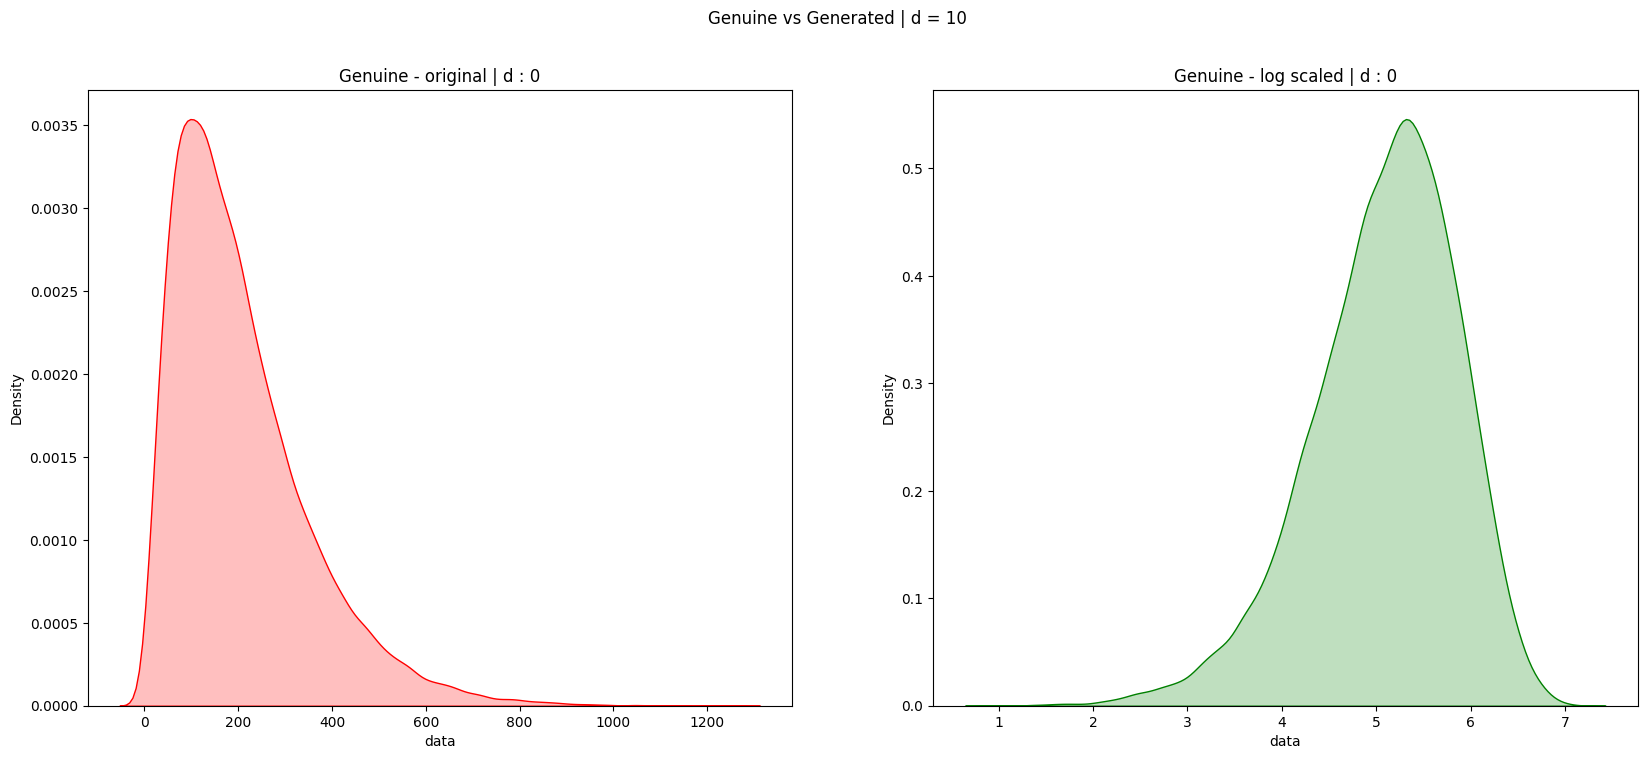

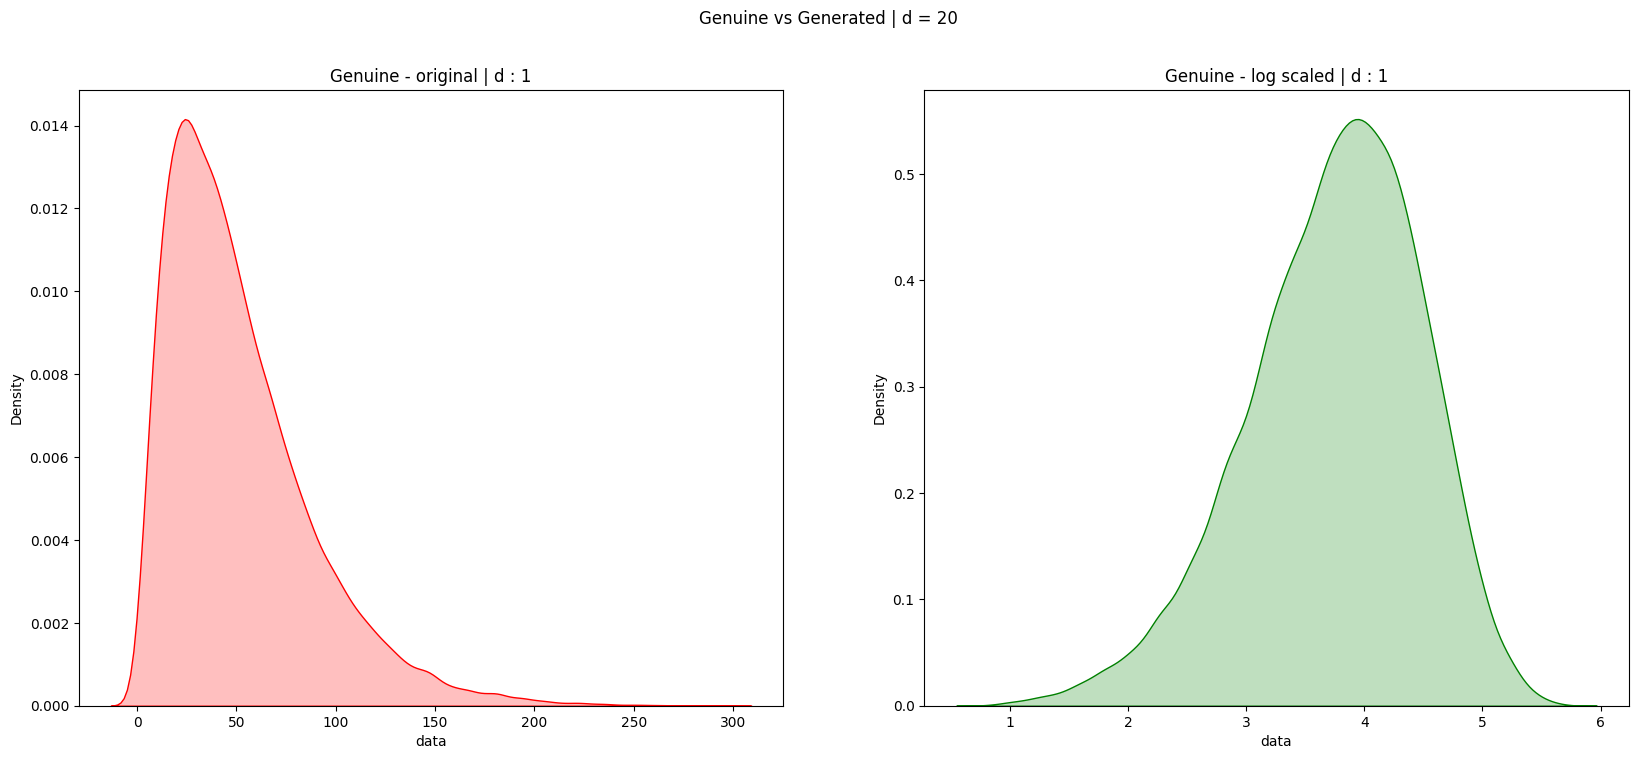

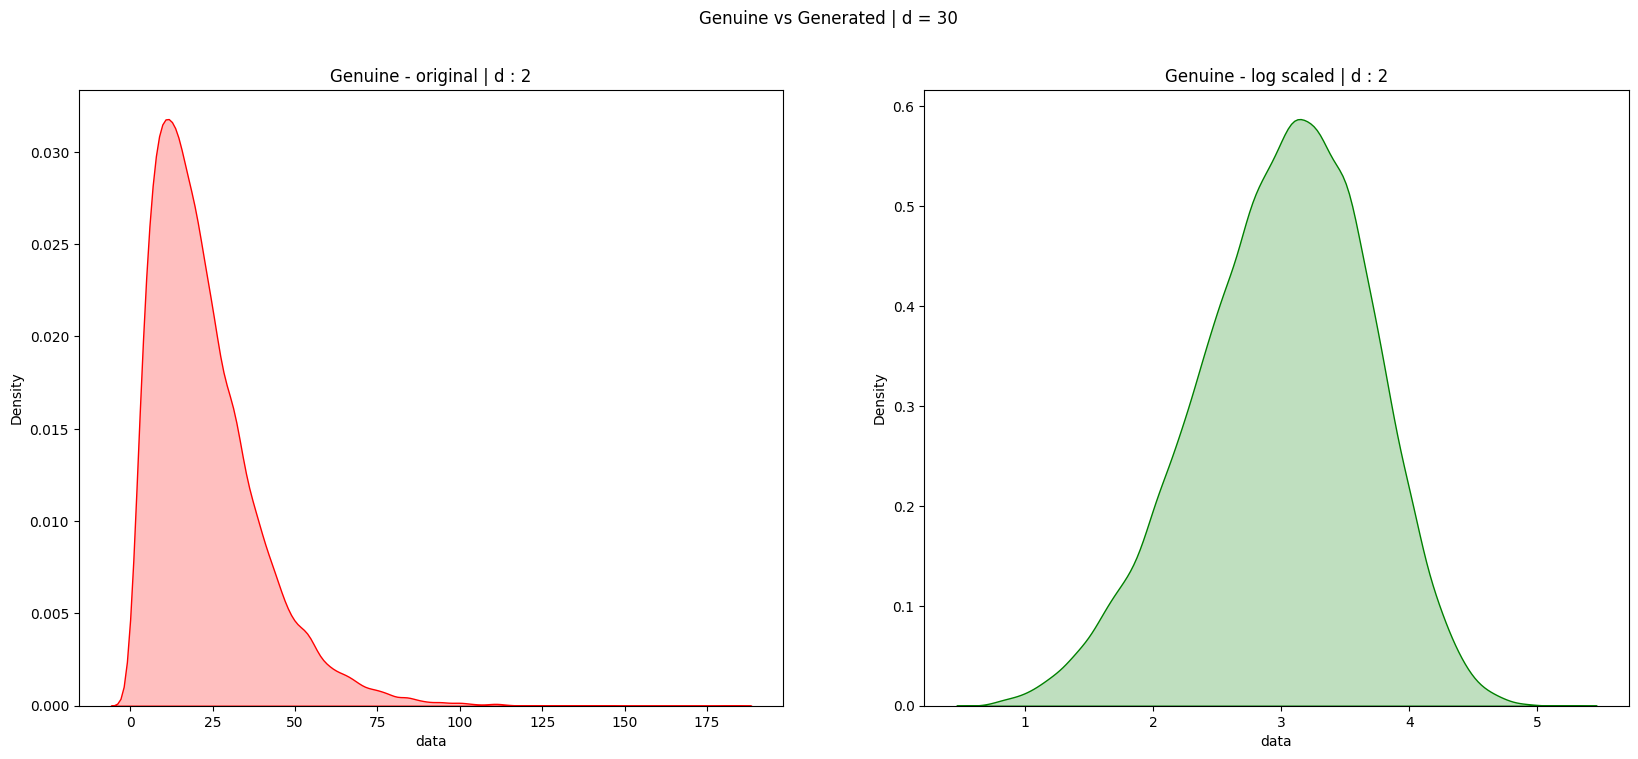

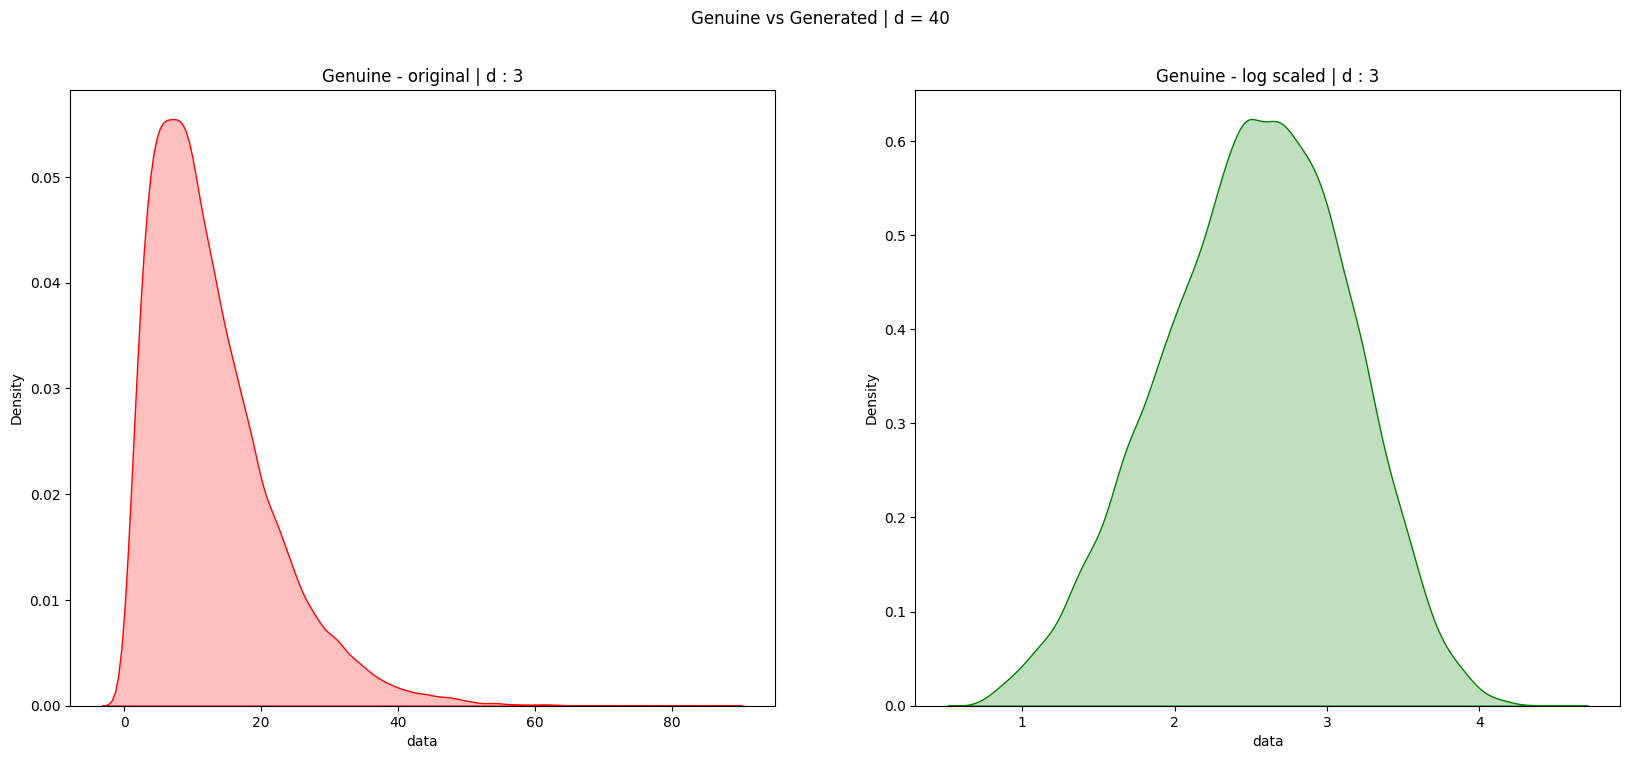

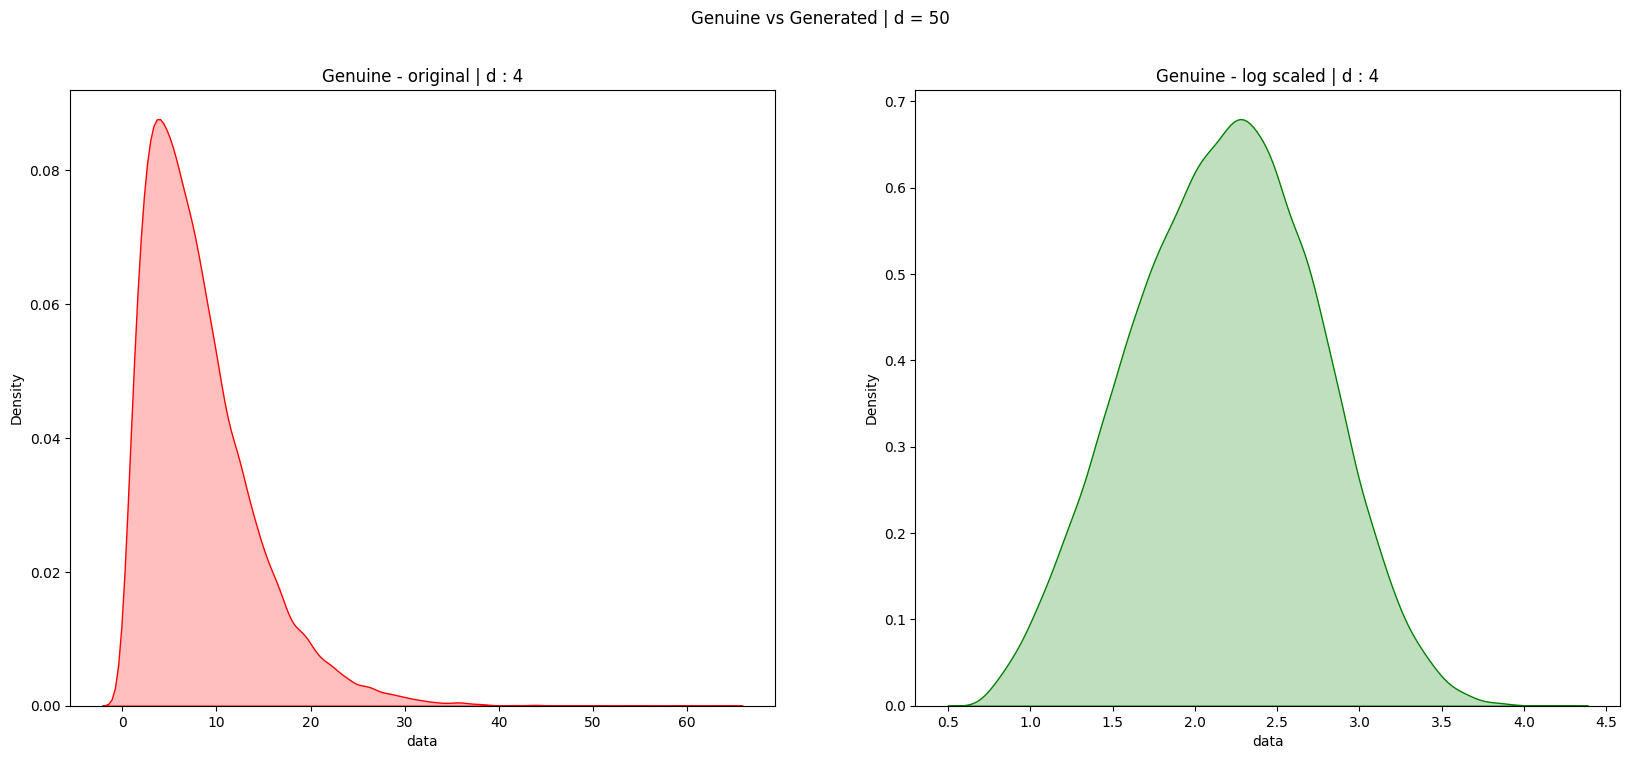

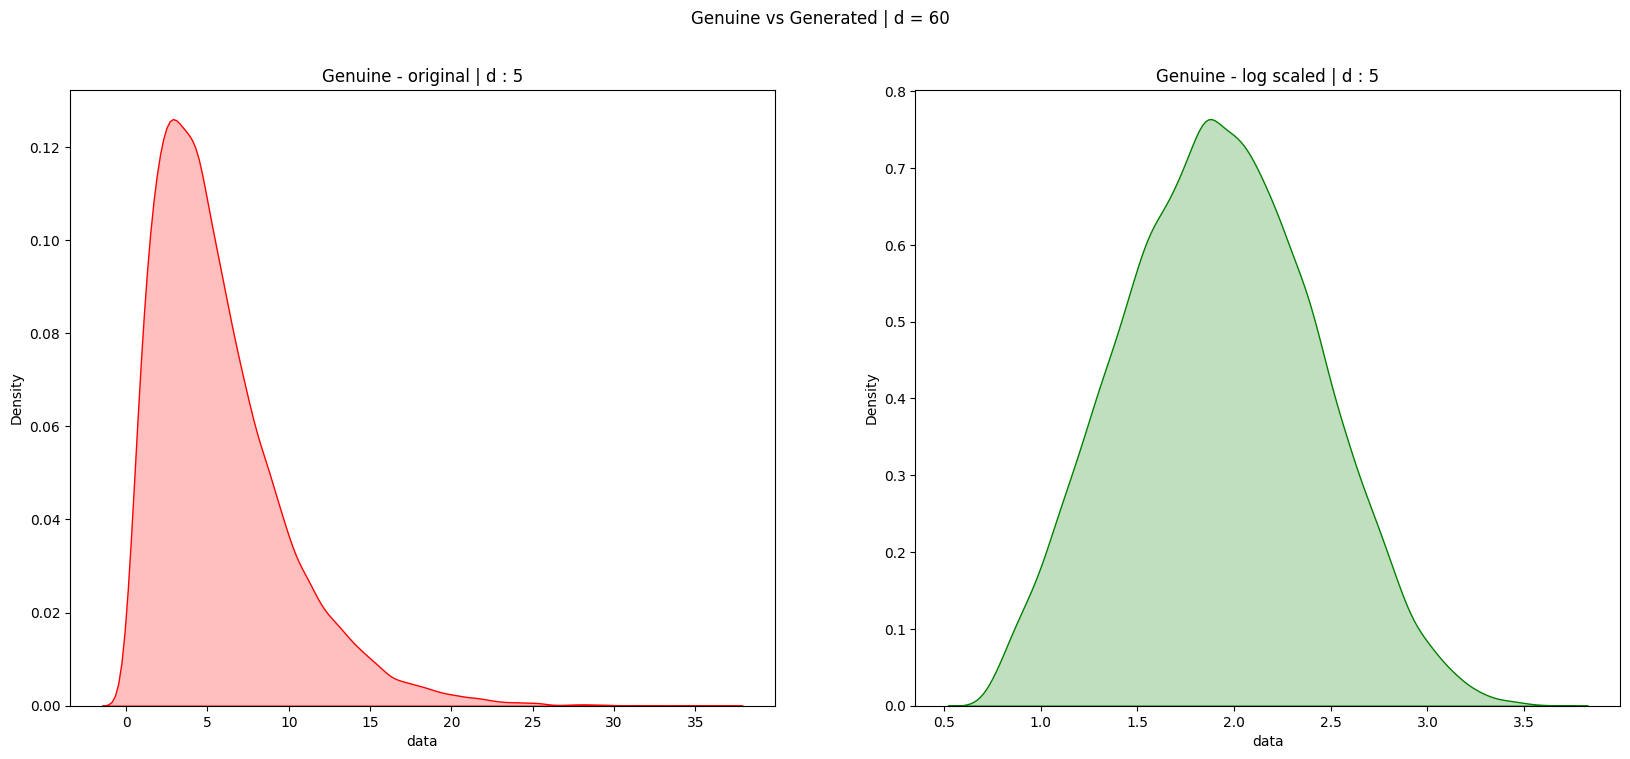

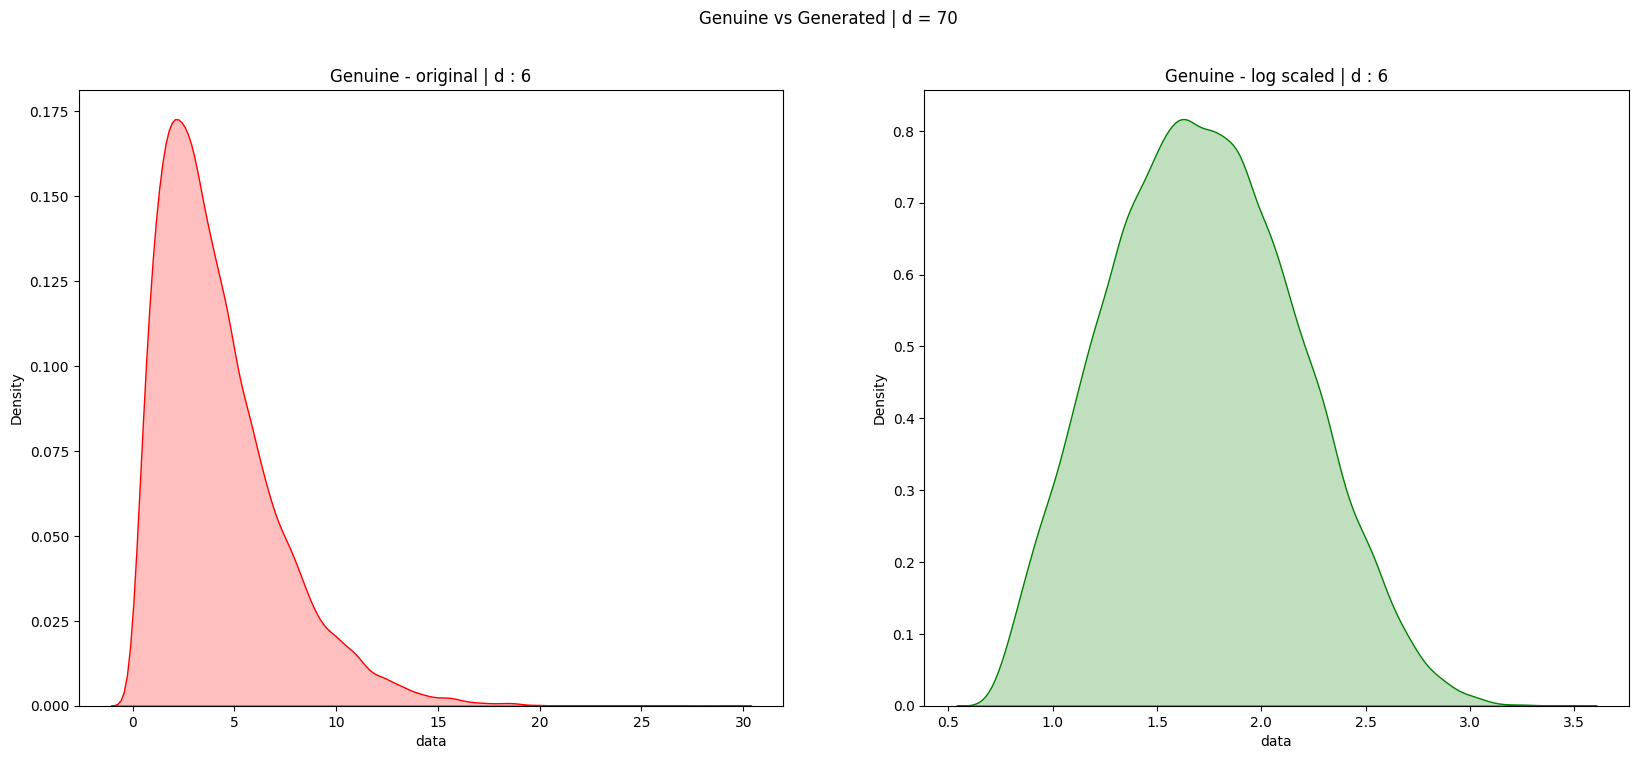

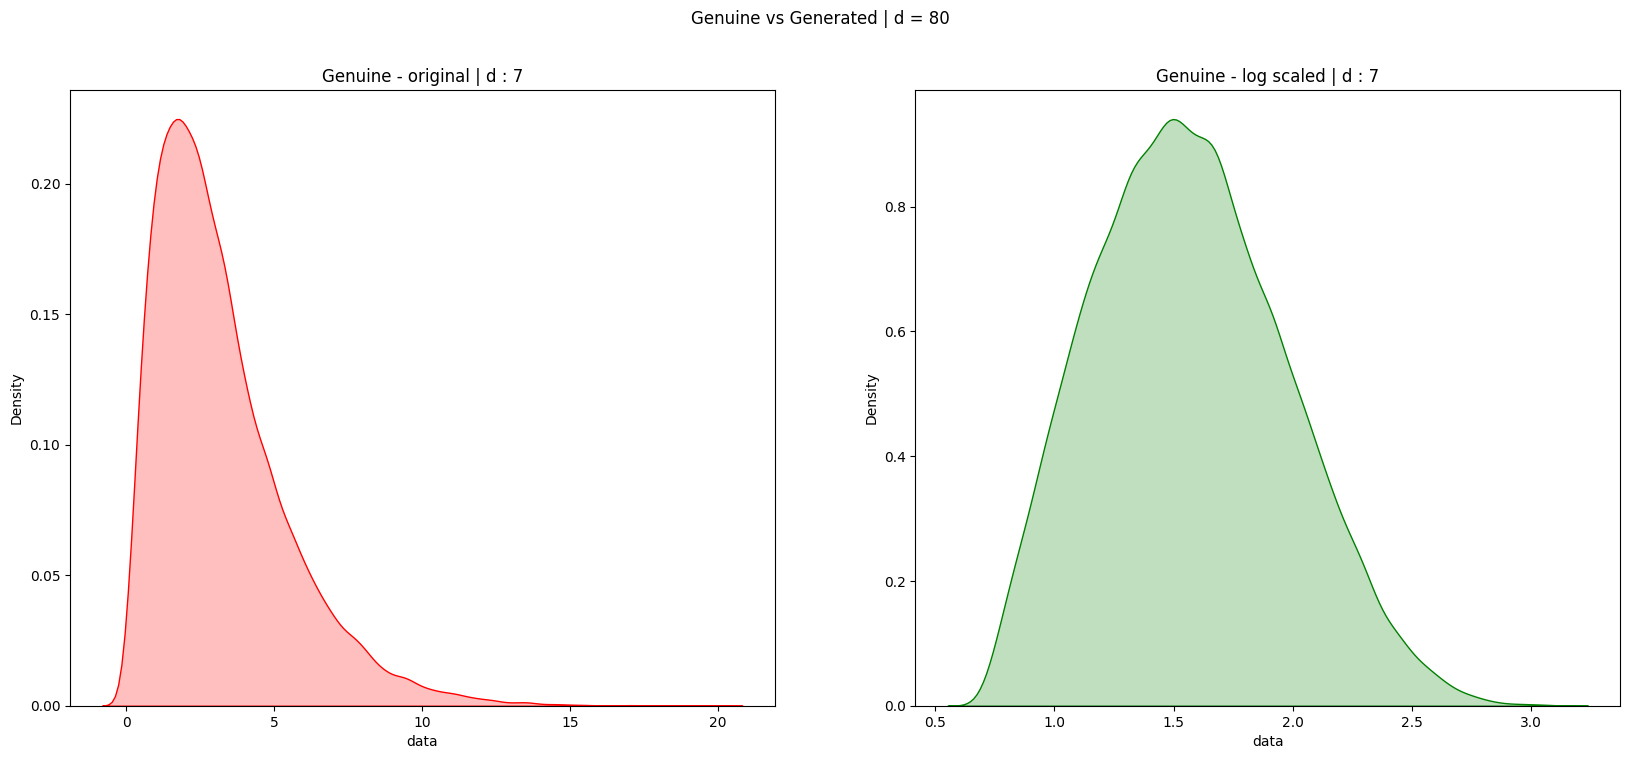

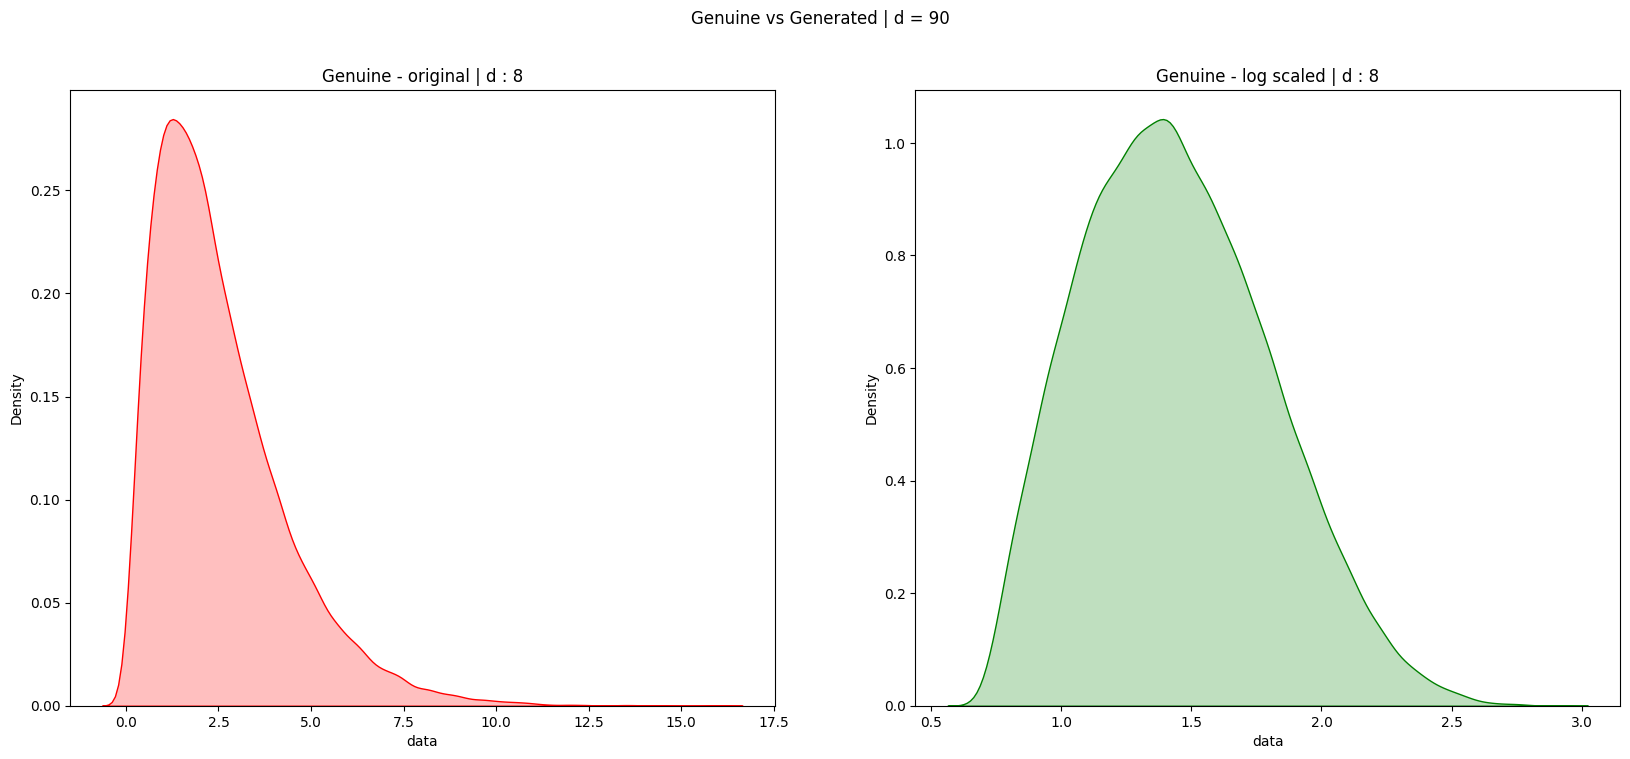

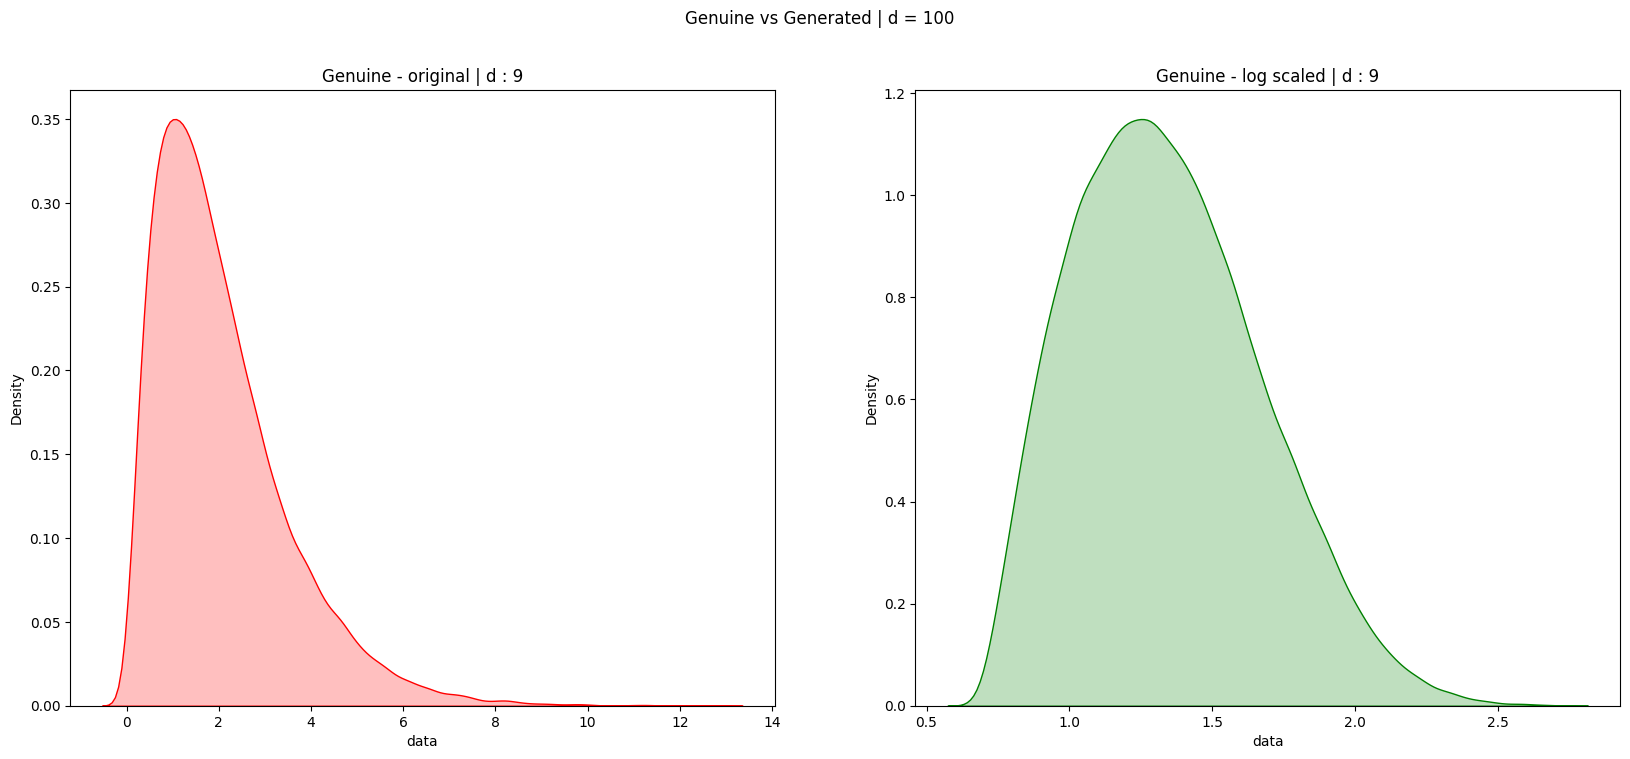

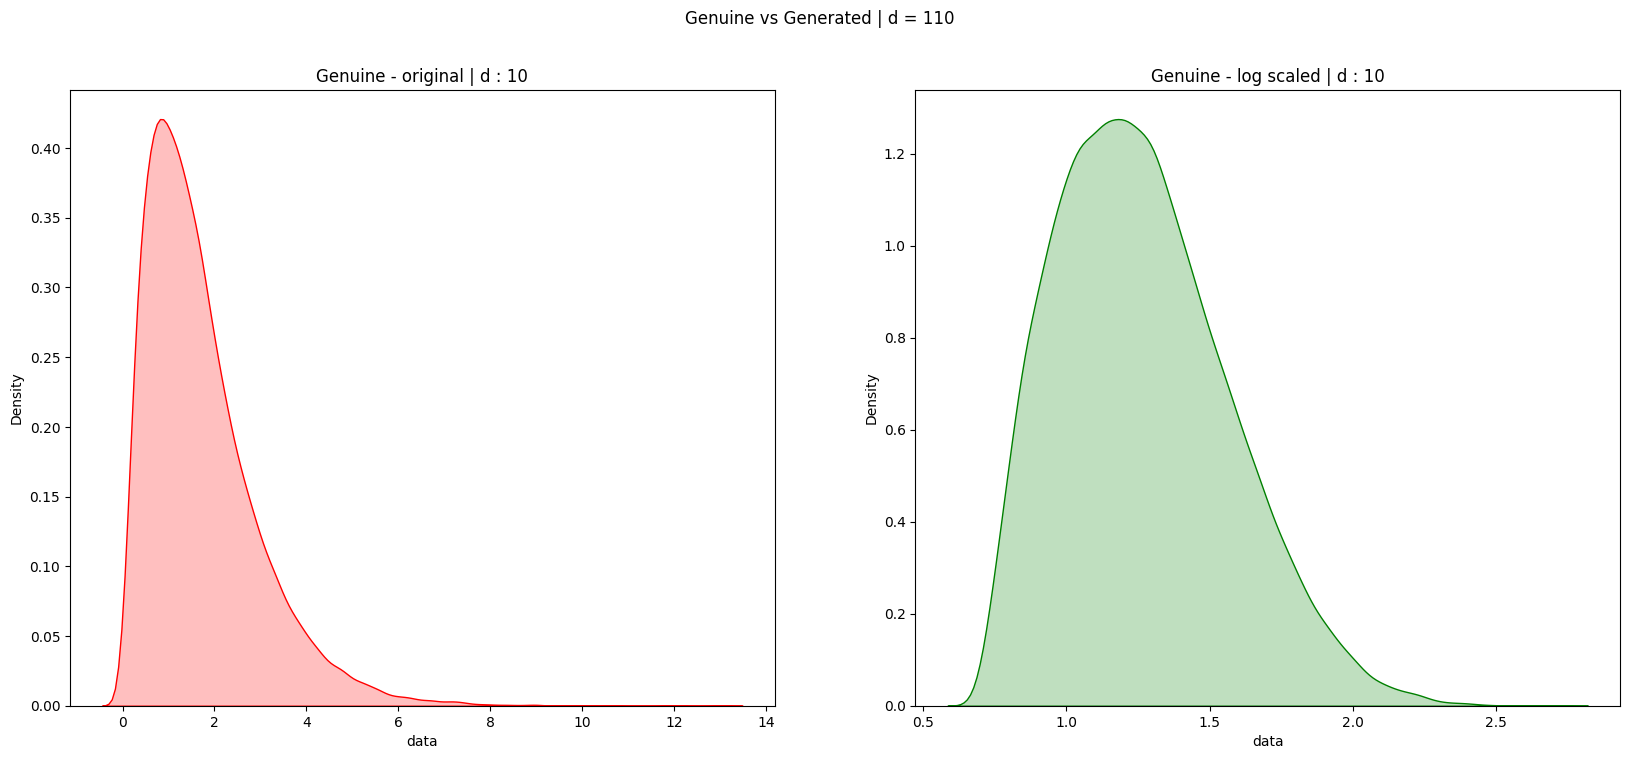

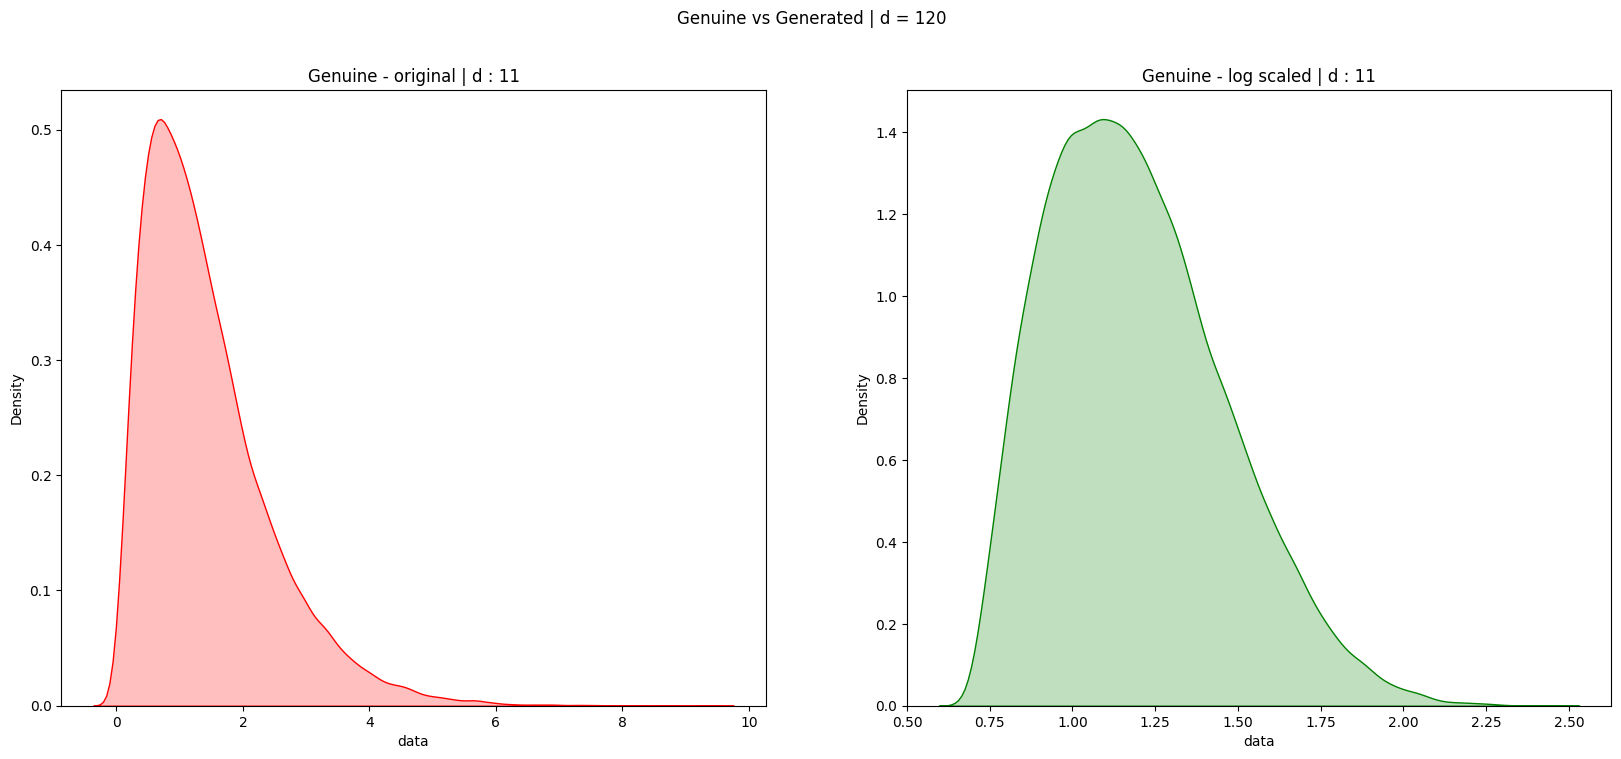

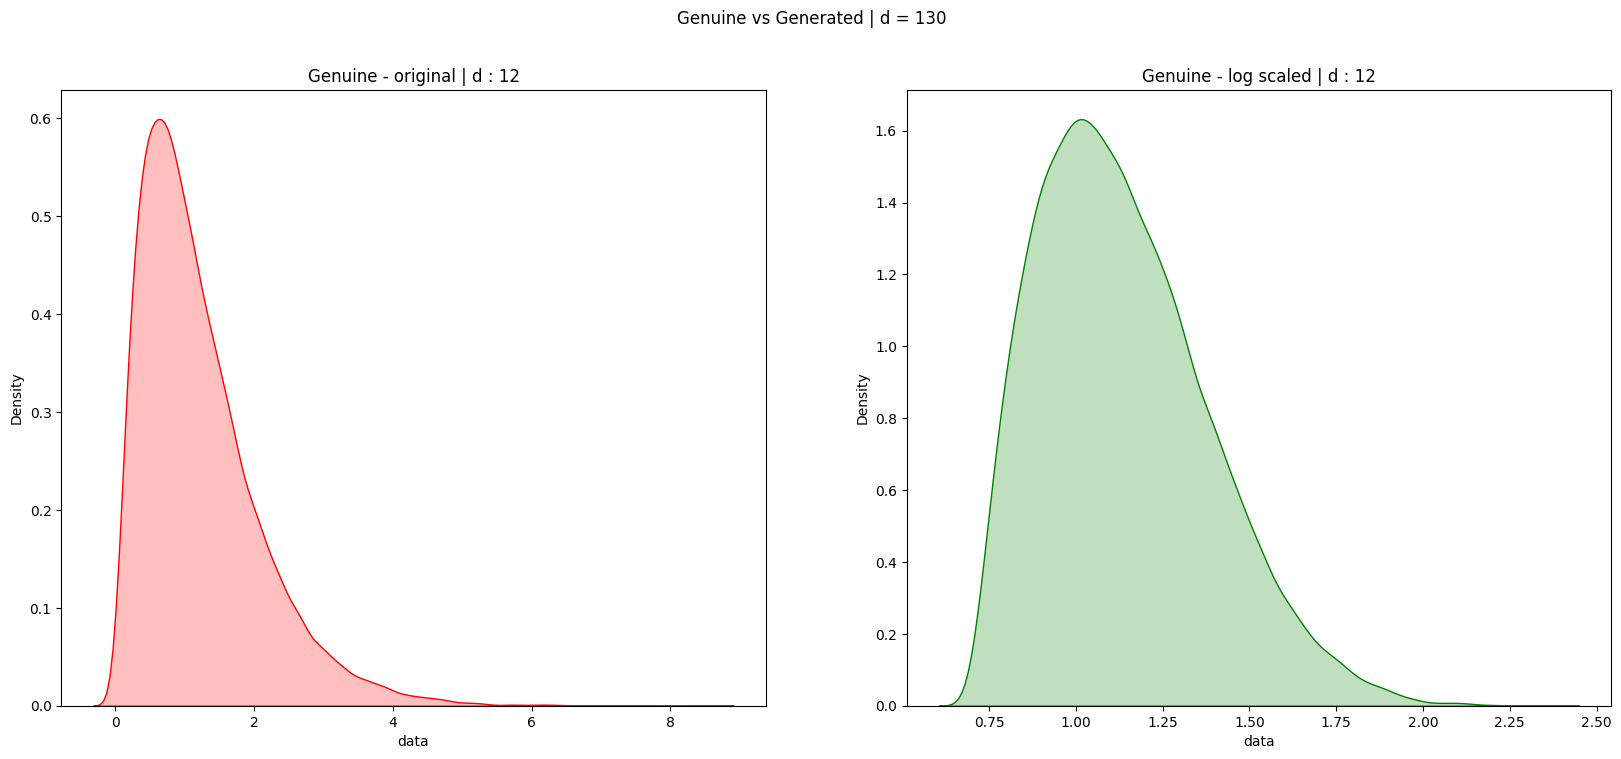

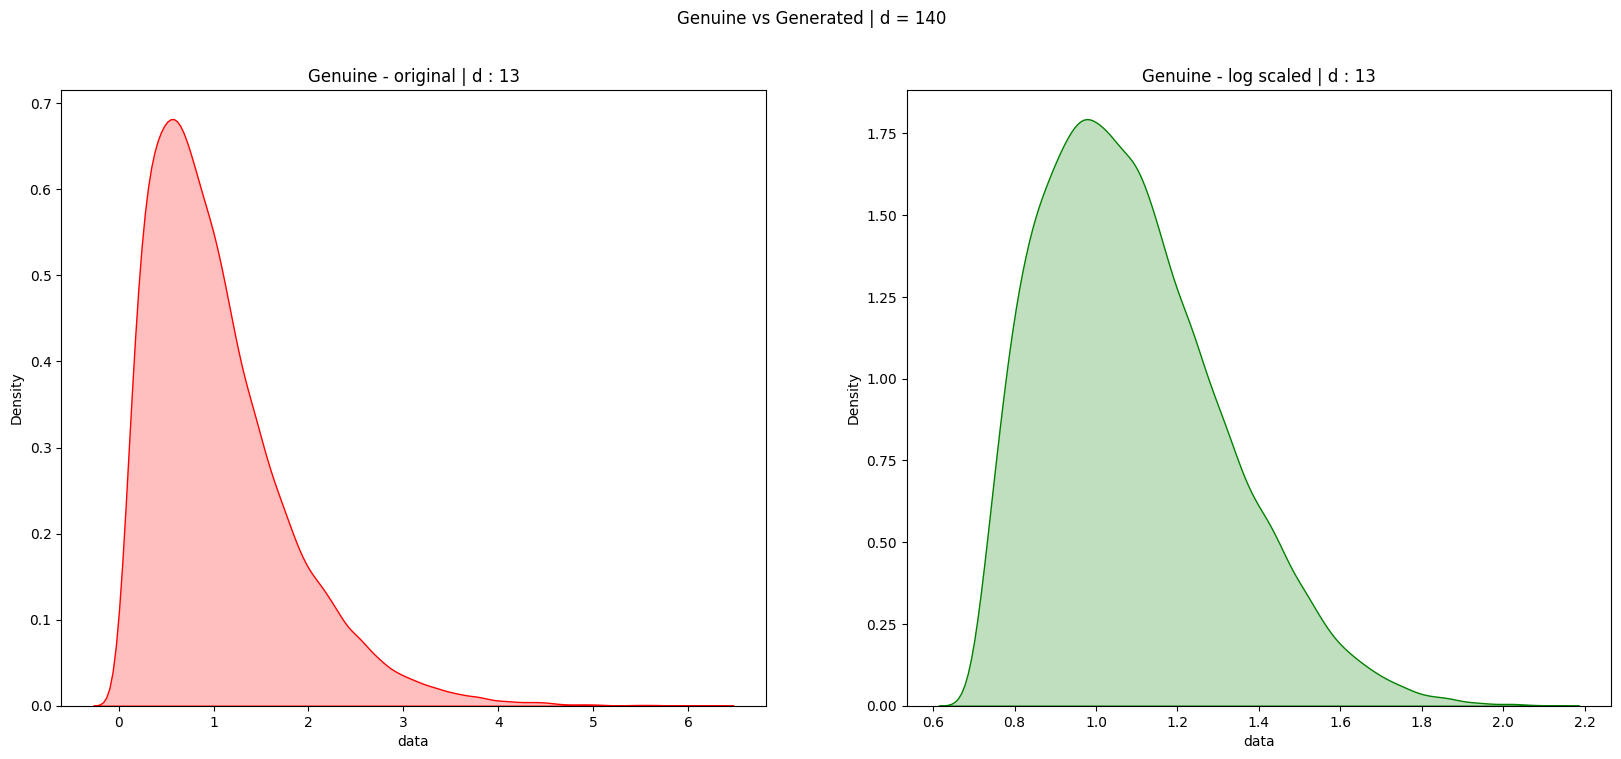

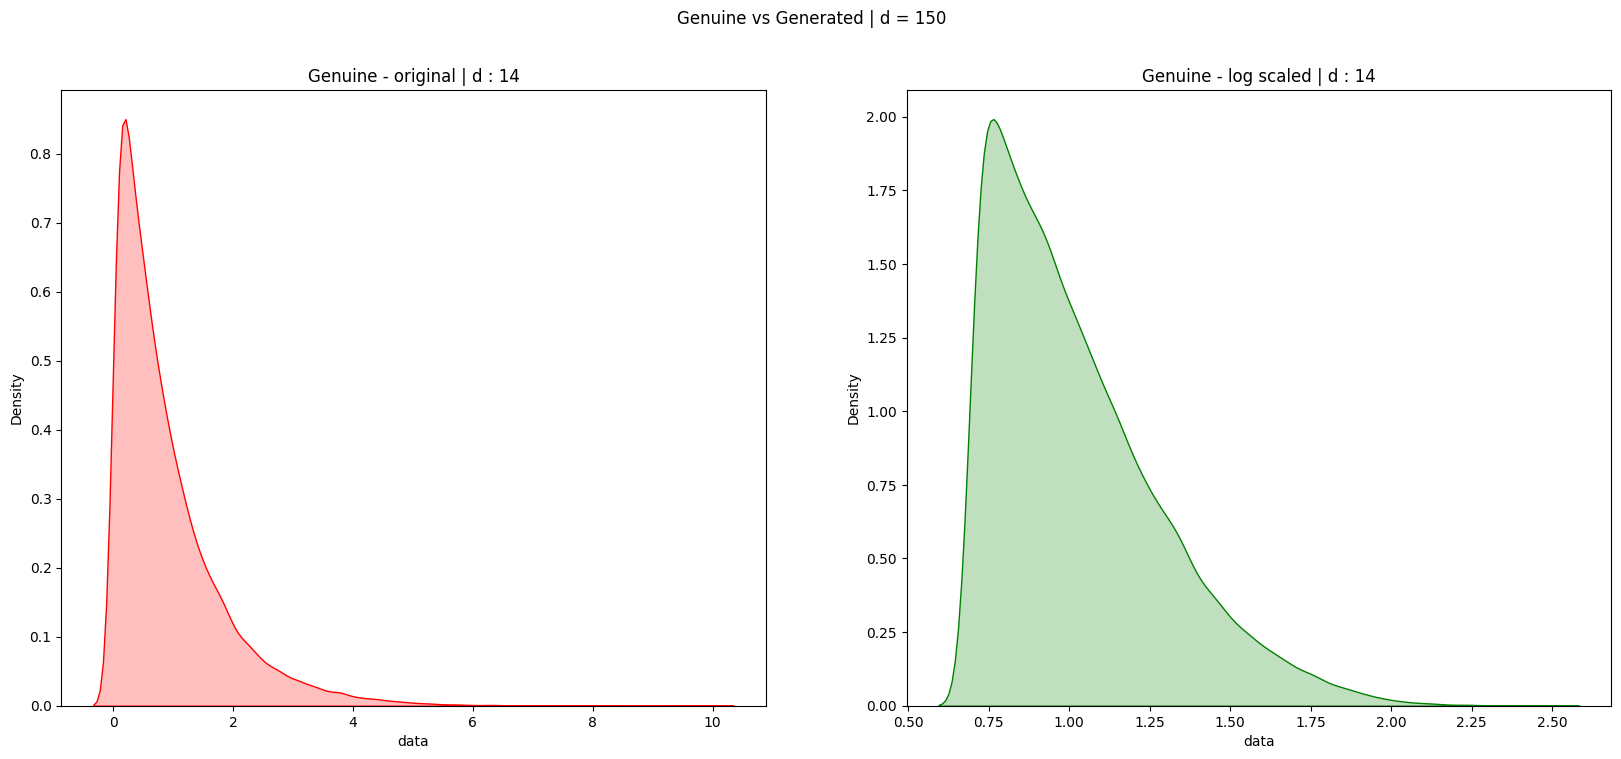

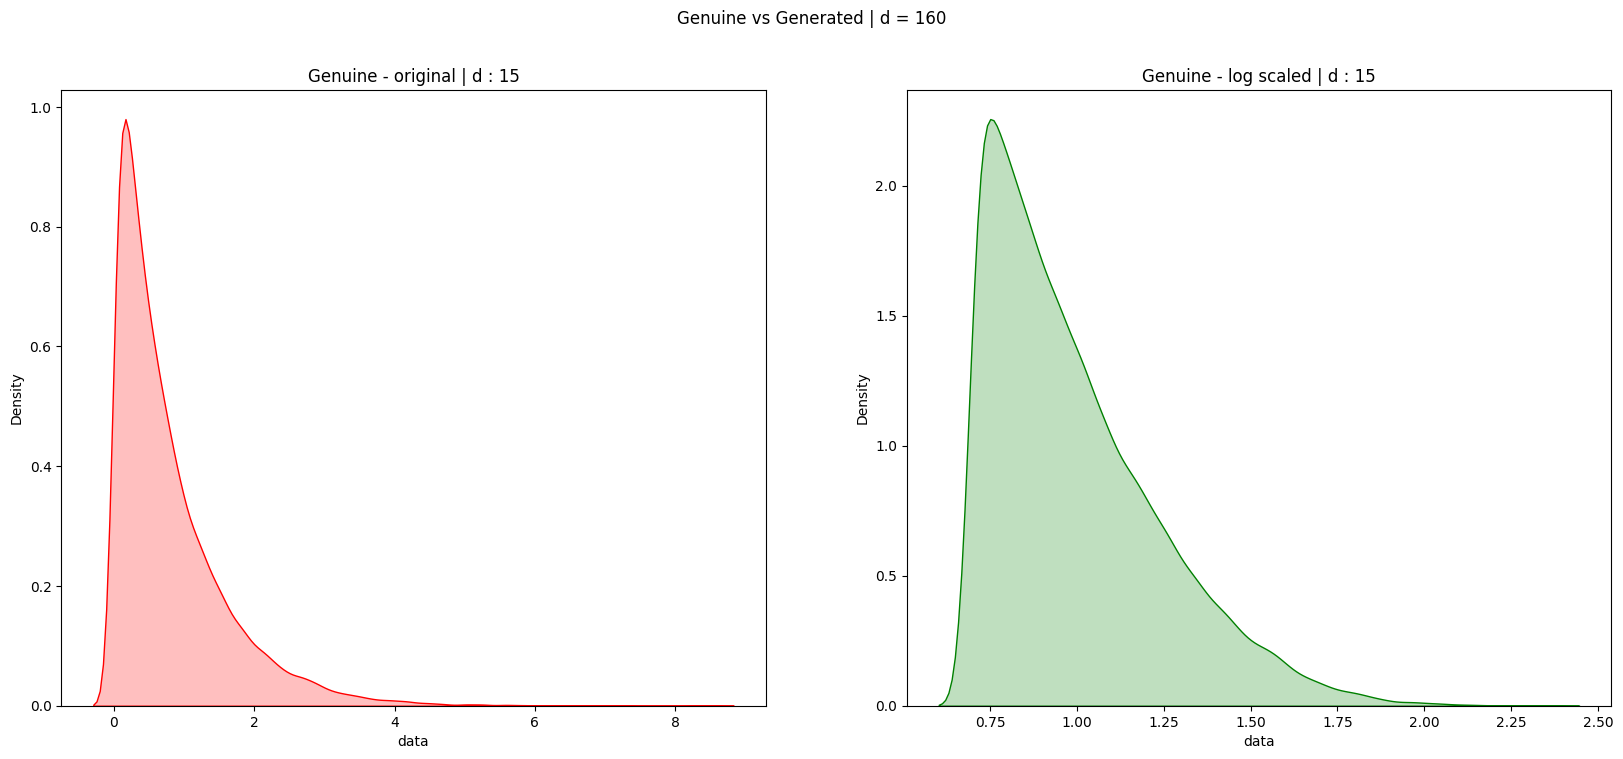

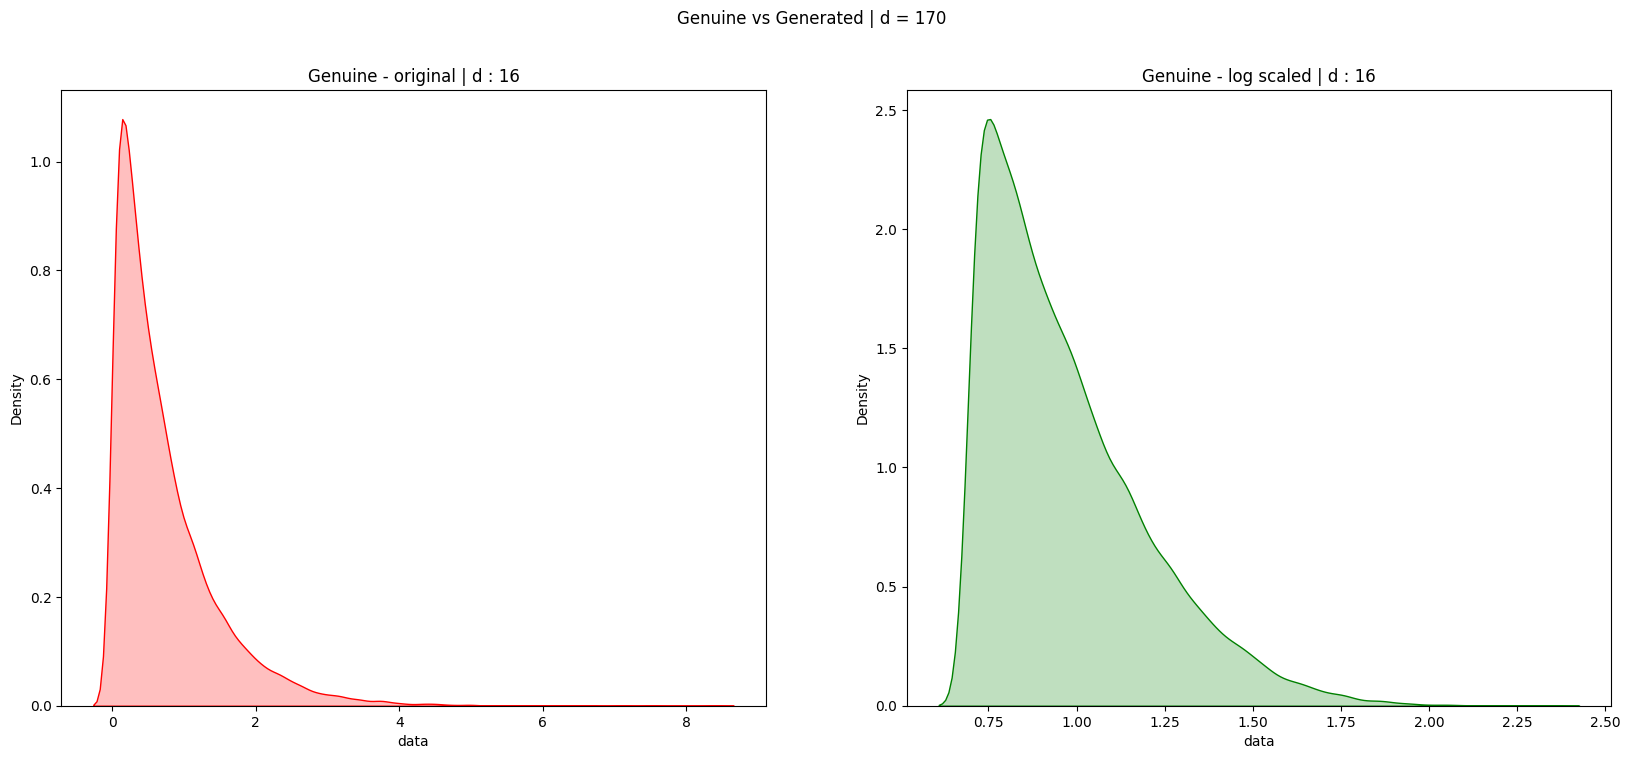

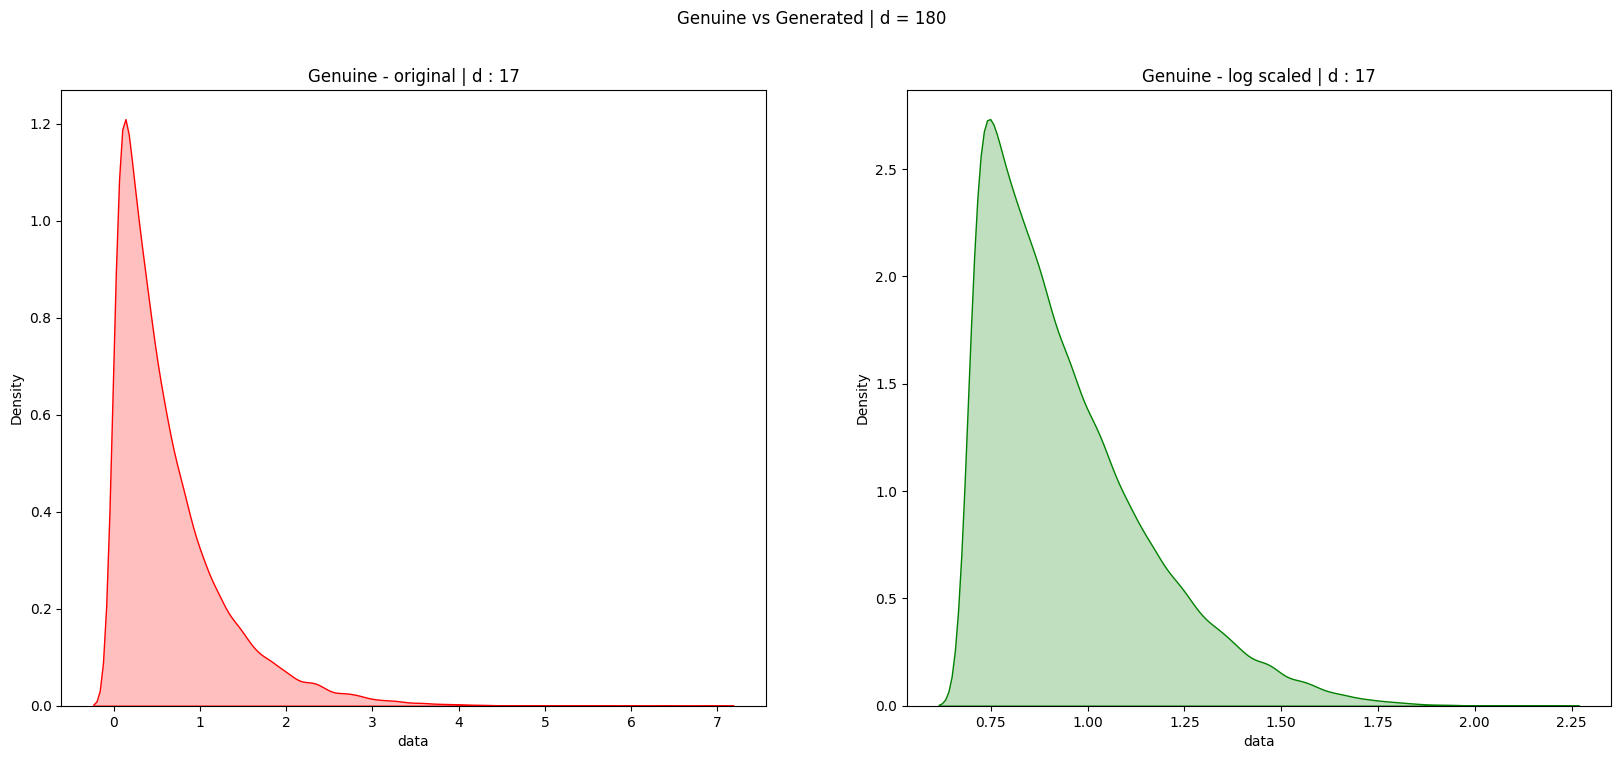

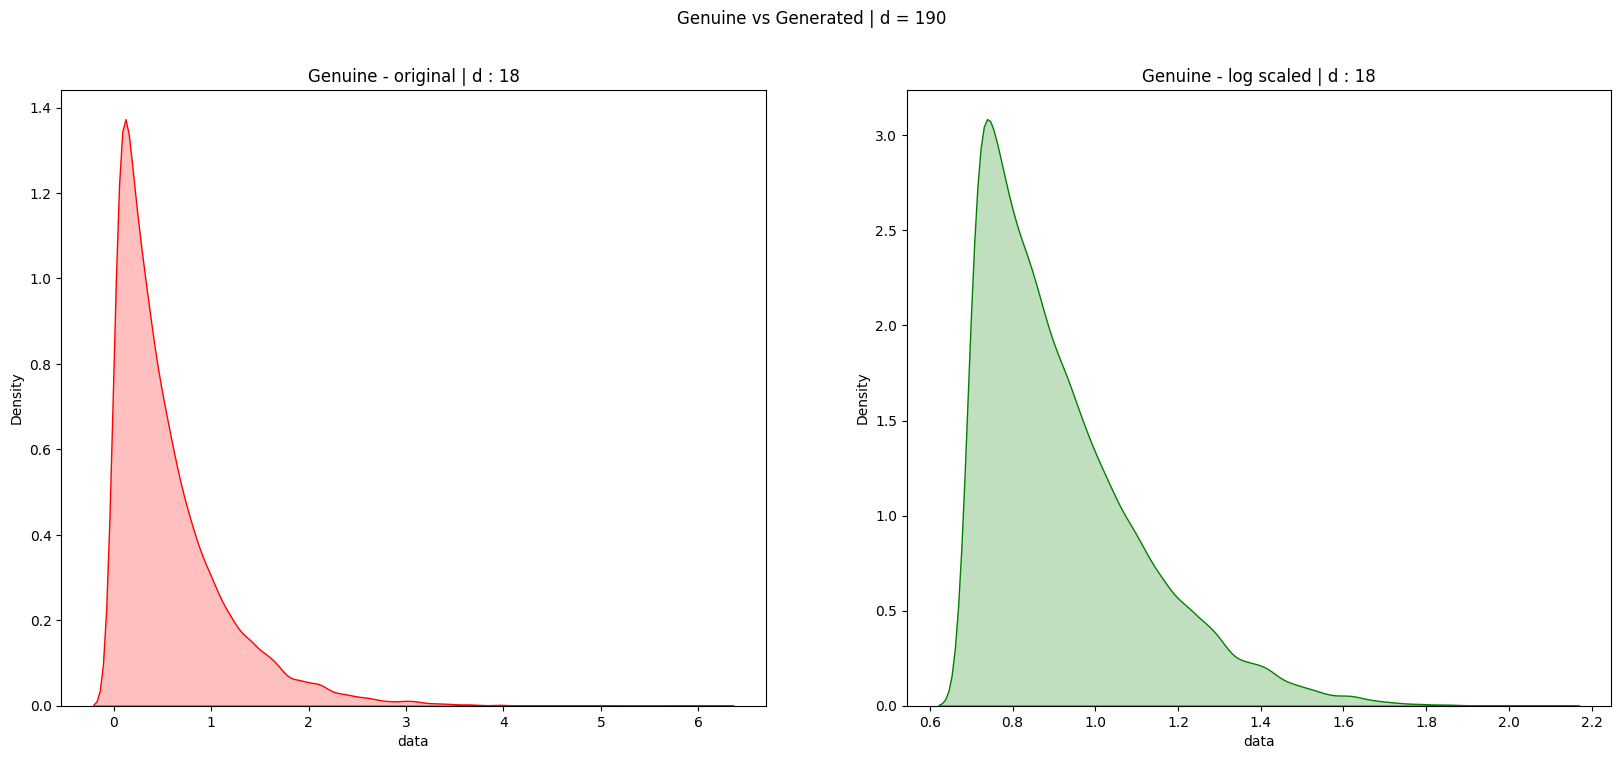

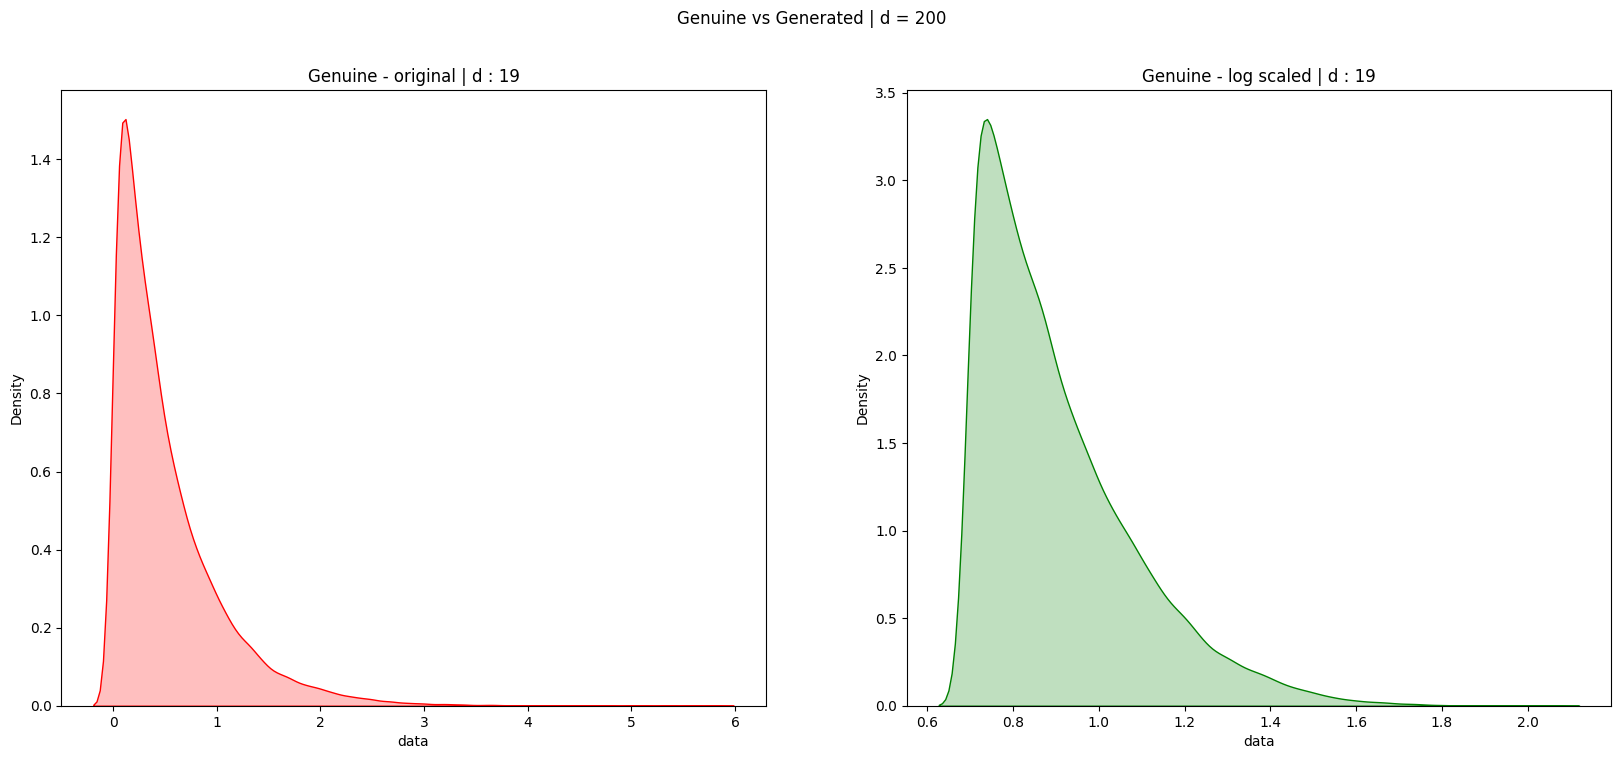

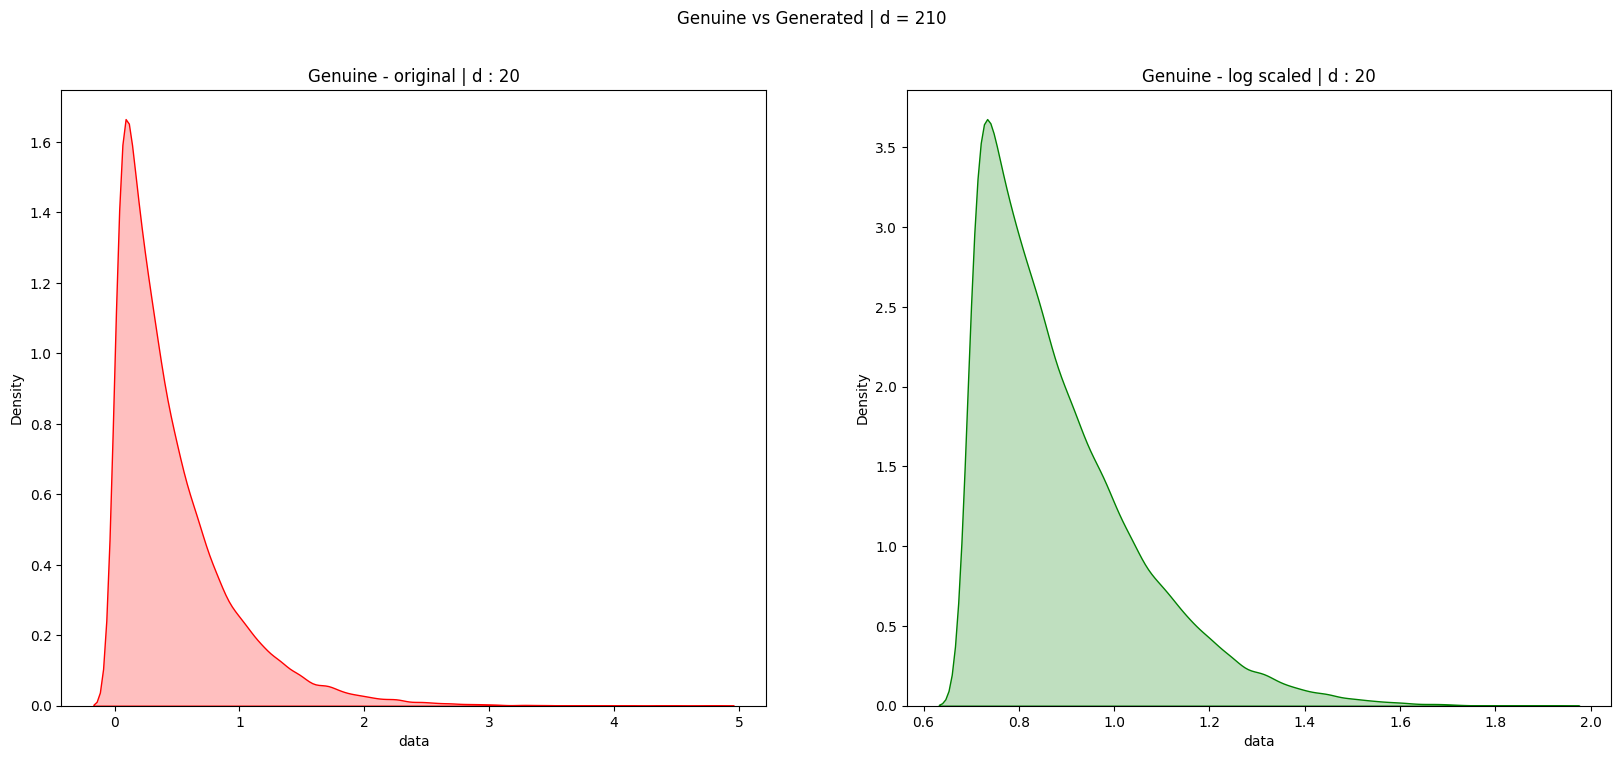

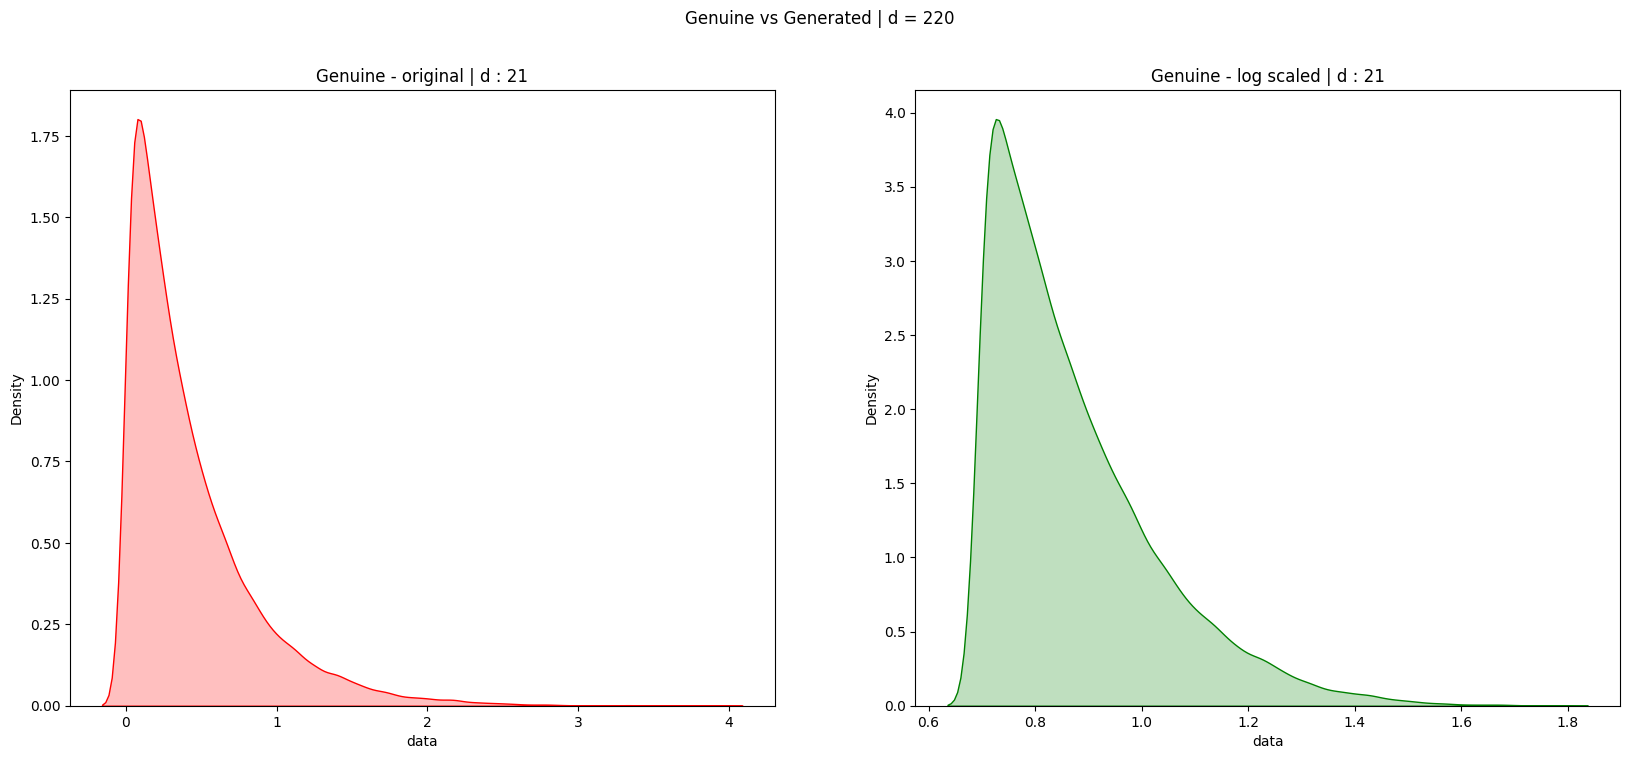

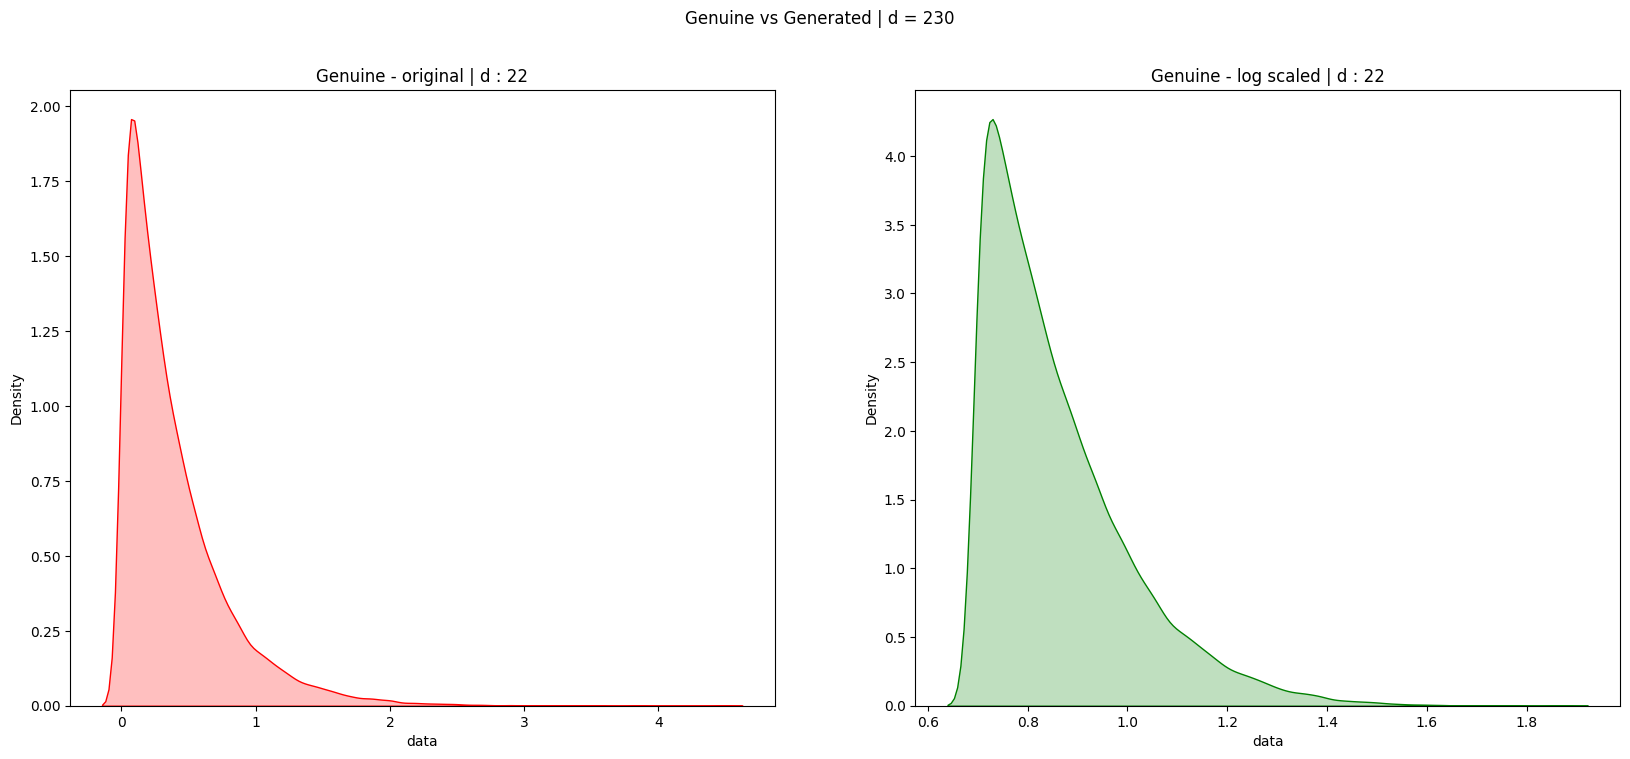

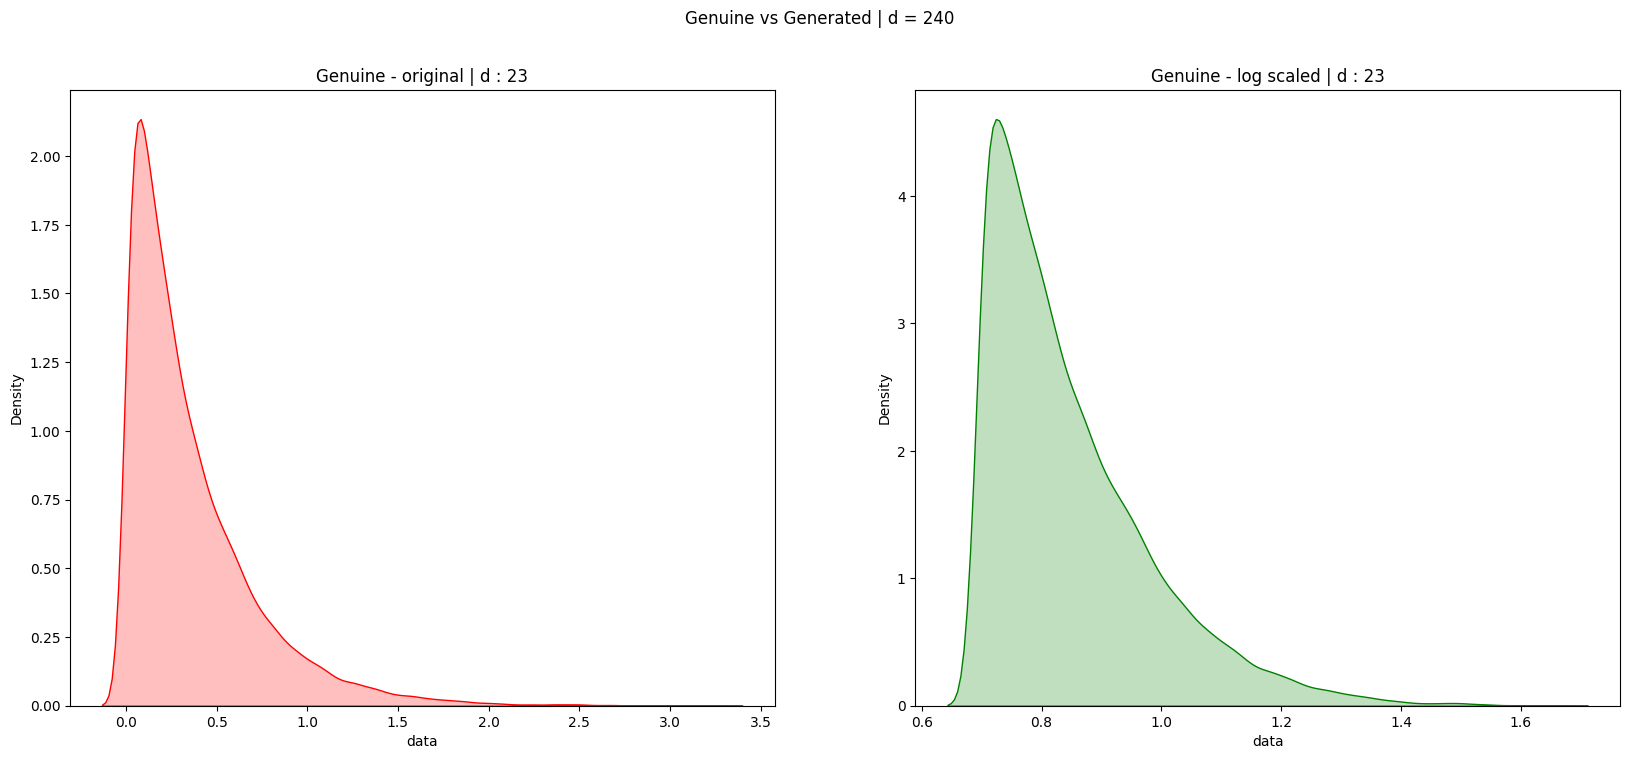

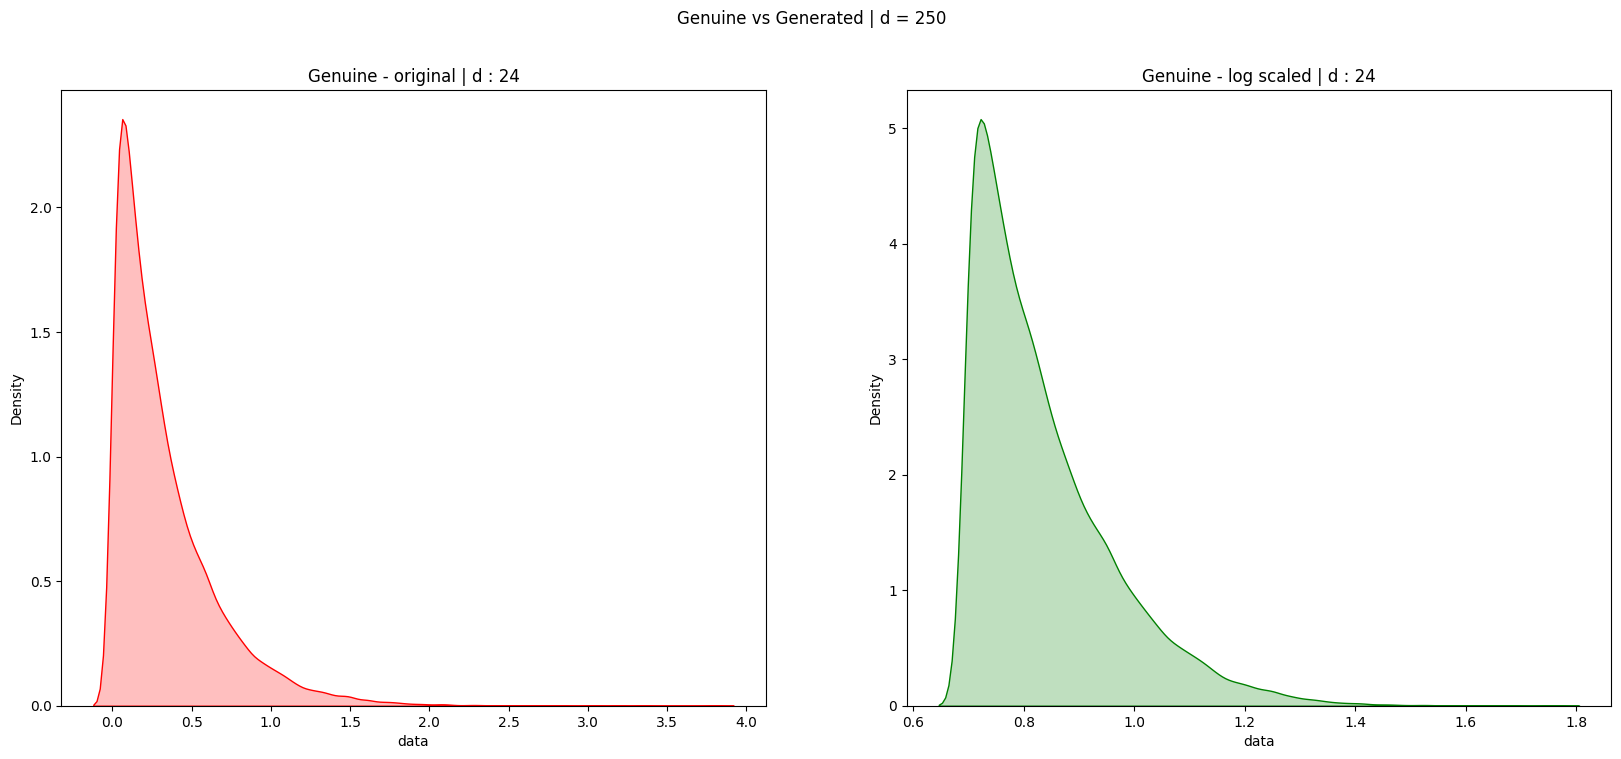

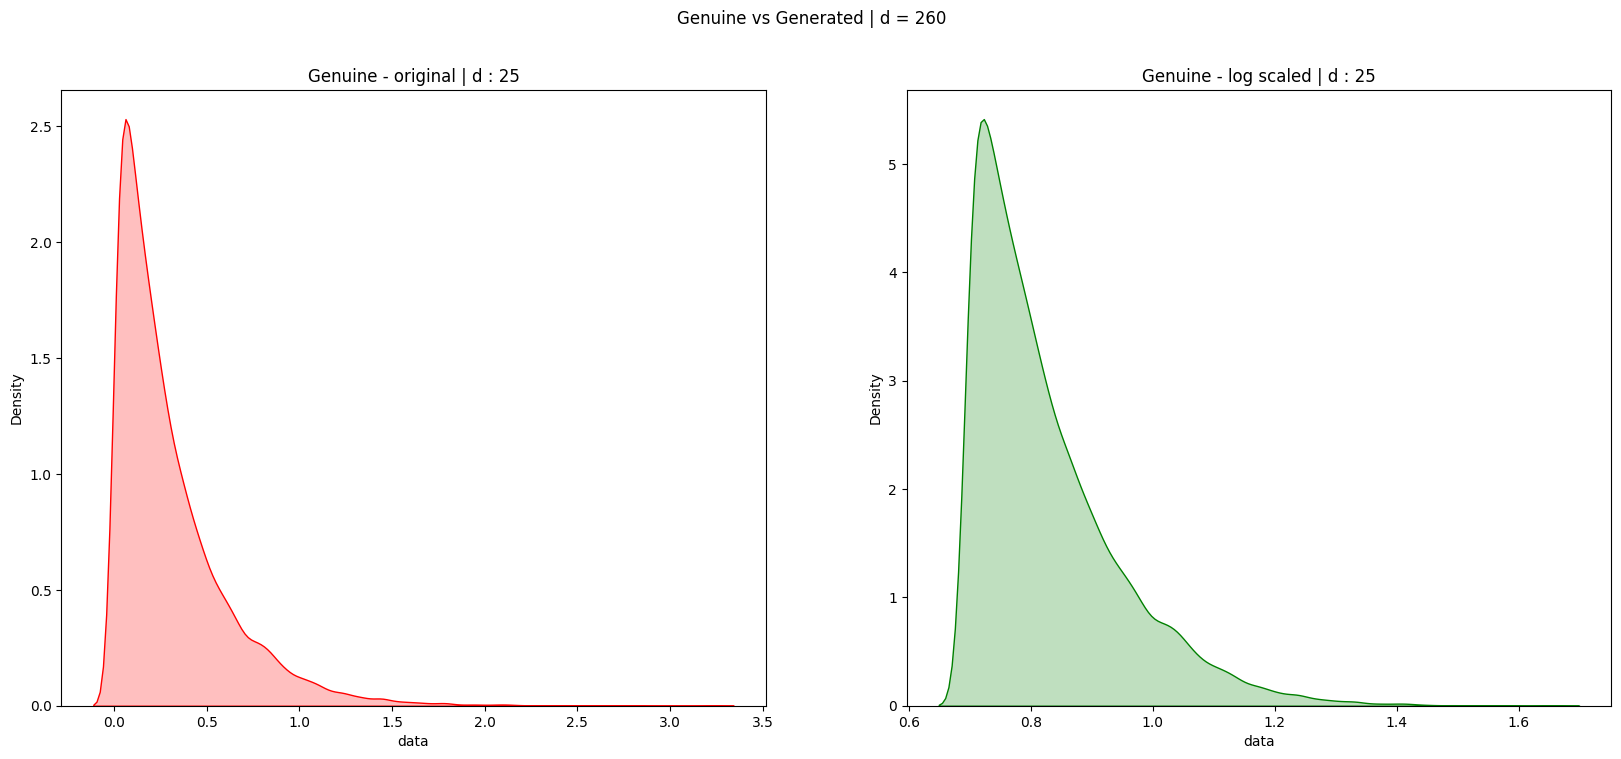

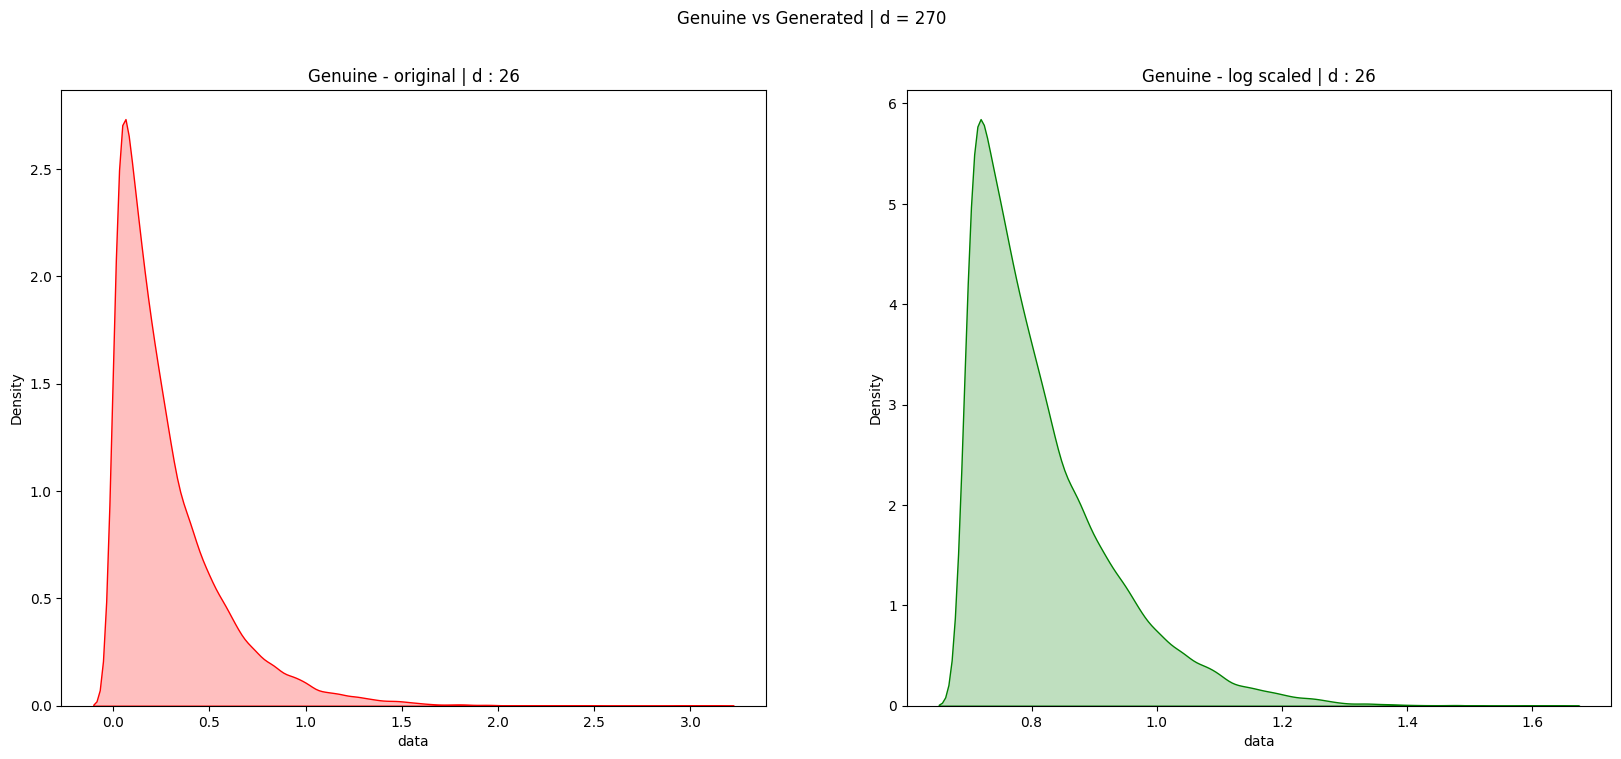

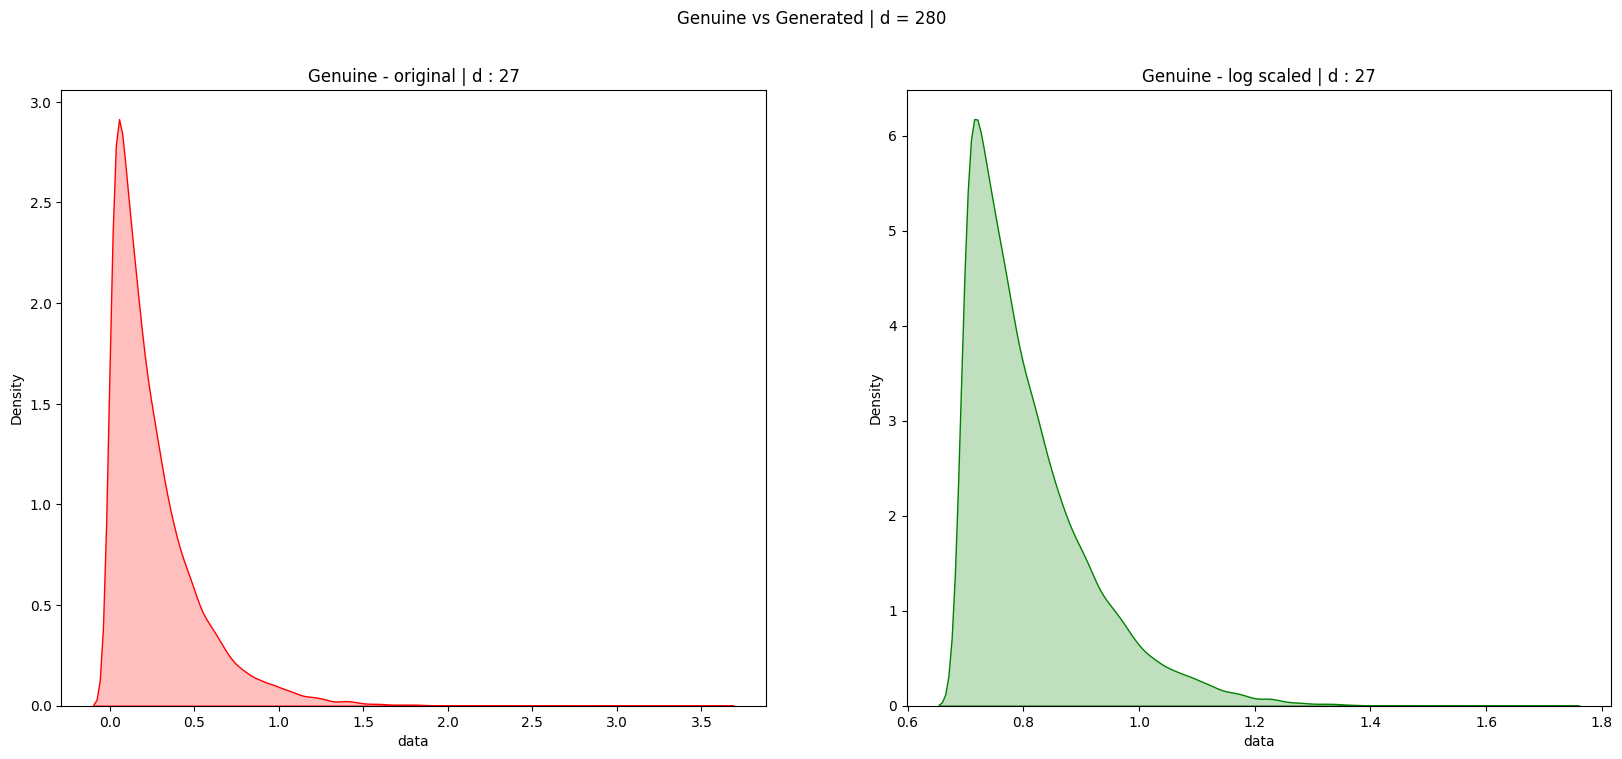

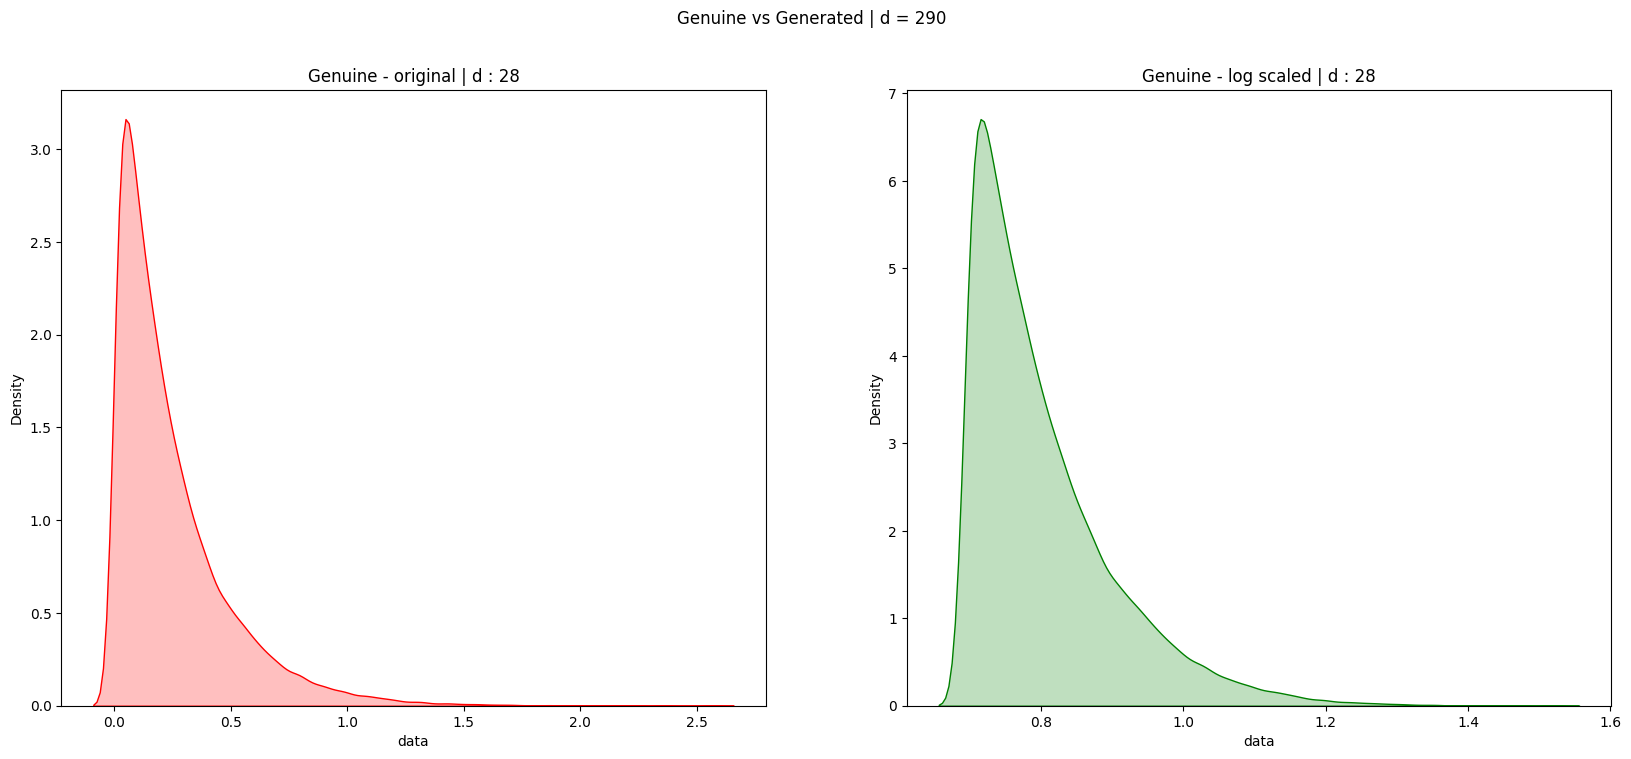

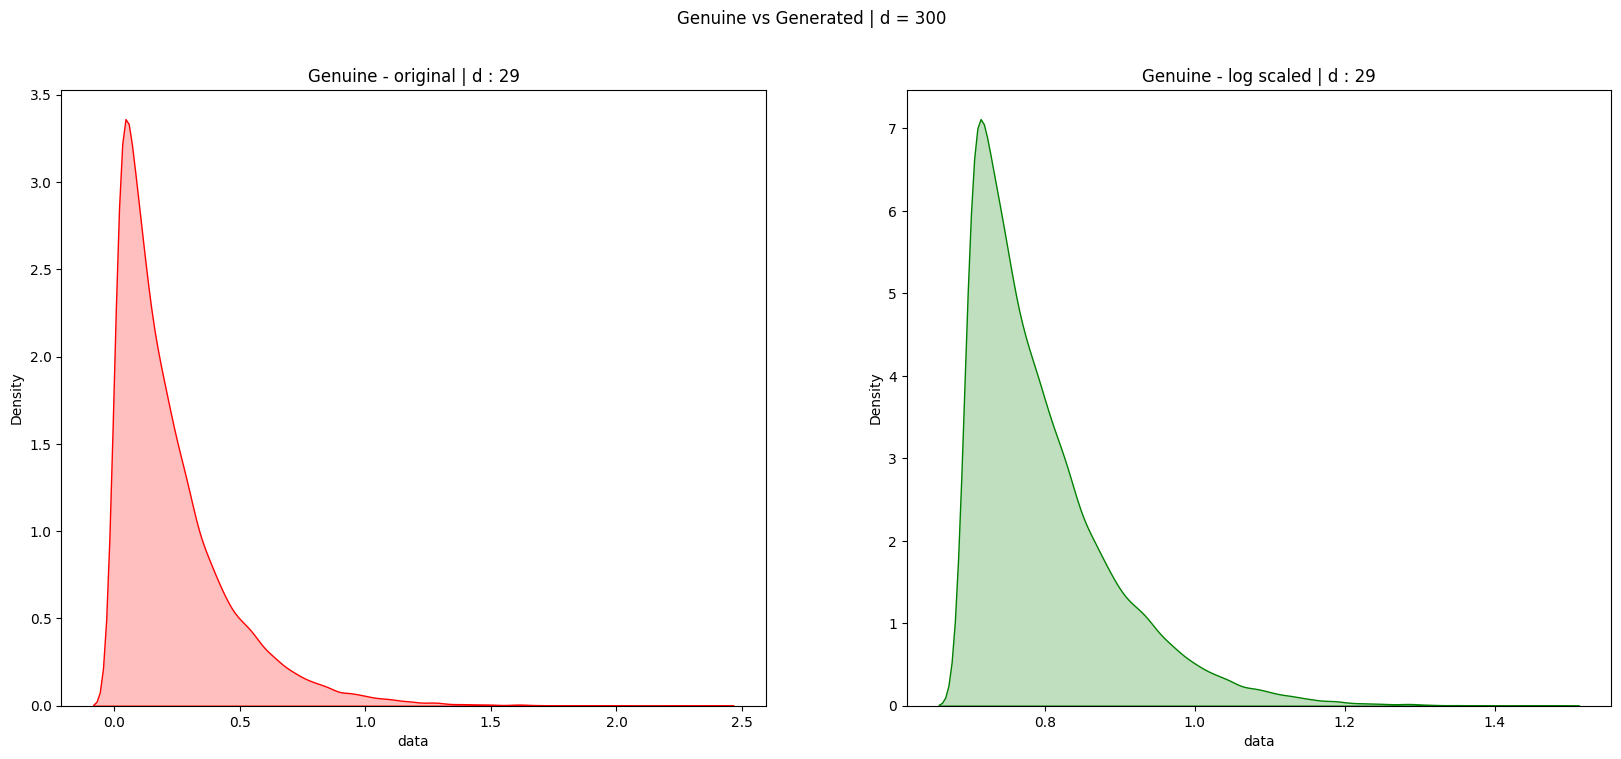

In [10]:
_d_array = np.arange(10, 301, 10, dtype=np.int32)
for i in range(len(df_genuine['d'].unique())):
    # Melt the data to long-form
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    sns.kdeplot(data=df_genuine[df_genuine['d'] == i], x='data', 
                fill=True, ax=ax1, color='red')
    ax1.set_title(f"Genuine - original | d : {i}")
    
    sns.kdeplot(data=df_genuine_log_scaled[df_genuine_log_scaled['d'] == i], 
                x='data', fill=True, ax=ax2, color='green')
    ax2.set_title(f"Genuine - log scaled | d : {i}")
    
    fig.suptitle(f"Genuine vs Generated | d = {_d_array[i]}")
    plt.show()

### Calculate the Ideal mean and var of the Nakagami

In [11]:
df_ideal_mean = pd.DataFrame(data=NakagamiV2Evaluator().validate_mean(), columns=['ideal_data'])
df_ideal_var = pd.DataFrame(data=NakagamiV2Evaluator().validate_var(), columns=['ideal_data'])

### Comparing Genuine Data and Ideal Data

#### Mean

In [12]:
df_mean_comp = pd.concat([df_genuine.groupby('d').mean(), df_ideal_mean], axis=1)
df_per_diff_mean_real = (((df_mean_comp['data'] - df_mean_comp['ideal_data']) / df_mean_comp['ideal_data']) * 100).round(2)
df_per_diff_mean_dict = {'per_diff%':df_per_diff_mean_real, }
df_mean_comp_final = pd.concat([df_mean_comp, pd.DataFrame(df_per_diff_mean_dict)], axis=1)
# df_mean_comp_final[df_mean_comp_final.columns[[0, 2, 4, 1, 3, 5]]]
df_mean_comp_final

data  ideal_data  per_diff%
0.0   205.634883  205.460011       0.09
1.0    51.485410   51.365003       0.23
2.0    22.762870   22.828890      -0.29
3.0    12.784014   12.841251      -0.45
4.0     8.231265    8.218400       0.16
5.0     5.735777    5.707223       0.50
6.0     4.211845    4.193061       0.45
7.0     3.202603    3.210313      -0.24
8.0     2.527766    2.536543      -0.35
9.0     2.054136    2.054600      -0.02
10.0    1.707596    1.698017       0.56
11.0    1.426658    1.426806      -0.01
12.0    1.216248    1.215740       0.04
13.0    1.050406    1.048265       0.20
14.0    0.901276    0.913156      -1.30
15.0    0.794230    0.802578      -1.04
16.0    0.718032    0.710934       1.00
17.0    0.637698    0.634136       0.56
18.0    0.567392    0.569141      -0.31
19.0    0.513802    0.513650       0.03
20.0    0.462810    0.465896      -0.66
21.0    0.426273    0.424504       0.42
22.0    0.390094    0.388393       0.44
23.0    0.357845    0.356701       0.32
24.0    0.328726    0.328736      -0.00
25.0    0.303745    0.303935      -0.06
26.0    0.280725    0.281838      -0.40
27.0    0.263265    0.262066       0.46
28.0    0.244032    0.244304      -0.11
29.0    0.229253    0.228289       0.42

### Var

In [13]:
df_var_comp = pd.concat([df_genuine.groupby('d').var(), df_ideal_var], axis=1)
df_per_diff_var_real = (((df_var_comp['data'] - df_var_comp['ideal_data']) / df_var_comp['ideal_data']) * 100).round(2)
df_per_diff_var_dict = {'per_diff%':df_per_diff_var_real, }
df_var_comp_final = pd.concat([df_var_comp, pd.DataFrame(df_per_diff_var_dict)], axis=1)
# df_mean_comp_final[df_mean_comp_final.columns[[0, 2, 4, 1, 3, 5]]]
df_var_comp_final

data    ideal_data  per_diff%
0.0   21101.105259  21106.908132      -0.03
1.0    1338.511240   1319.181758       1.47
2.0     261.266899    260.579113       0.26
3.0      80.031005     82.448860      -2.93
4.0      34.154668     33.771053       1.14
5.0      16.602122     16.286195       1.94
6.0       8.767099      8.790882      -0.27
7.0       5.103412      5.153054      -0.96
8.0       3.152510      3.217026      -2.01
9.0       2.111104      2.110691       0.02
10.0      1.481984      1.441630       2.80
11.0      1.006749      1.017887      -1.09
12.0      0.745887      0.739012       0.93
13.0      0.547690      0.549430      -0.32
14.0      0.813900      0.833853      -2.39
15.0      0.636981      0.644132      -1.11
16.0      0.516095      0.505428       2.11
17.0      0.405380      0.402128       0.81
18.0      0.326863      0.323922       0.91
19.0      0.266801      0.263836       1.12
20.0      0.211627      0.217059      -2.50
21.0      0.181839      0.180204       0.91
22.0      0.151683      0.150849       0.55
23.0      0.127587      0.127236       0.28
24.0      0.106856      0.108067      -1.12
25.0      0.091652      0.092376      -0.78
26.0      0.079244      0.079433      -0.24
27.0      0.069574      0.068679       1.30
28.0      0.060364      0.059685       1.14
29.0      0.052014      0.052116      -0.20

# AI modeling

In [14]:
import tensorflow as tf
from keras.layers import Input, Flatten, multiply, BatchNormalization, Dropout
from keras.layers import Dense, Embedding
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from tensorflow.keras import backend as K

In [15]:
class cGAN_V2():
    def __init__(self):
        self.Z_dim = 16
        self.output_vec_len = 1
        self.embedding_output_len = 2
        self.rough_condition_dim = NakagamiV2().generate(1)[1].shape[1]
        self.condition_dim = self.embedding_output_len + (self.rough_condition_dim - 1) # length of r == (2 - 1)
        self.condition_depth = 2

        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=5e-5)

        # Discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])
        
        # Generator
        self.generator = self.build_generator()
        z = Input(shape=(self.Z_dim, ))
        label = Input(shape=(self.rough_condition_dim, ))
        signal = self.generator([z, label])
        
        self.discriminator.trainable = False
        prediction = self.discriminator([signal, label])

        self.cgan = Model([z, label], prediction)
        self.cgan.compile(loss='binary_crossentropy',
                           optimizer=optimizer,
                           metrics=['accuracy'])
        
    def build_generator(self):
        model = Sequential()

        model.add(Dense(512, activation='gelu', input_shape=(self.Z_dim + self.condition_dim, )))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(512, activation='gelu')) # 16 + 4
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(512, activation='gelu'))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(512, activation='gelu'))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(512, activation='gelu'))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(512, activation='gelu'))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(self.output_vec_len)) # real value only == 1
        
        z = Input(shape=(self.Z_dim, ))
        label = Input(shape=(self.rough_condition_dim, ))
        
        label_d = tf.convert_to_tensor(label[:, 0], dtype=tf.float32)
        label_d = tf.expand_dims(label_d, axis=1)
        label_r = tf.convert_to_tensor(label[:, 1], dtype=tf.float32)
        label_r = tf.expand_dims(label_r, axis=1)
        
        label_embedding = Embedding(NakagamiV2().d_len, self.embedding_output_len, input_length=label_d.shape[1])(label_d)
        label_embedding = Flatten()(label_embedding)
        
        z_label_combined = tf.concat([z, label_embedding, label_r], 1)

        signal = model(z_label_combined)
        model.summary()
        
        return Model([z, label], signal)
        
    def build_discriminator(self):
        model = Sequential()

        model.add(Dense(64, activation='gelu', input_shape=(self.output_vec_len + self.condition_dim, )))
        
        model.add(Dense(64, activation='gelu'))
        
        model.add(Dense(64, activation='gelu'))
        
        model.add(Dense(64, activation='gelu'))
        
        model.add(Dense(64, activation='gelu'))

        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()
        
        signal = Input(shape=self.output_vec_len, )
        label = Input(shape=(self.rough_condition_dim, ))
        
        label_d = tf.convert_to_tensor(label[:, 0], dtype=tf.float32)
        label_d = tf.expand_dims(label_d, axis=1)
        label_r = tf.convert_to_tensor(label[:, 1], dtype=tf.float32)
        label_r = tf.expand_dims(label_r, axis=1)
        
        label_embedding = Embedding(NakagamiV2().d_len, self.embedding_output_len, input_length=label_d.shape[1])(label_d)
        label_embedding = Flatten()(label_embedding)
        
        signal_label_combined = tf.concat([signal, label_embedding, label_r], 1)

        prediction = model(signal_label_combined)
        
        model.summary()
        return Model([signal, label], prediction)
    
    def train(self, epochs:int, short_cut:str, batch_size:int=32, save_interval:int=10):
        epochs += 1
        
        try:
            from IPython.display import clear_output
        except ImportError:
            print("Please do ..")
            print("!pip install ipython")
            print("This is to clear the output periodically")
        
        if os.path.exists(short_cut):
            print(f'Directory is already existed!!')
            return None
        
        signal_x = data_for_ai_log_transformed
        label_y = rough_condition_for_ai
        
        data_size = len(label_y)
        
        real = np.ones(shape=(batch_size, 1))
        fake = np.zeros(shape=(batch_size, 1))
        
        for iteration in range(epochs):
            
            idx = np.random.randint(0, signal_x.shape[0], batch_size)
            signals, labels = signal_x[idx], label_y[idx]

            Z = np.random.normal(0, 1, size=(batch_size, self.Z_dim))
            gen_signals = self.generator.predict([Z, labels])

            d_loss_real = self.discriminator.train_on_batch([signals, labels], real)
            d_loss_fake = self.discriminator.train_on_batch([gen_signals, labels], fake)

            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            g_loss = self.cgan.train_on_batch([Z, labels], real)

            if (iteration) % save_interval == 0:
                
                if iteration % 1500 == 0:
                    clear_output(wait=True)
            
                print(f"{iteration} [D loss: {d_loss[0]}, accuracy: {(100 * d_loss[1]): .2f}]  |  [G loss: {g_loss[0]}]")

                if iteration == 0:
                    pass

                else :
                    if not os.path.exists(short_cut):
                        os.makedirs(short_cut)
                        os.makedirs(f'{short_cut}/gen')
                        os.makedirs(f'{short_cut}/dis')
                        os.makedirs(f'{short_cut}/cgan')

                    with open(f'{short_cut}/d_loss.txt', 'a') as f:
                        f.write(str(round((d_loss[0]), 7)))
                        f.write(', ')
                    with open(f'{short_cut}/g_loss.txt', 'a') as f:
                        f.write(str(round((g_loss[0]), 7)))
                        f.write(', ')
                    with open(f'{short_cut}/accuracy.txt', 'a') as f:
                        f.write(str(f"{(100 * d_loss[1]):.2f}"))
                        f.write(', ')
                        
                self.generator.save(f'{short_cut}/gen/generator_{iteration}.h5')
                self.discriminator.save(f'{short_cut}/dis/discriminator_{iteration}.h5')

## Train

In [16]:
epochs = 50000
save_interval = 100 #epochs

version = 'cGAN_e2'
nakagami_version = "Ap2"
my_short_cut = f"/home/ylee/wts2024_git/{nakagami_version}/{version}"

# Train
cGAN_V2().train(epochs=epochs, short_cut=my_short_cut, save_interval=save_interval)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 17,025
Trainable params: 17,025
Non-traina

2023-12-10 01:00:12.259600: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22287 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:65:00.0, compute capability: 8.0


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 512)               10240     
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_7 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization_2 (Batc  (None, 512)             

In [18]:
with open(f"{my_short_cut}/g_loss.txt", "r") as file1:
    gen_loss = file1.readline().strip().split(",")

with open(f"{my_short_cut}/d_loss.txt", "r") as file2:
    dis_loss = file2.readline().strip().split(",")
    
gen_loss = [float(value) for value in gen_loss if value.strip()]
dis_loss = [float(value) for value in dis_loss if value.strip()]

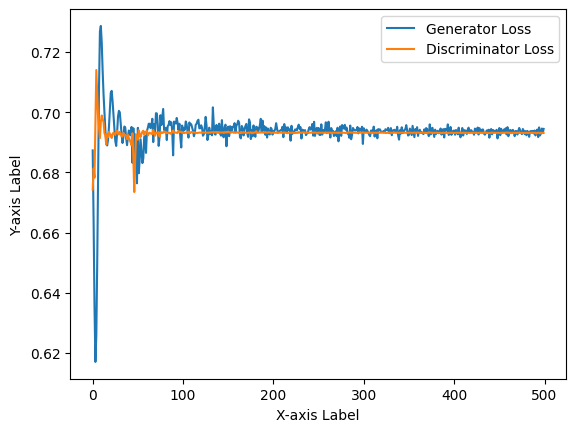

In [19]:
x = np.arange(len(gen_loss))

plt.plot(x, gen_loss, label="Generator Loss")
plt.plot(x, dis_loss, label="Discriminator Loss")

plt.xlabel("X-axis Label")
plt.ylabel("Y-axis Label")
plt.legend()

plt.show()

## Calculate ScaledPE for the entire models

In [20]:
import sys
import os
import importlib
sys.path.append('/.')

import model_eval_git
importlib.reload(model_eval_git)

df_comp_result = model_eval_git.get_the_best_model_cgan(class_NakagamiV2_cgan=NakagamiV2(), target_model_dir=my_short_cut, 
                                                        save_interval=save_interval, Z_dim=cGAN_V2().Z_dim,
                                                        target_df_ideal_mean=df_ideal_mean, target_df_ideal_var=df_ideal_var,
                                                        custom_metric=None, is_noise=con.noise)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 64)                320       
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                                 
 dense_15 (Dense)            (None, 64)                4160      
                                                                 
 dense_16 (Dense)            (None, 64)                4160      
                                                                 
 dense_17 (Dense)            (None, 64)                4160      
                                                                 
 dense_18 (Dense)            (None, 1)                 65        
                                                                 
Total params: 17,025
Trainable params: 17,025
Non-trai

In [21]:
df_comp_result = pd.read_csv(f"{my_short_cut}/info_all_models.csv")
df_comp_result

epoch    mean_avg       var_avg
0        0.0  264.529333  9.996600e+01
1      100.0  598.080000  1.164295e+06
2      200.0   83.599000  7.353966e+03
3      300.0  153.563333  4.683224e+03
4      400.0  495.445667  2.532208e+04
..       ...         ...           ...
496  49600.0   36.758667  5.051733e+01
497  49700.0   37.774333  3.085500e+01
498  49800.0   18.169667  3.746133e+01
499  49900.0    5.938000  3.163733e+01
500  50000.0   41.807333  3.470233e+01

[501 rows x 3 columns]

In [22]:
ratio_mean_avg = 0.3
ratio_var_avg = 1 - ratio_mean_avg
df_comp_result['scaled_weight'] = (df_comp_result['mean_avg']*ratio_mean_avg + df_comp_result['var_avg']*ratio_var_avg)/2

In [23]:
df_comp_result.sort_values(by='mean_avg', ascending=True).head(10)

epoch  mean_avg    var_avg  scaled_weight
264  26400.0  3.552667  41.885333      15.192767
407  40700.0  5.321667  34.147000      12.749700
499  49900.0  5.938000  31.637333      11.963767
398  39800.0  6.183667  34.639333      13.051317
400  40000.0  6.400667  41.377000      15.442050
215  21500.0  6.461333  54.090333      19.900817
440  44000.0  6.561000  34.640000      13.108150
244  24400.0  6.674667  50.461333      18.662667
363  36300.0  6.708667  40.306667      15.113633
276  27600.0  6.929000  43.420333      16.236467

In [24]:
df_comp_result.sort_values(by='var_avg', ascending=True).head(10)

epoch   mean_avg    var_avg  scaled_weight
491  49100.0  27.615000  29.283000      14.391300
480  48000.0  14.313333  29.590333      12.503617
472  47200.0  15.341667  30.099667      12.836133
461  46100.0   9.024667  30.508000      12.031500
486  48600.0  44.129667  30.747000      17.380900
497  49700.0  37.774333  30.855000      16.465400
454  45400.0  27.057000  31.040000      14.922550
453  45300.0  43.129333  31.069000      17.343550
468  46800.0  32.930333  31.074333      15.815567
455  45500.0  11.953667  31.096667      12.676883

In [25]:
df_comp_result.sort_values(by='scaled_weight', ascending=True).head(10)

epoch   mean_avg    var_avg  scaled_weight
499  49900.0   5.938000  31.637333      11.963767
461  46100.0   9.024667  30.508000      12.031500
480  48000.0  14.313333  29.590333      12.503617
455  45500.0  11.953667  31.096667      12.676883
407  40700.0   5.321667  34.147000      12.749700
472  47200.0  15.341667  30.099667      12.836133
398  39800.0   6.183667  34.639333      13.051317
440  44000.0   6.561000  34.640000      13.108150
456  45600.0   8.937667  33.700000      13.135650
489  48900.0  16.470667  31.443000      13.475650

## Evaluation

### Generated Data

In [26]:
gen = tf.keras.models.load_model(f'{my_short_cut}/gen/generator_49900.h5')

In [27]:
data_size = 100000
nakagami_signal, nakagami_condition, nagakami_indices = con.generate(data_size)

batch_size = 32
Z_dim = 16
Z = np.random.normal(0, 1, size=(data_size, Z_dim))
nagakami_indices = tf.cast(nagakami_indices, tf.float32)

In [28]:
conditional_distribution_index_value = model_eval_git.get_conditional_distribution_index_value_cgan(gen, Z, nakagami_condition, nagakami_indices)

 146/3125 [>.............................] - ETA: 3s

2023-12-10 01:00:14.503127: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3125/3125 [==============================] - 4s 1ms/step


In [29]:
df_generated_log_scaled_eval = pd.DataFrame(conditional_distribution_index_value.numpy(), columns=['data', 'd', 'r'])
df_generated_log_scaled_eval.head()

data     d         r
0  0.878998  29.0  0.705379
1  1.061947   7.0  0.033974
2  1.411548   4.0  0.097116
3  1.228774  13.0  0.742666
4  0.978211  18.0  0.631450

In [30]:
### Genuine Data

In [31]:
df_genuine_eval = pd.DataFrame(np.concatenate((nakagami_signal, nagakami_indices, np.expand_dims(nakagami_condition[:, 1],axis=1)), axis=1) , columns=['data', 'd', 'r'])
df_genuine_eval

data     d         r
0      0.278984  29.0  0.705379
1      0.459803   7.0  0.033974
2      2.147238   4.0  0.097116
3      1.390473  13.0  0.742666
4      0.568106  18.0  0.631450
...         ...   ...       ...
99995  3.643518   4.0  0.222645
99996  0.034627  19.0  0.065192
99997  0.107059  28.0  0.354816
99998  2.024563   8.0  0.473878
99999  0.158305  25.0  0.405985

[100000 rows x 3 columns]

### Genuine vs Generated Comparison - with log scaled

In [32]:
nakagami_signal_log_transformed = log_transformer.fit_transform(nakagami_signal)

In [33]:
df_genuine_log_scaled_eval = pd.DataFrame(np.hstack((nakagami_signal_log_transformed, nagakami_indices)), columns=['data', 'd'])

In [34]:
df_genuine_log_scaled_eval

data     d
0      0.823730  29.0
1      0.900081   7.0
2      1.422442   4.0
3      1.220969  13.0
4      0.943168  18.0
...         ...   ...
99995  1.730508   4.0
99996  0.710313  19.0
99997  0.745293  28.0
99998  1.392416   8.0
99999  0.769323  25.0

[100000 rows x 2 columns]

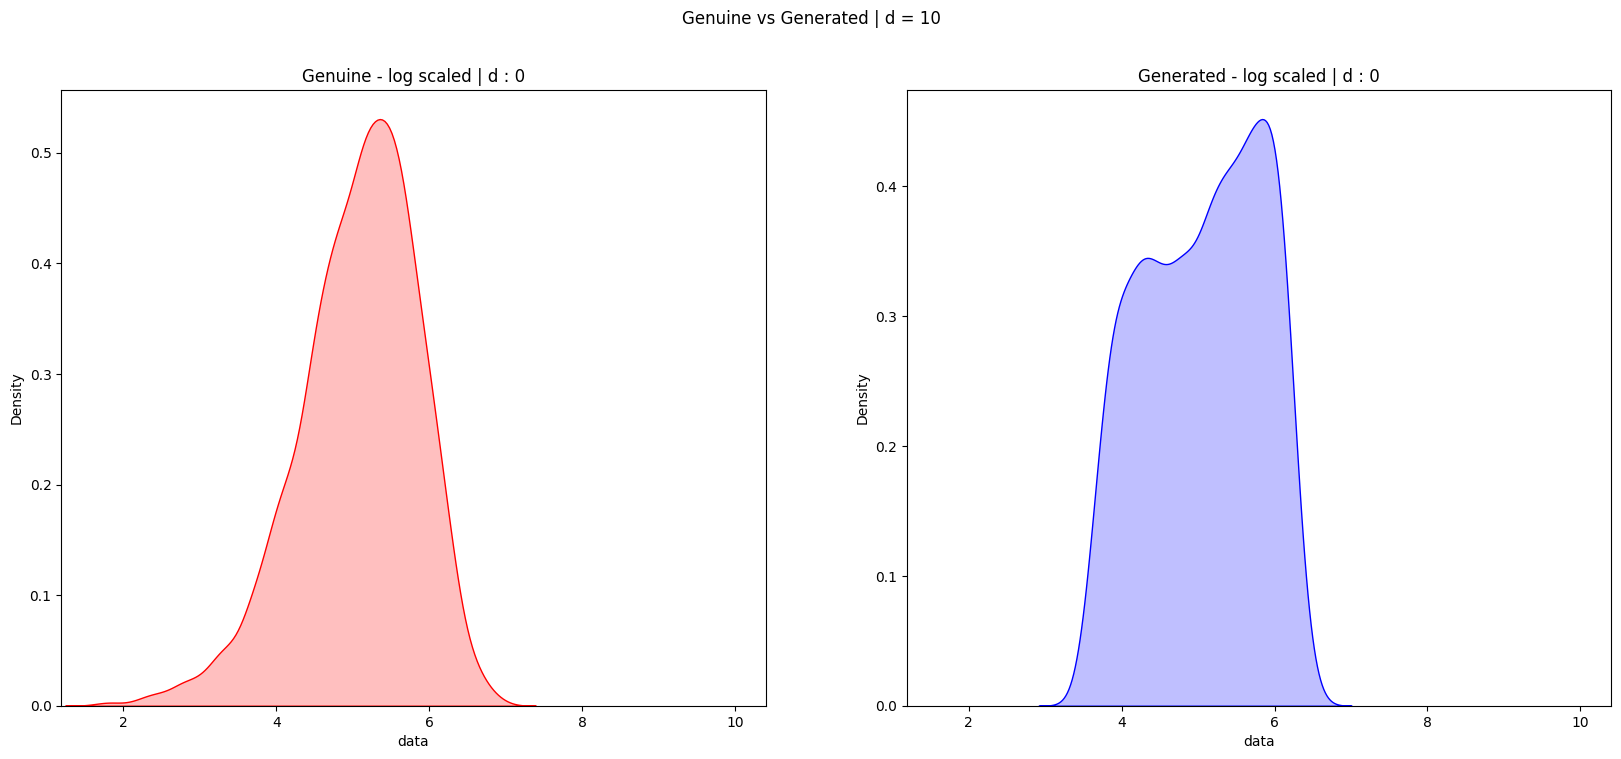

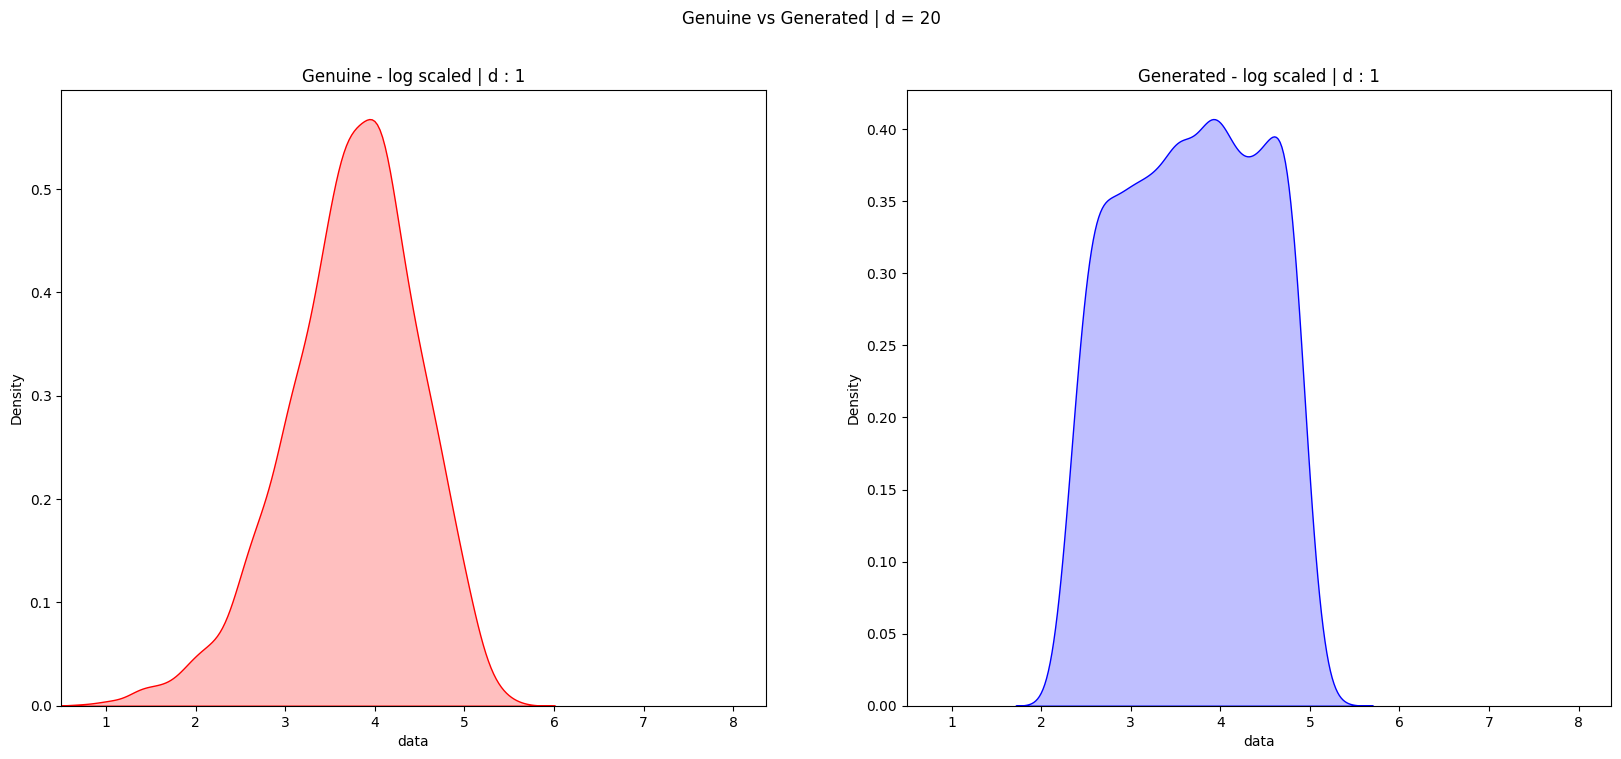

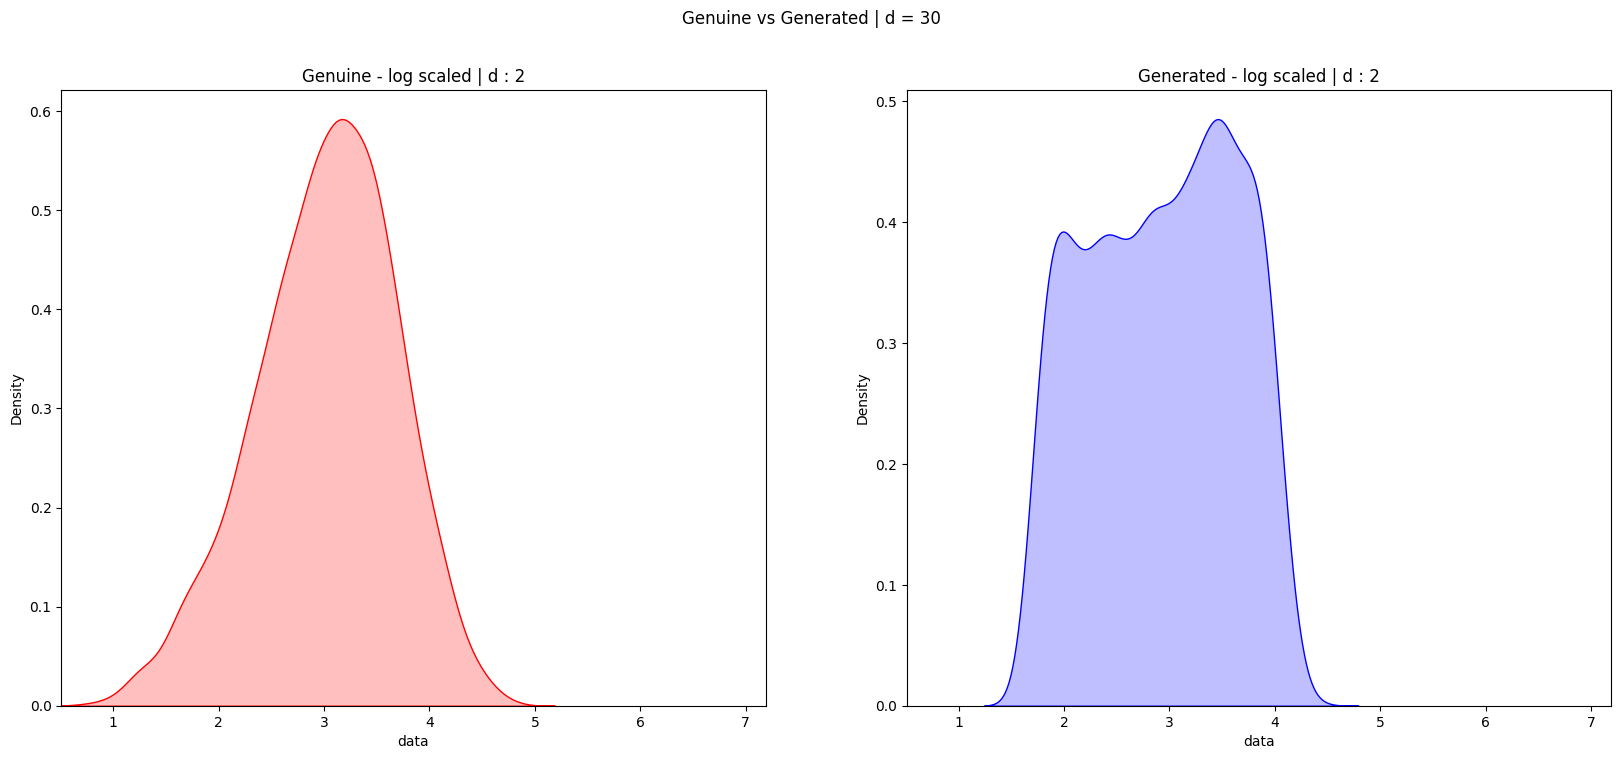

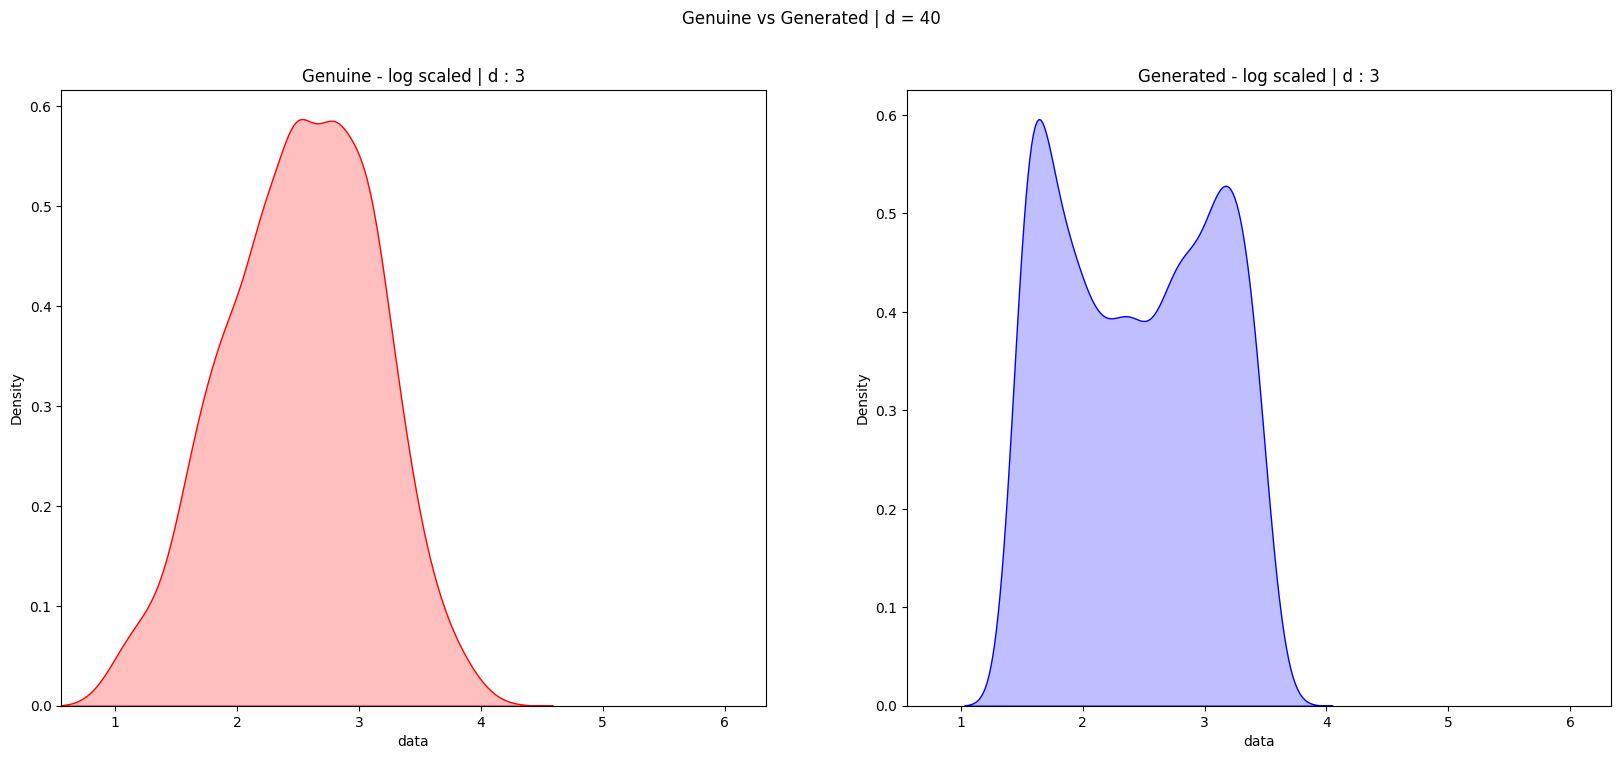

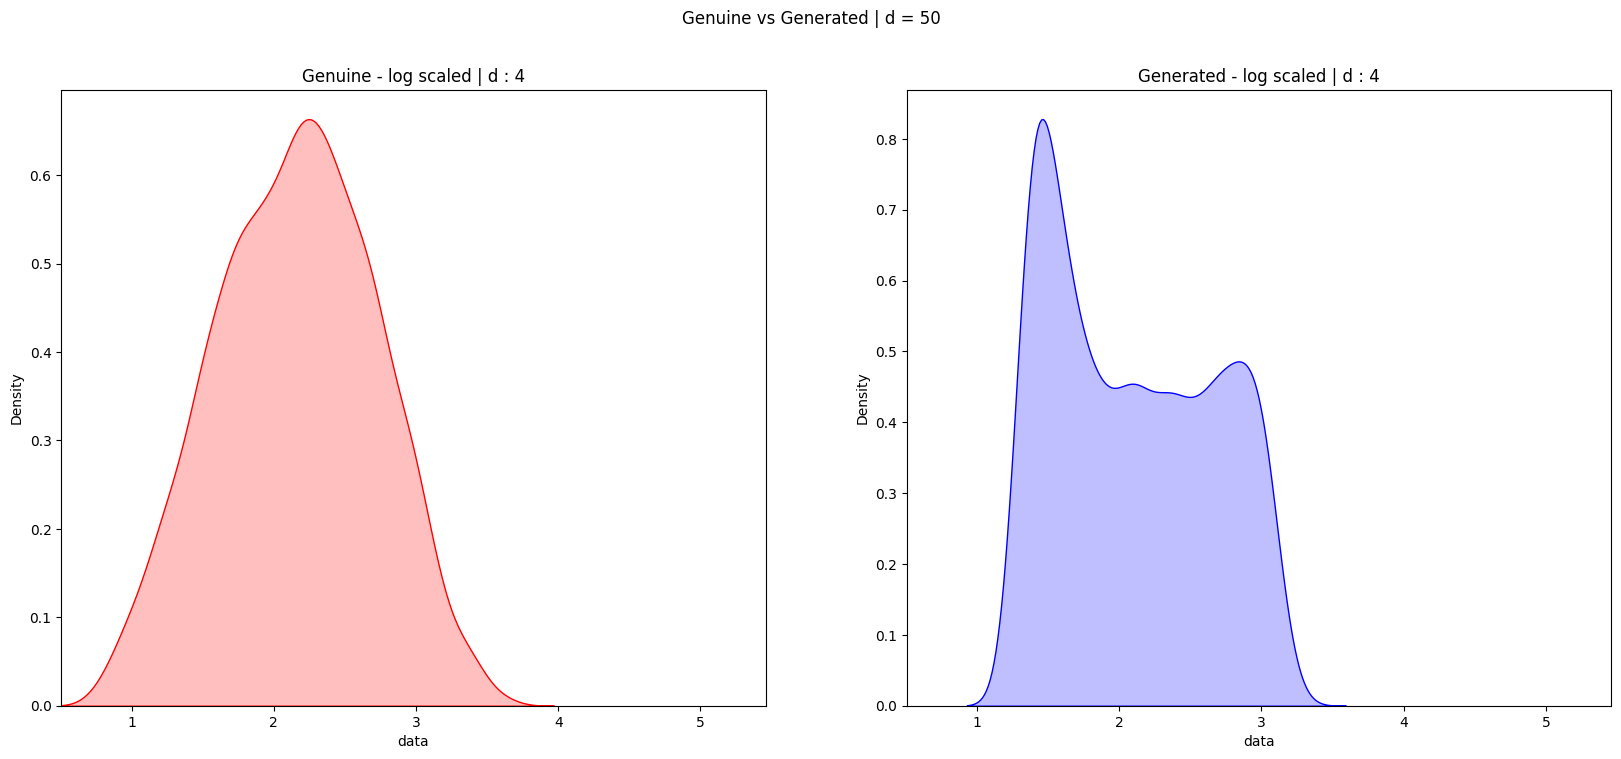

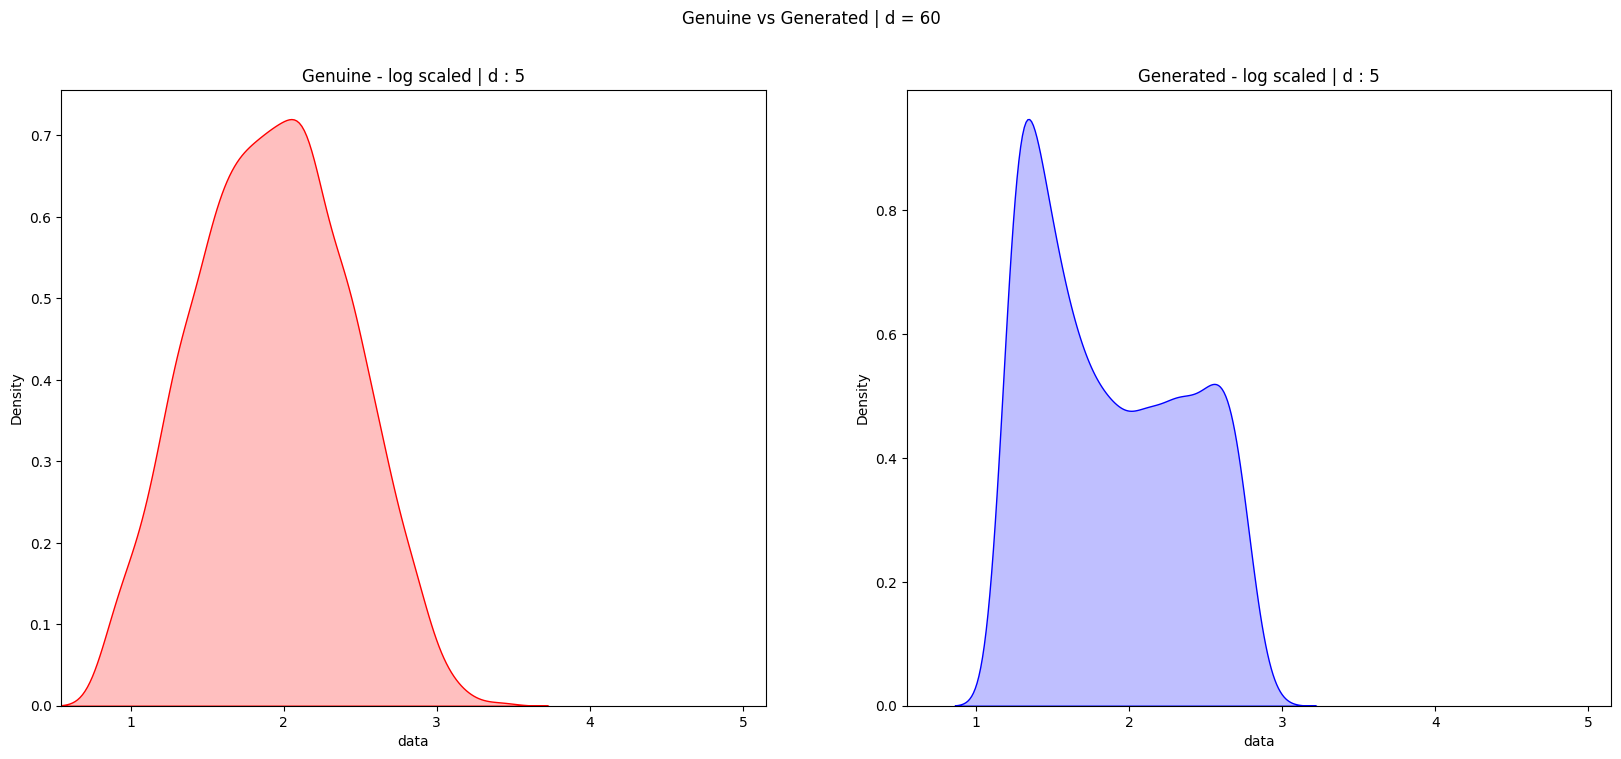

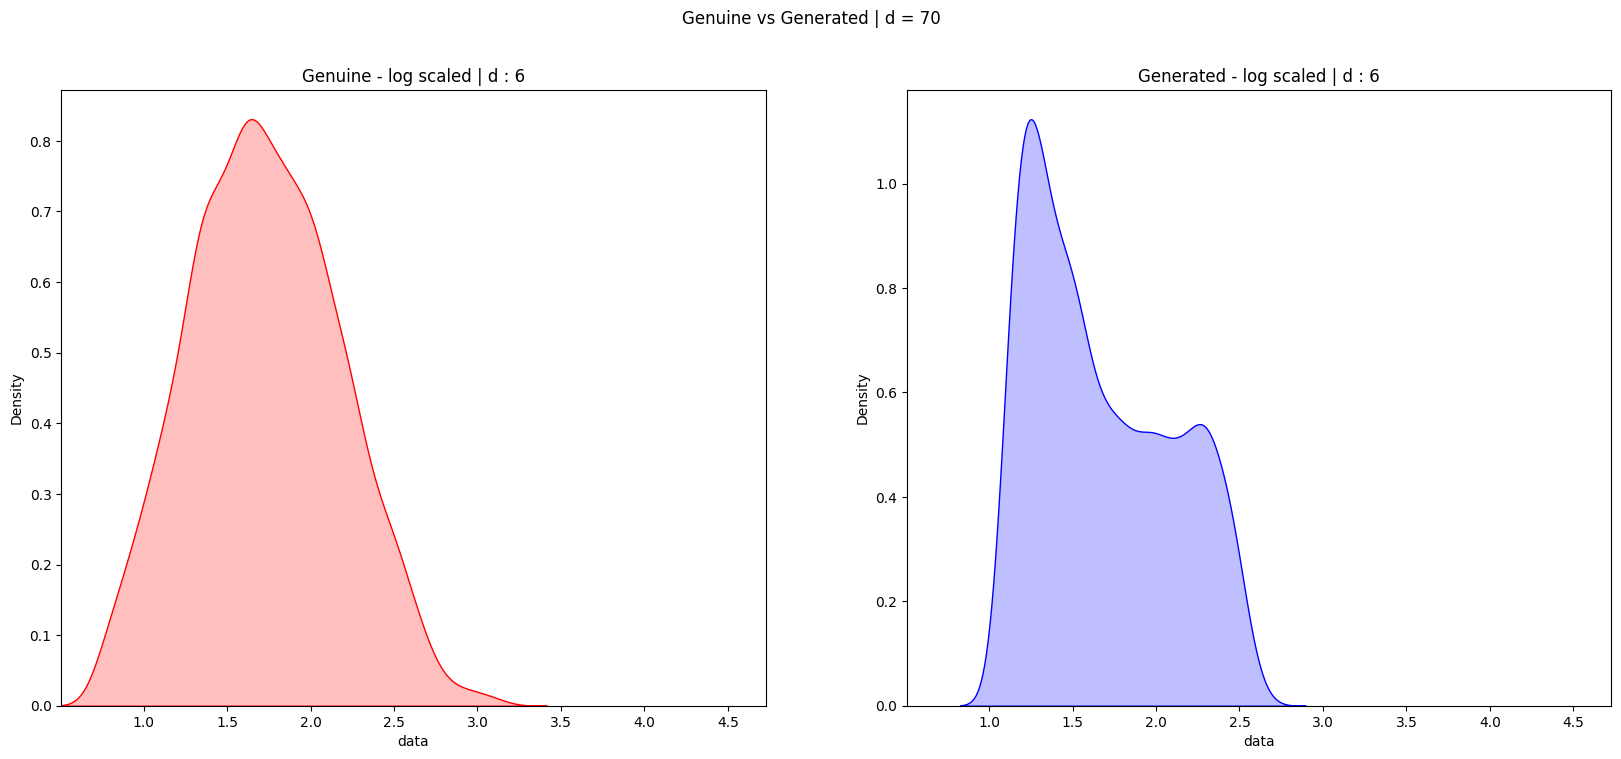

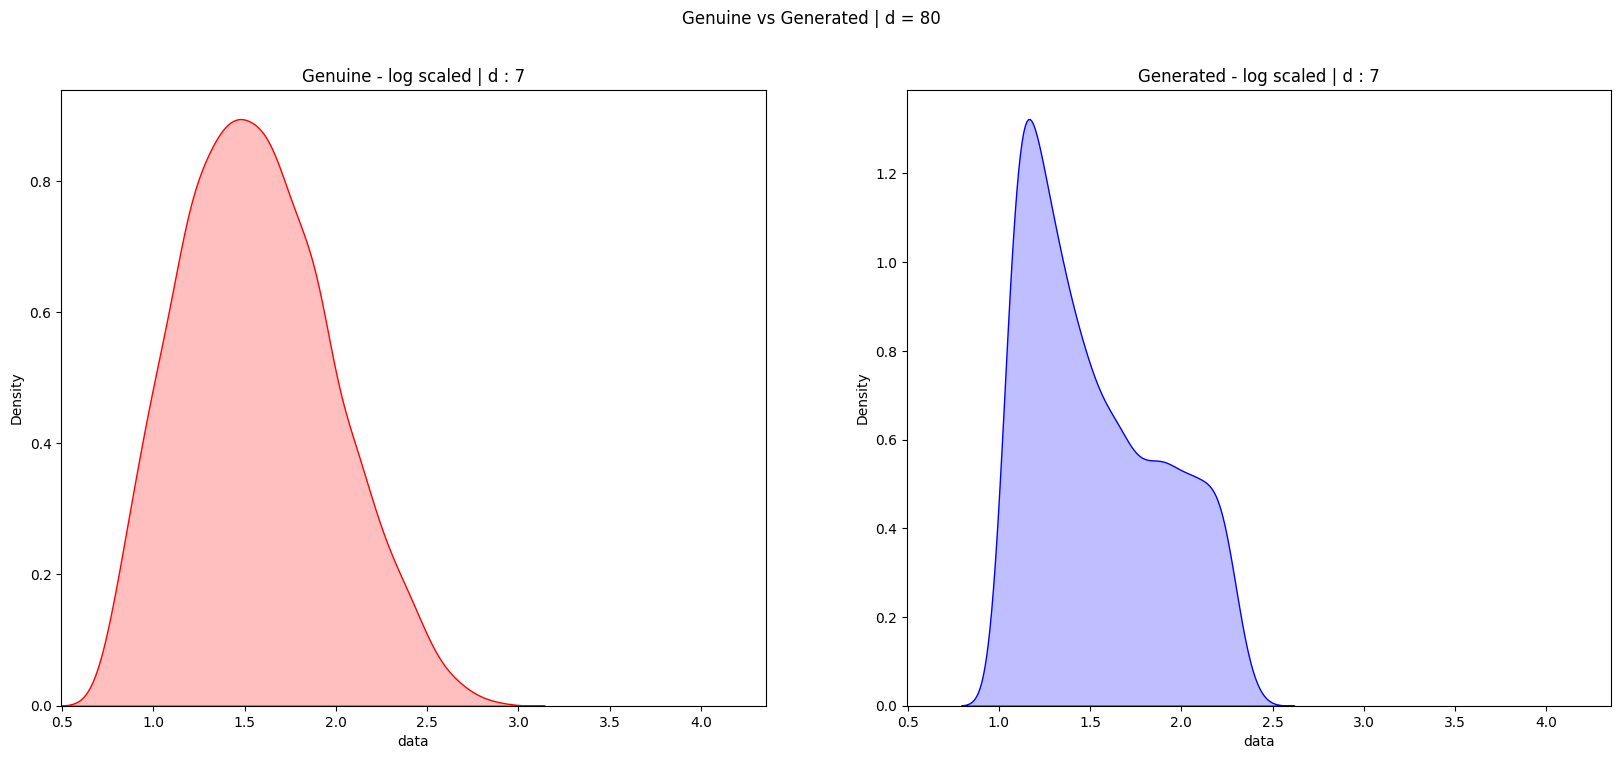

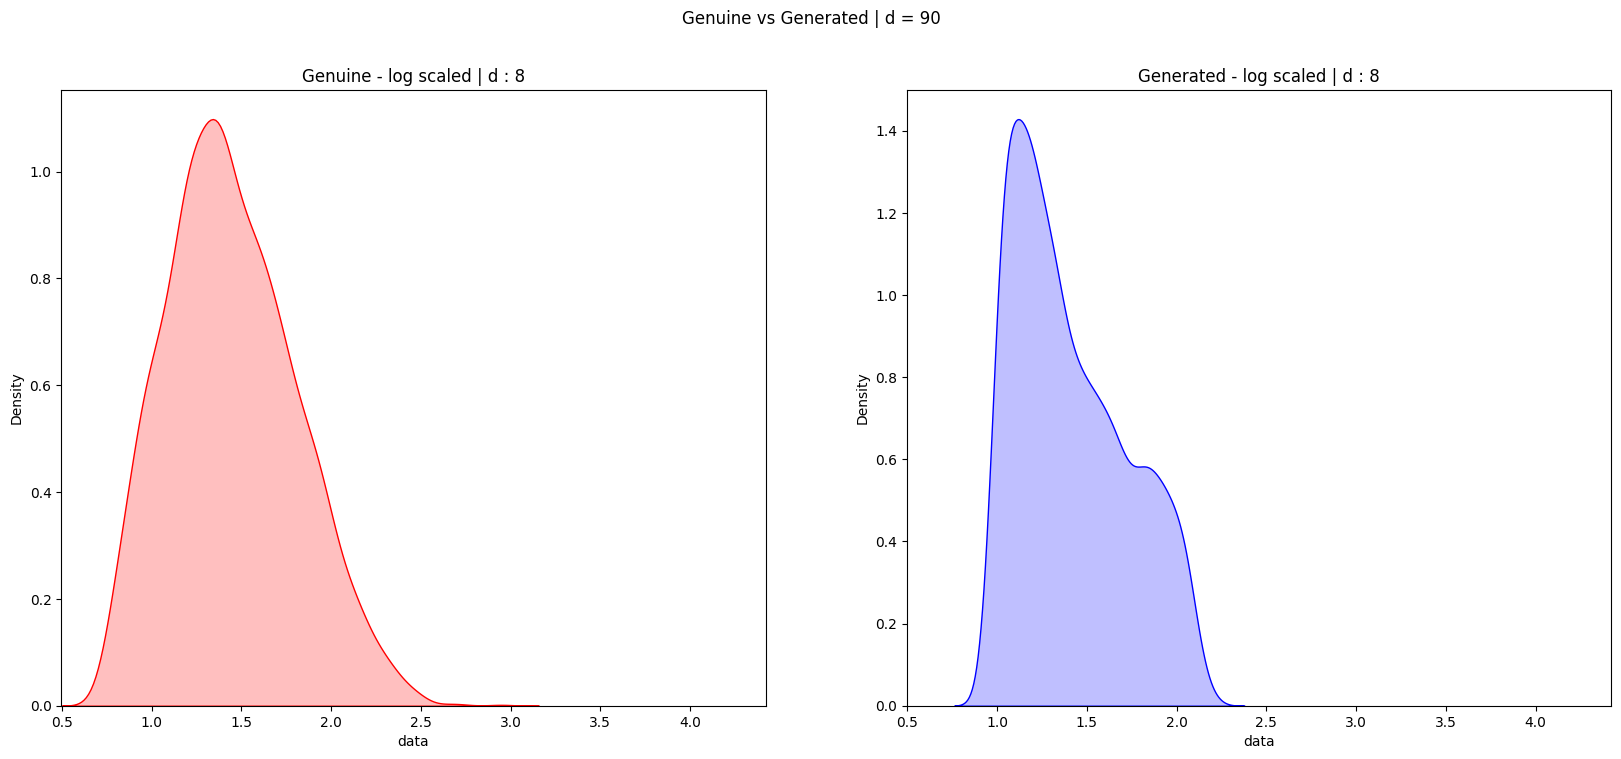

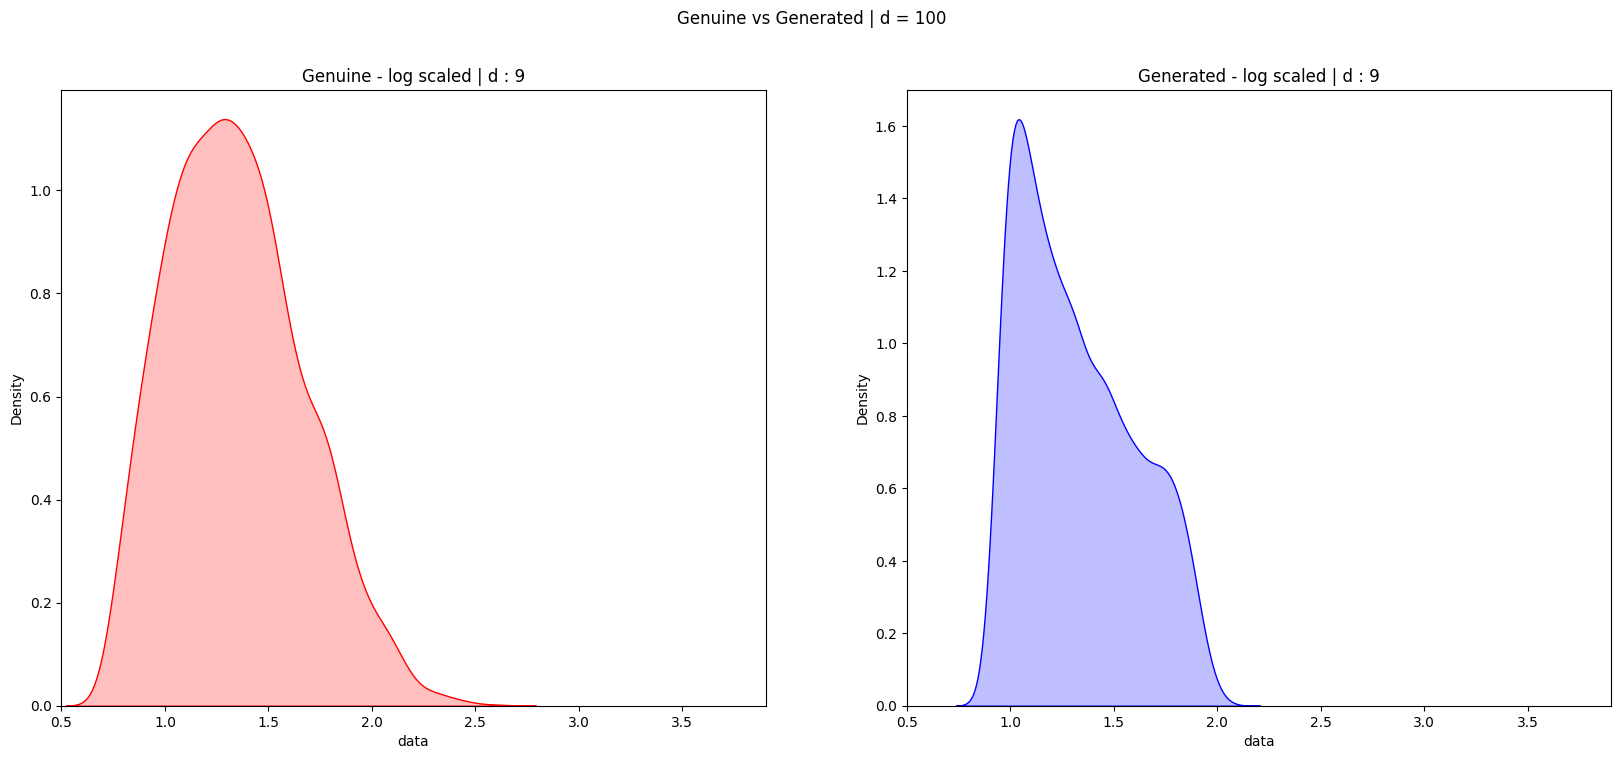

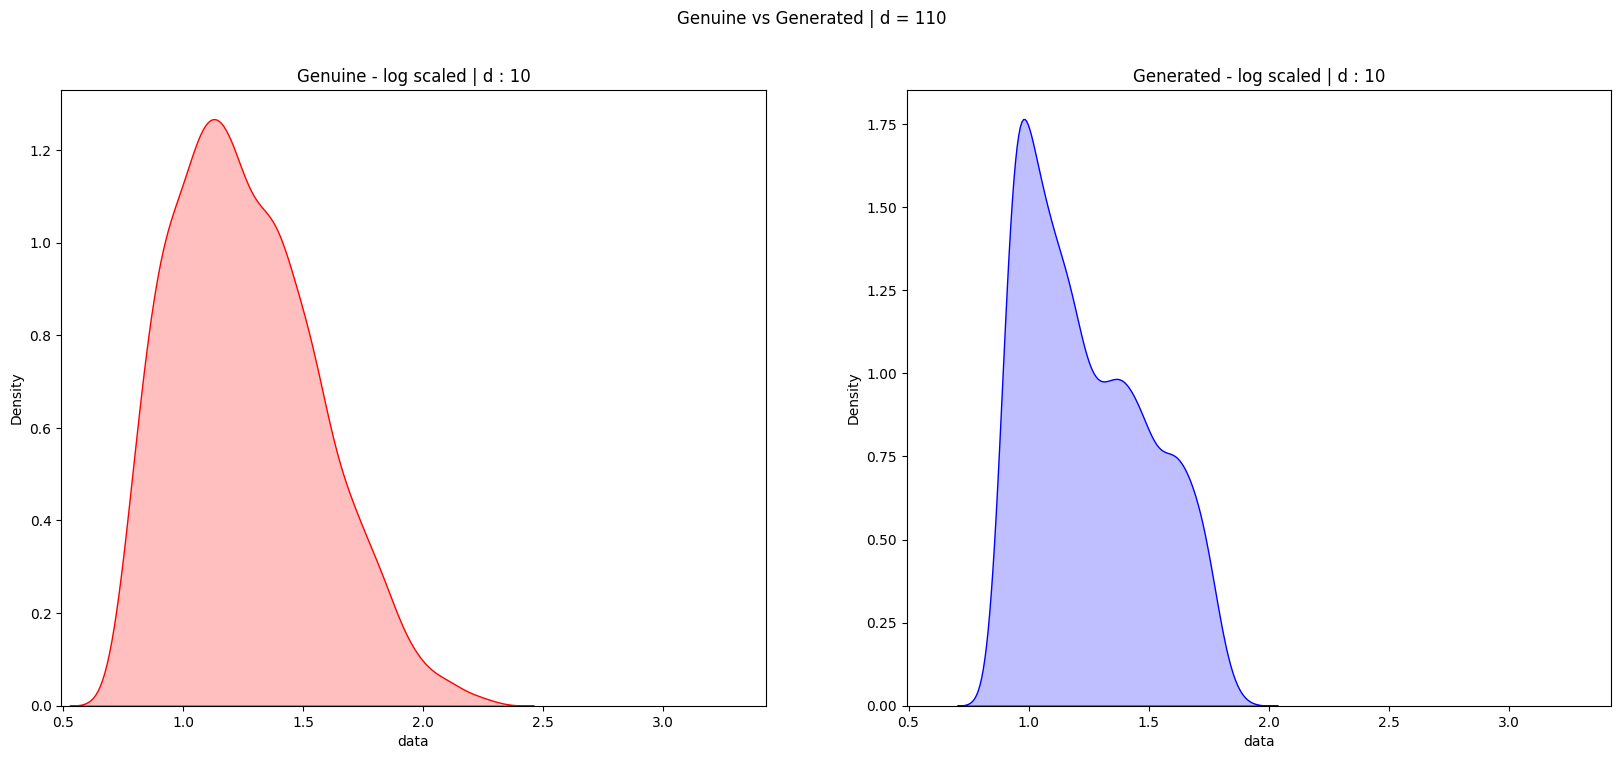

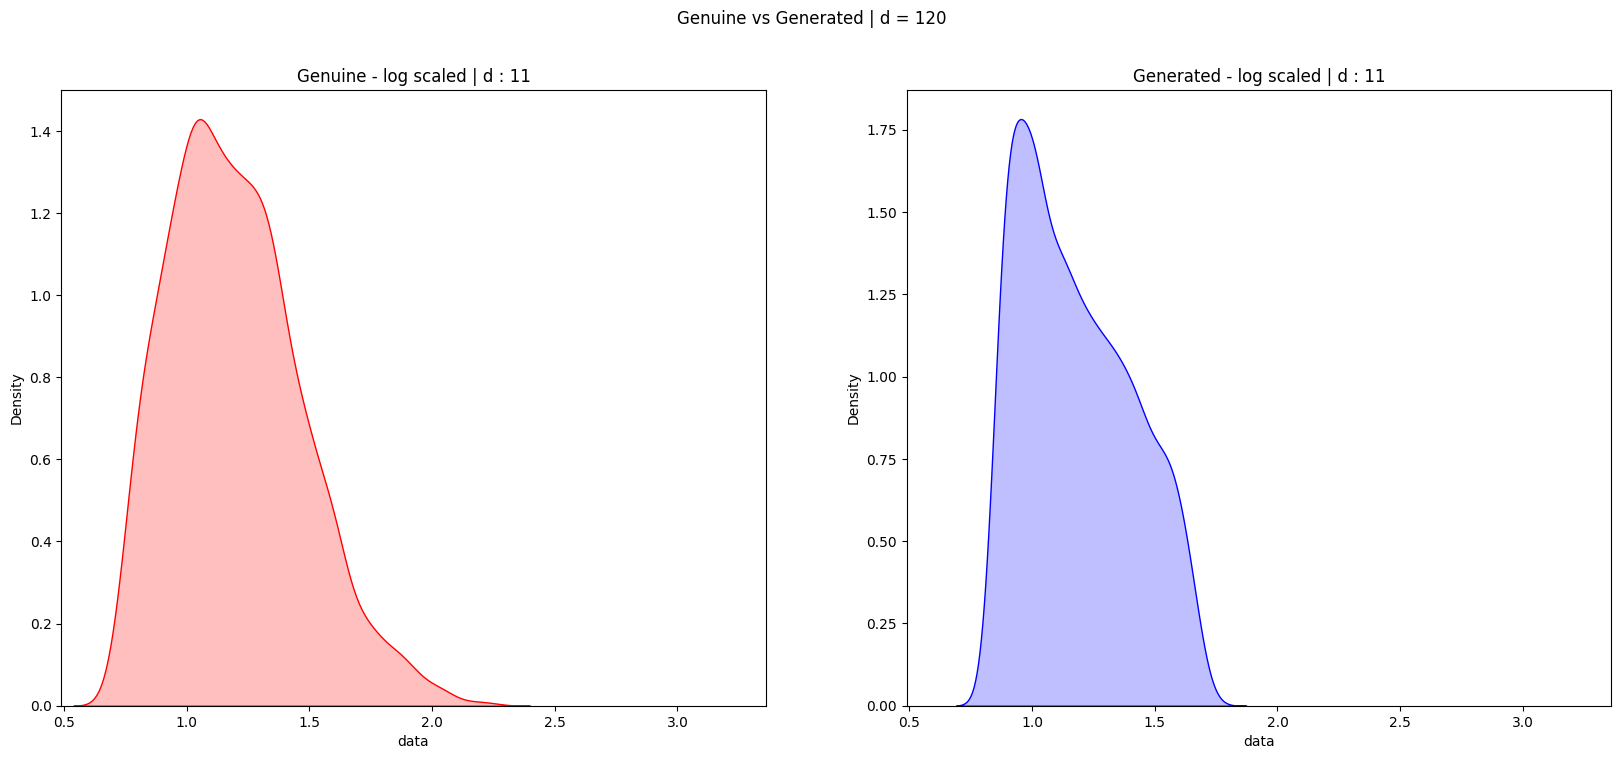

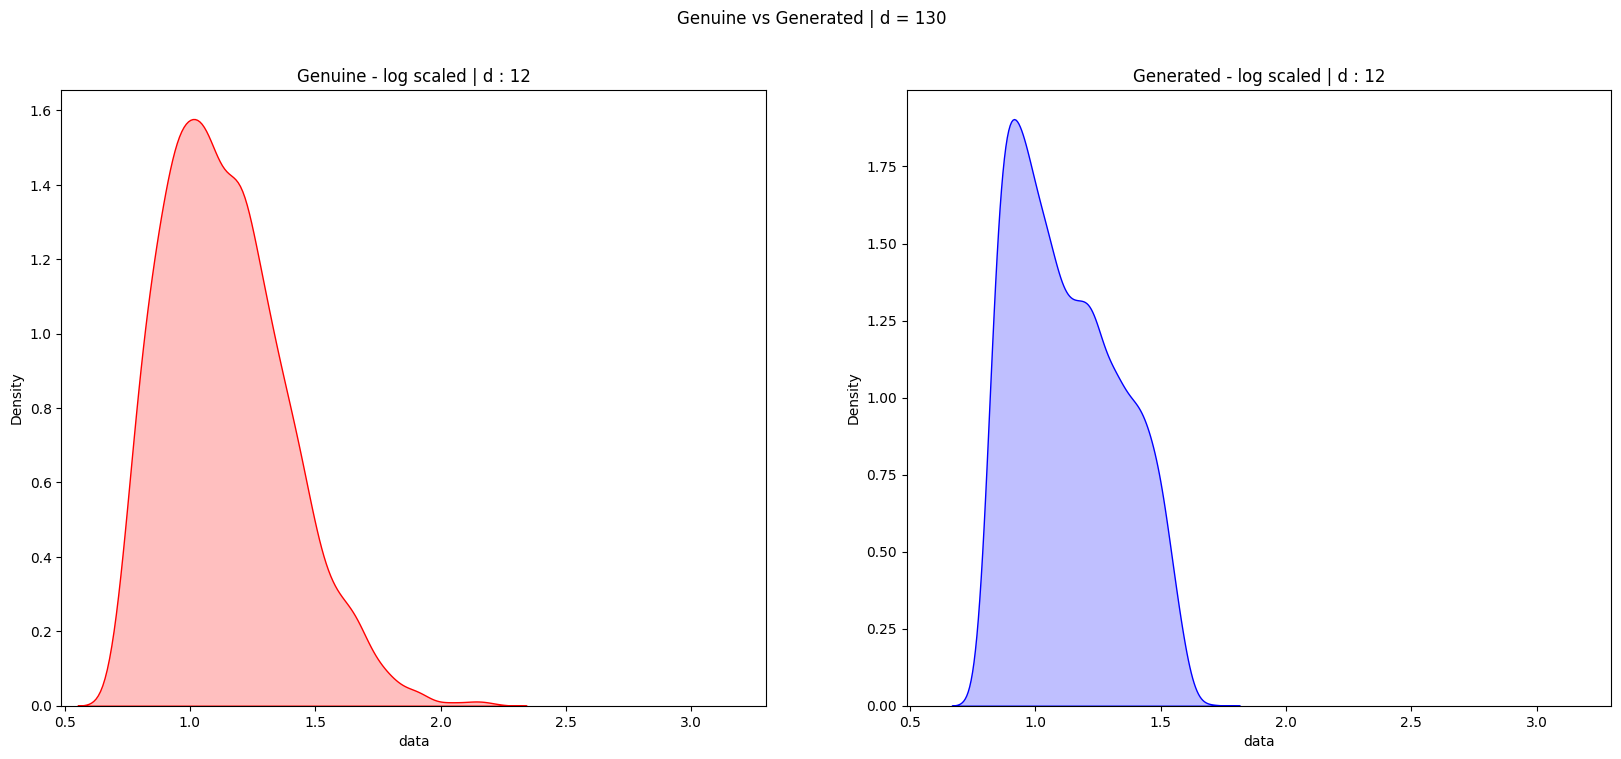

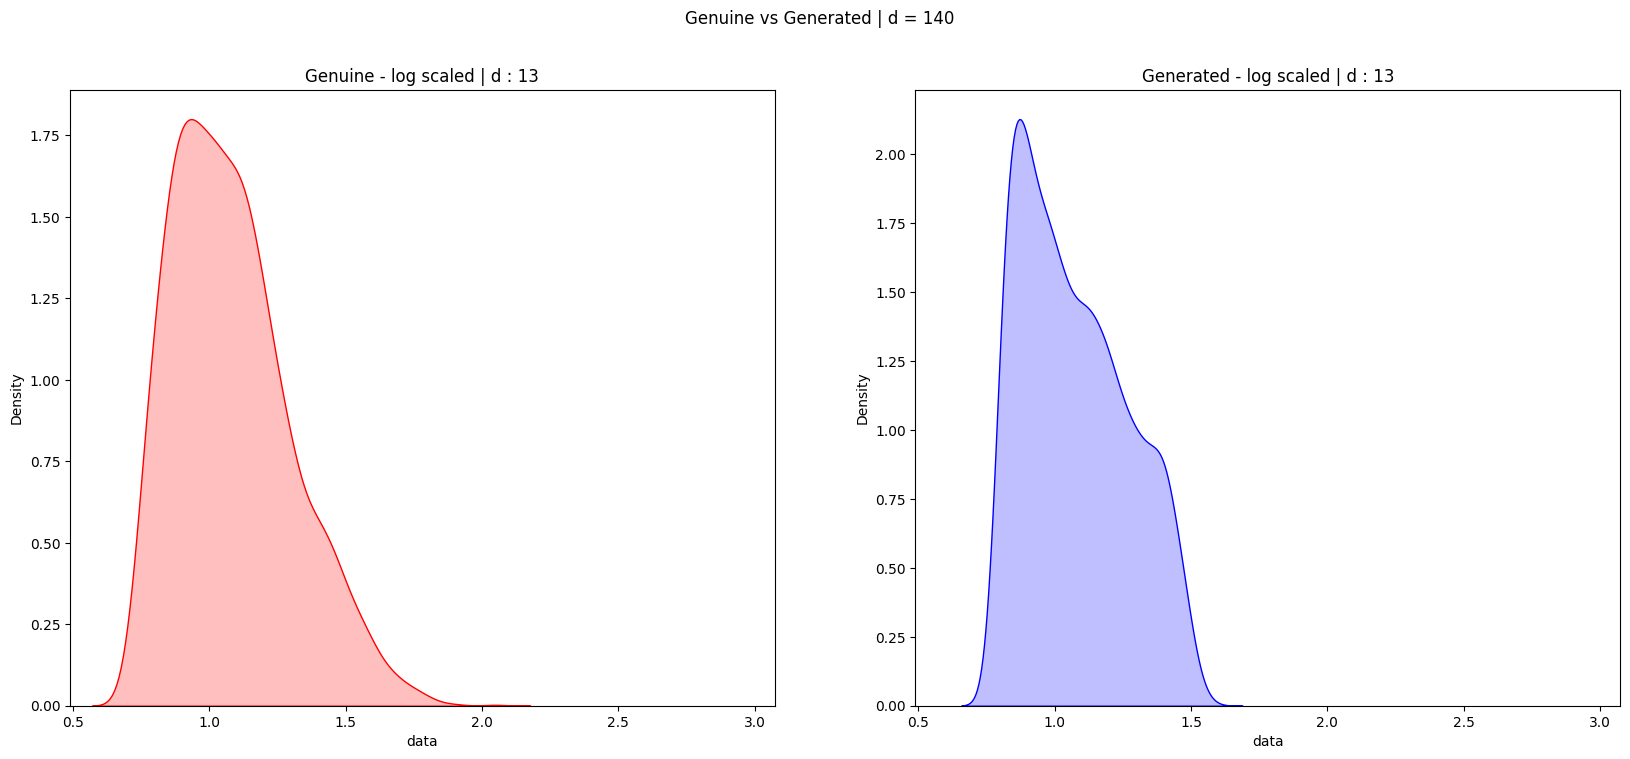

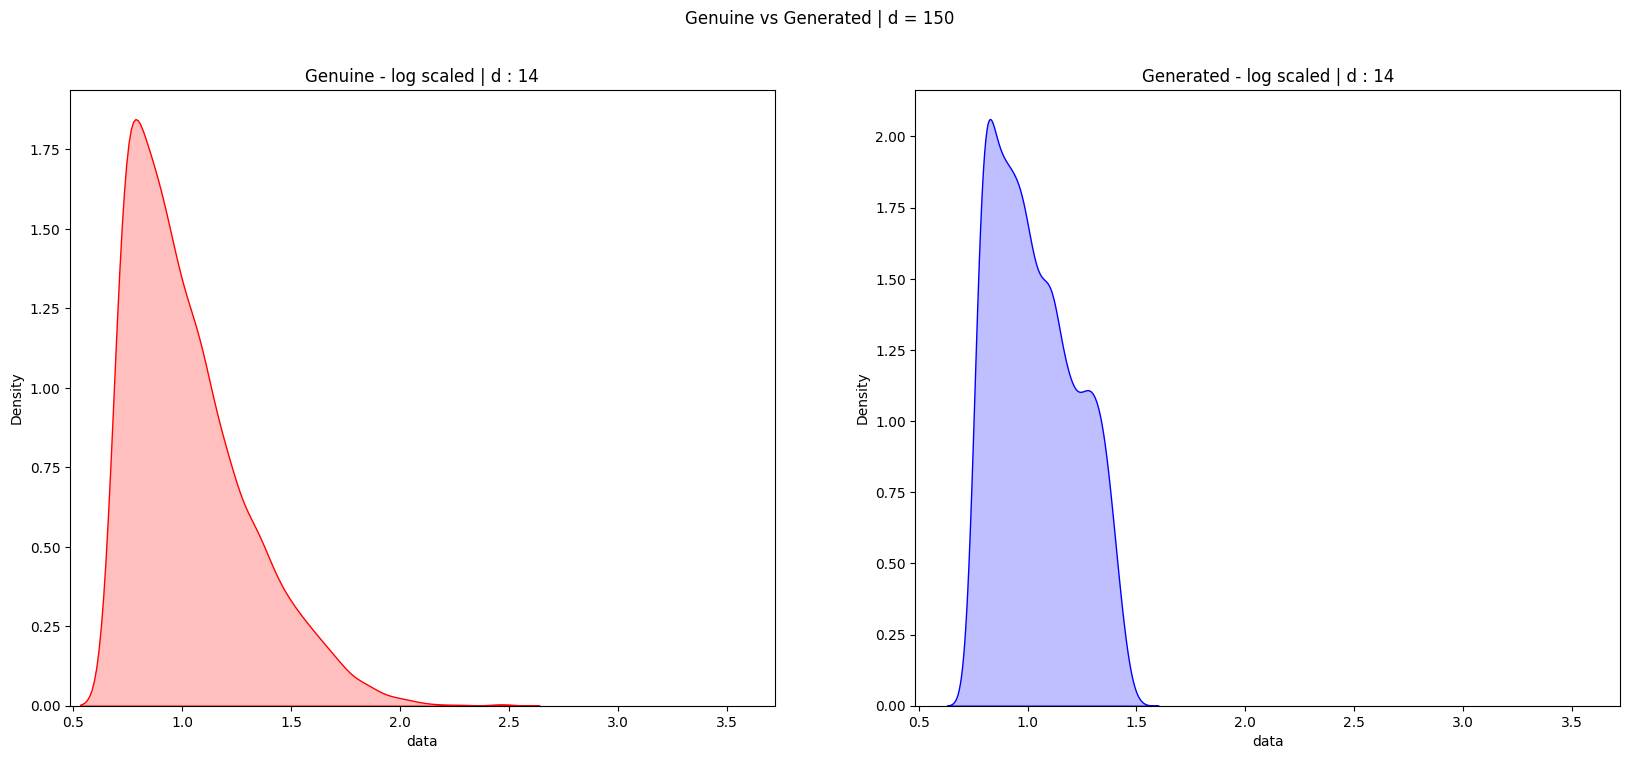

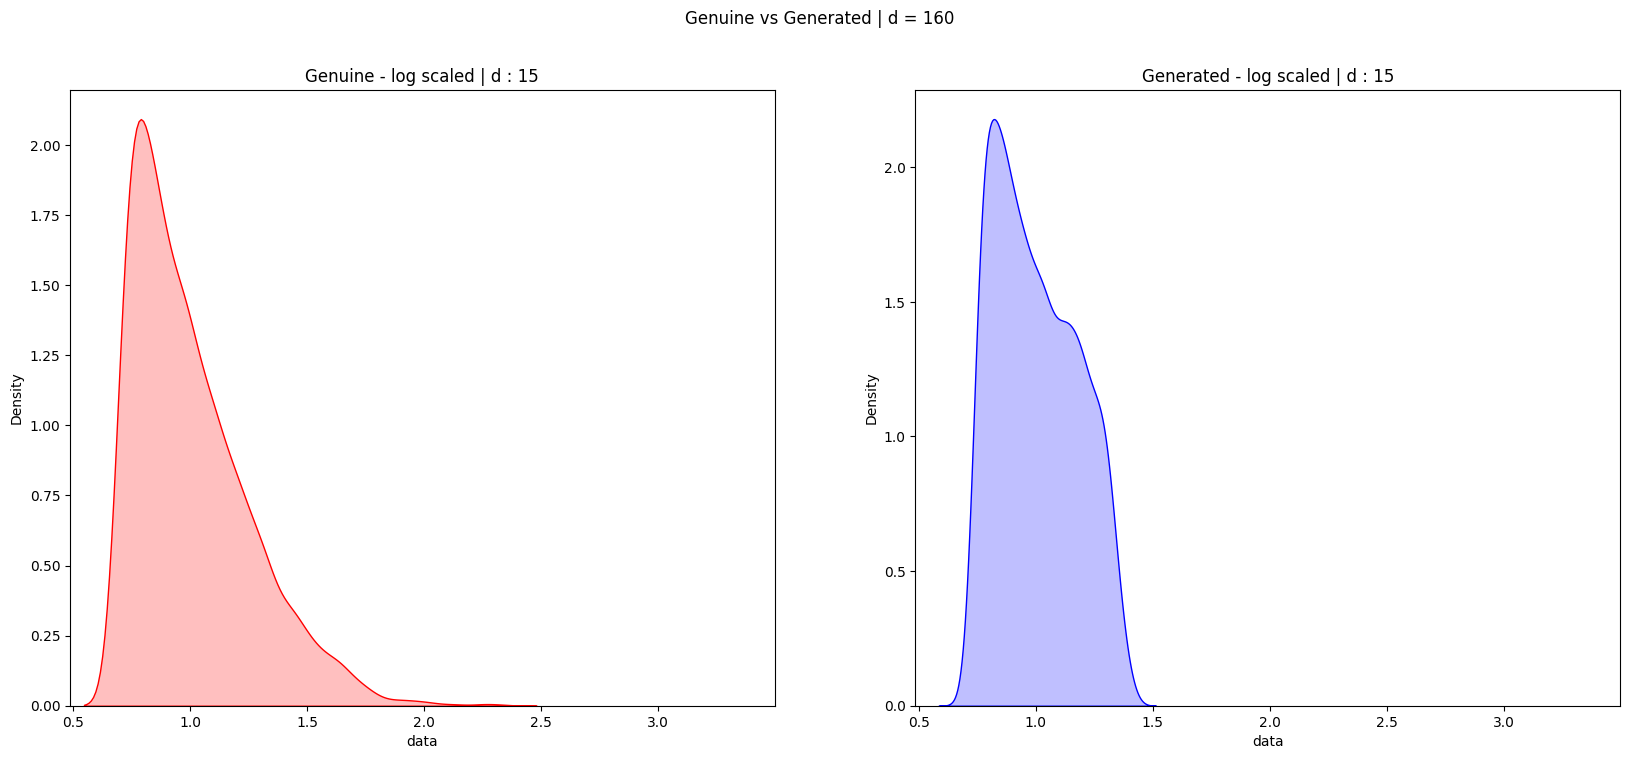

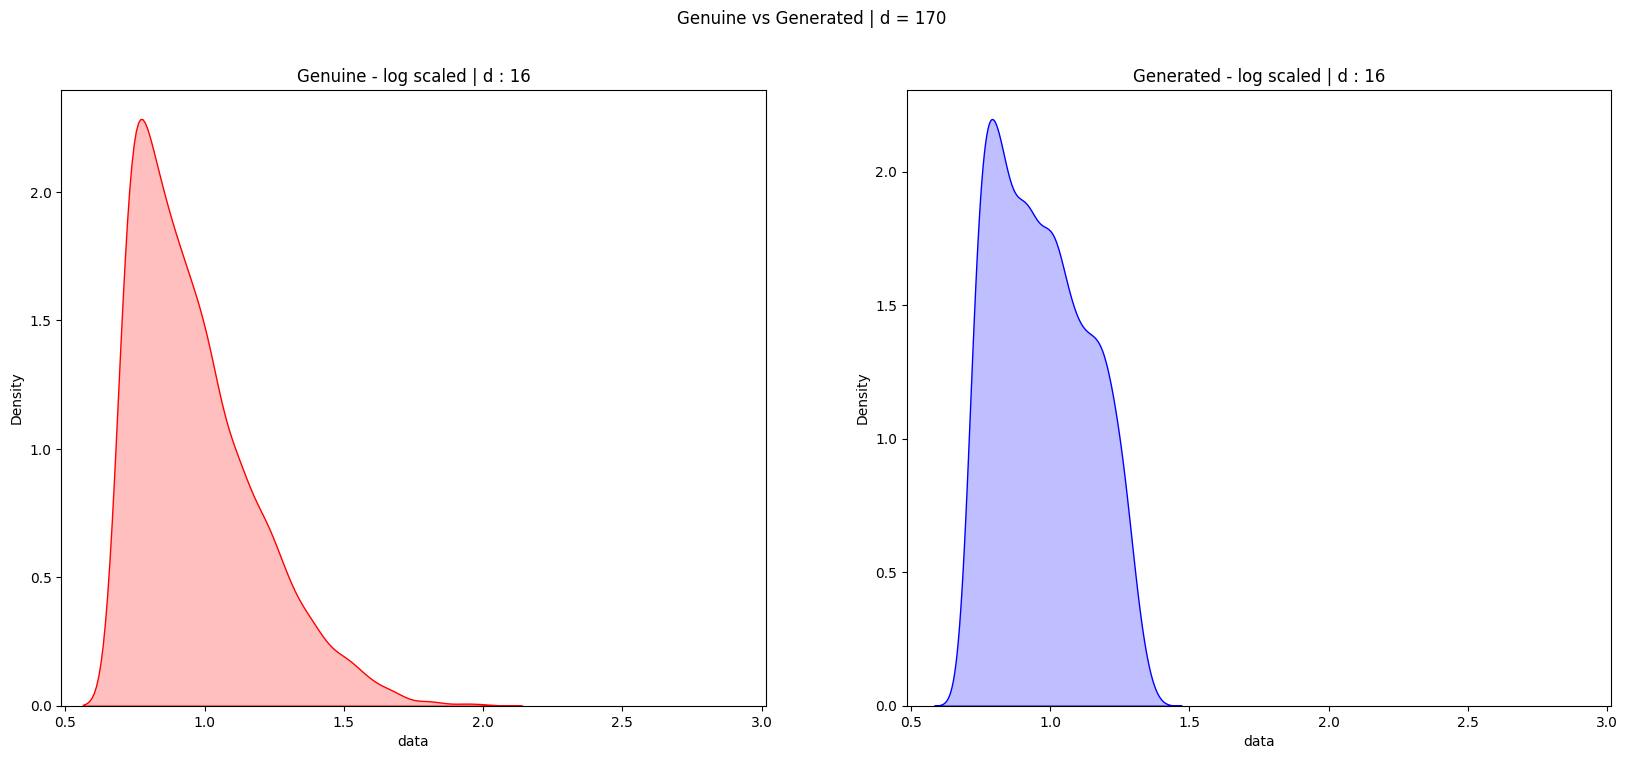

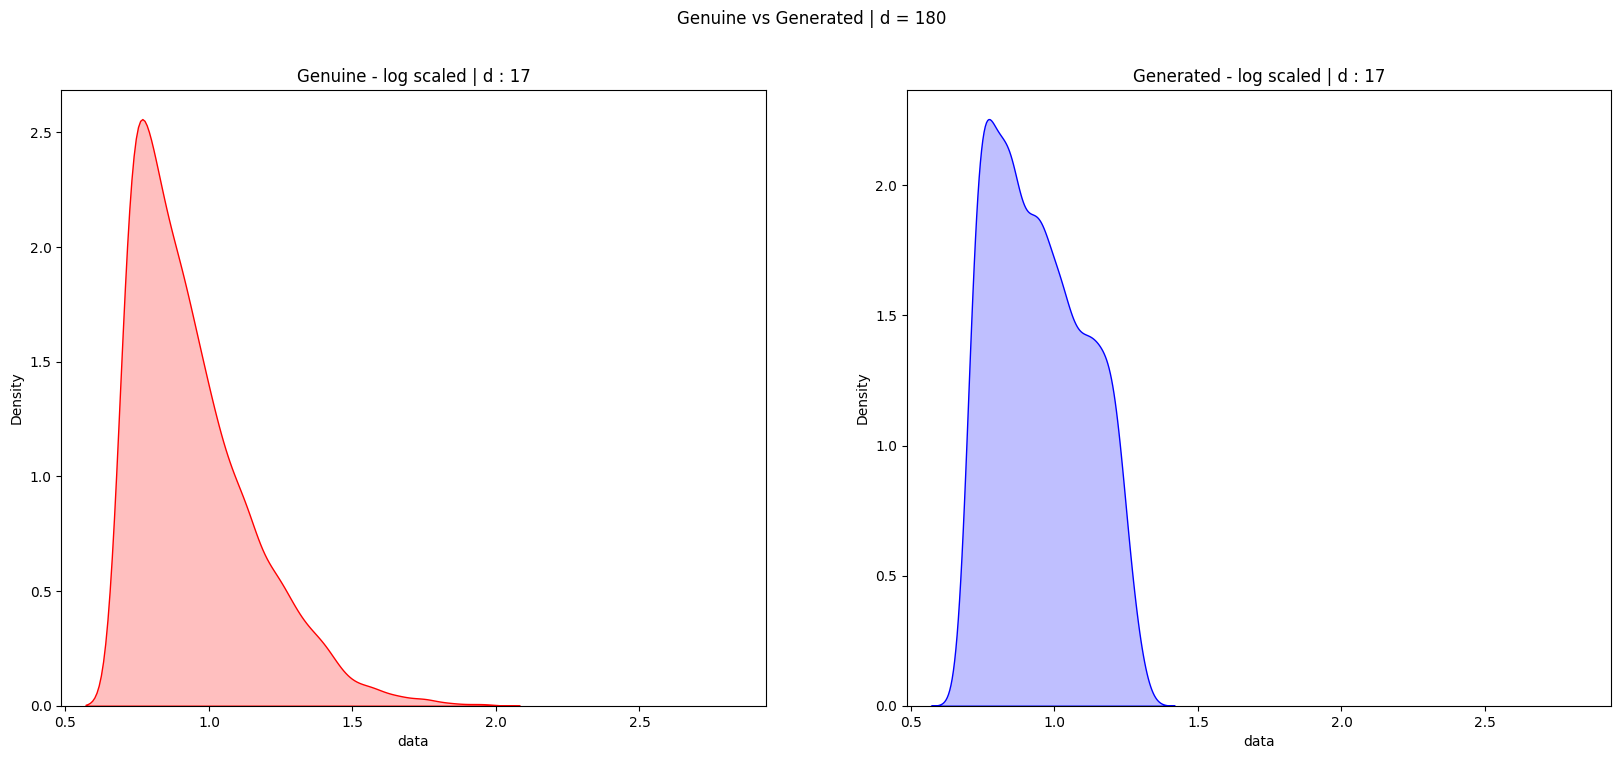

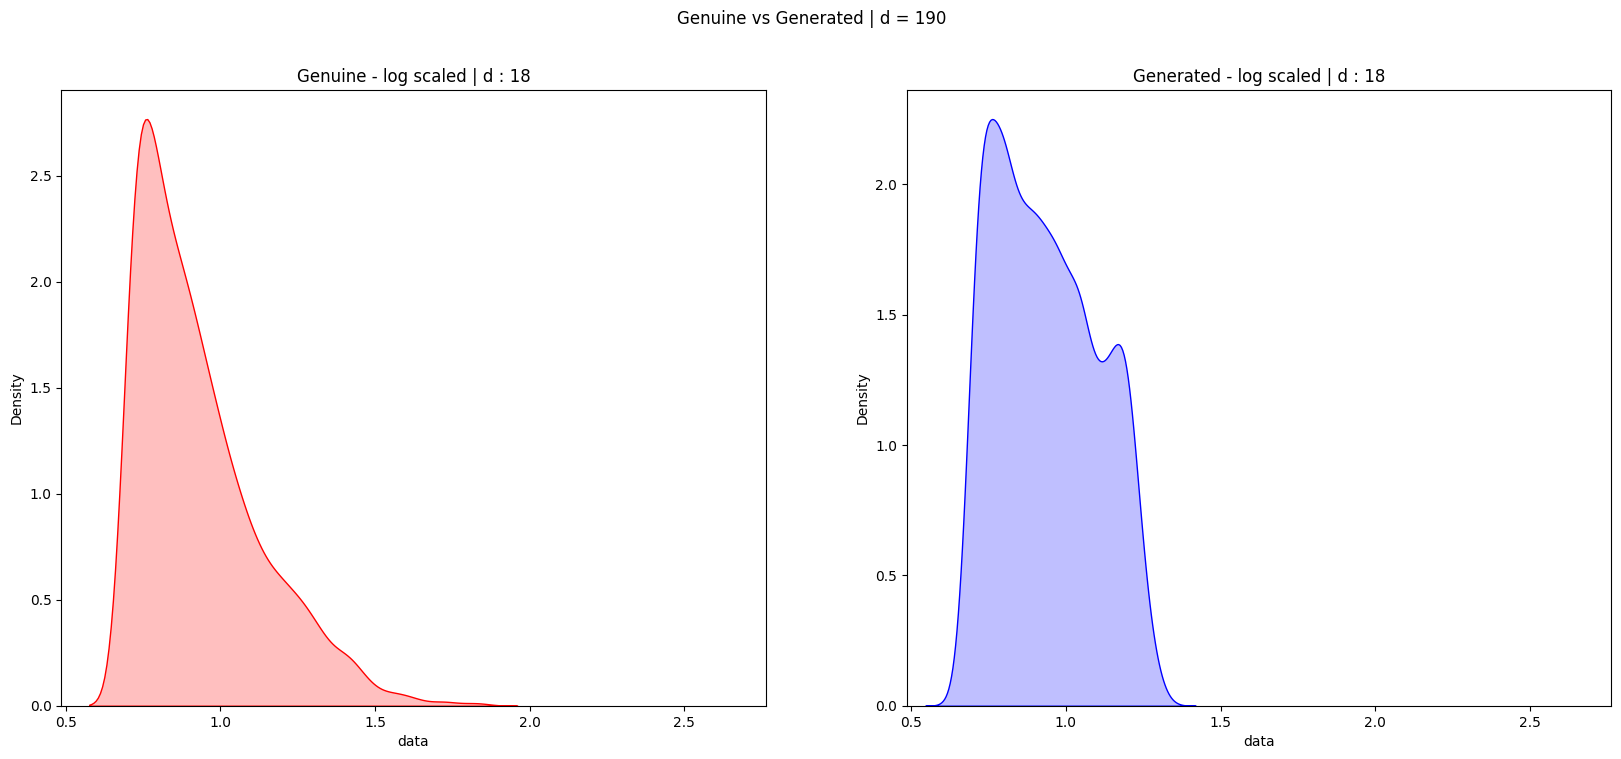

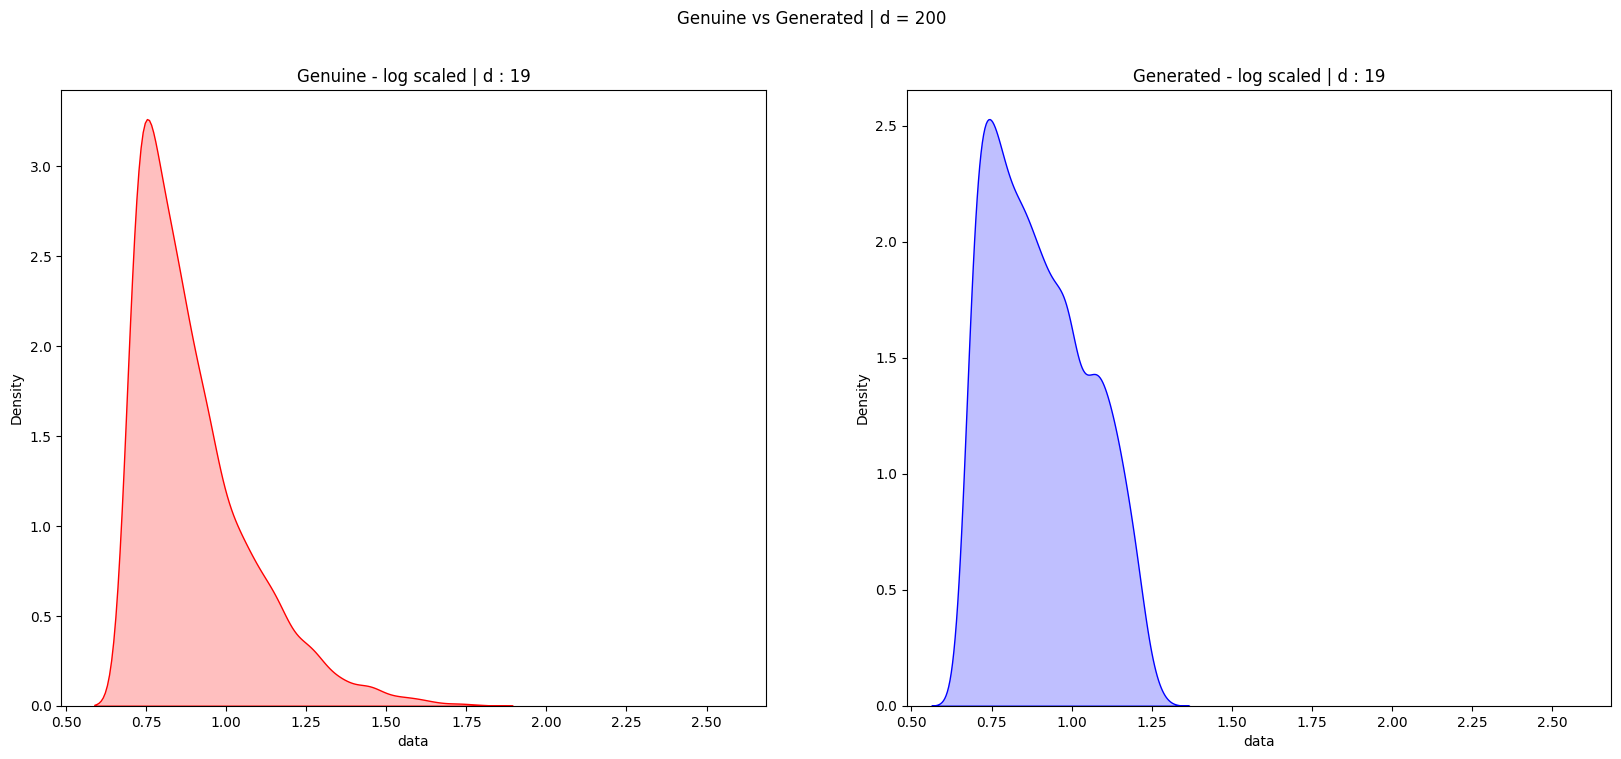

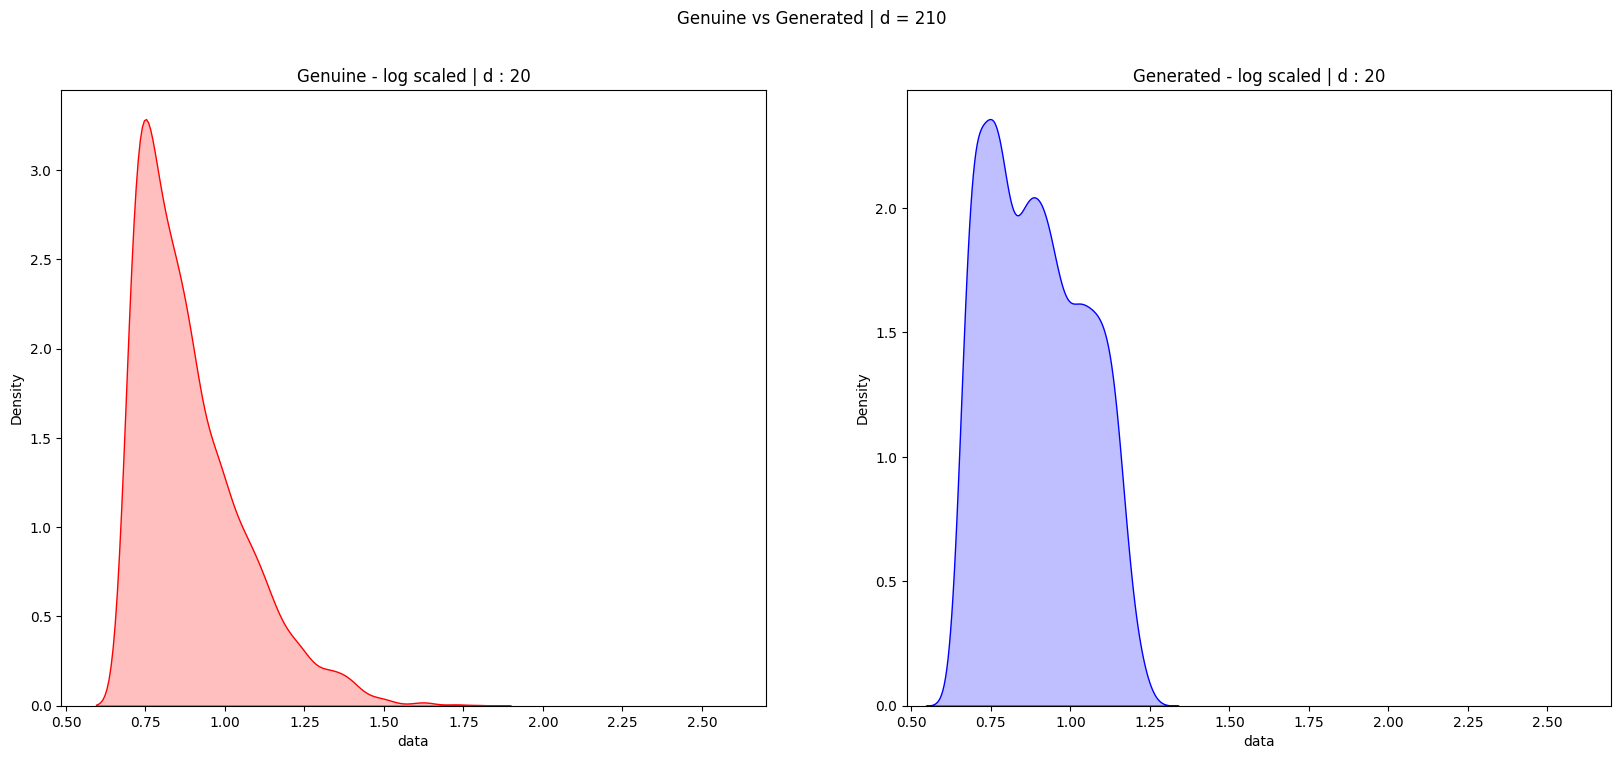

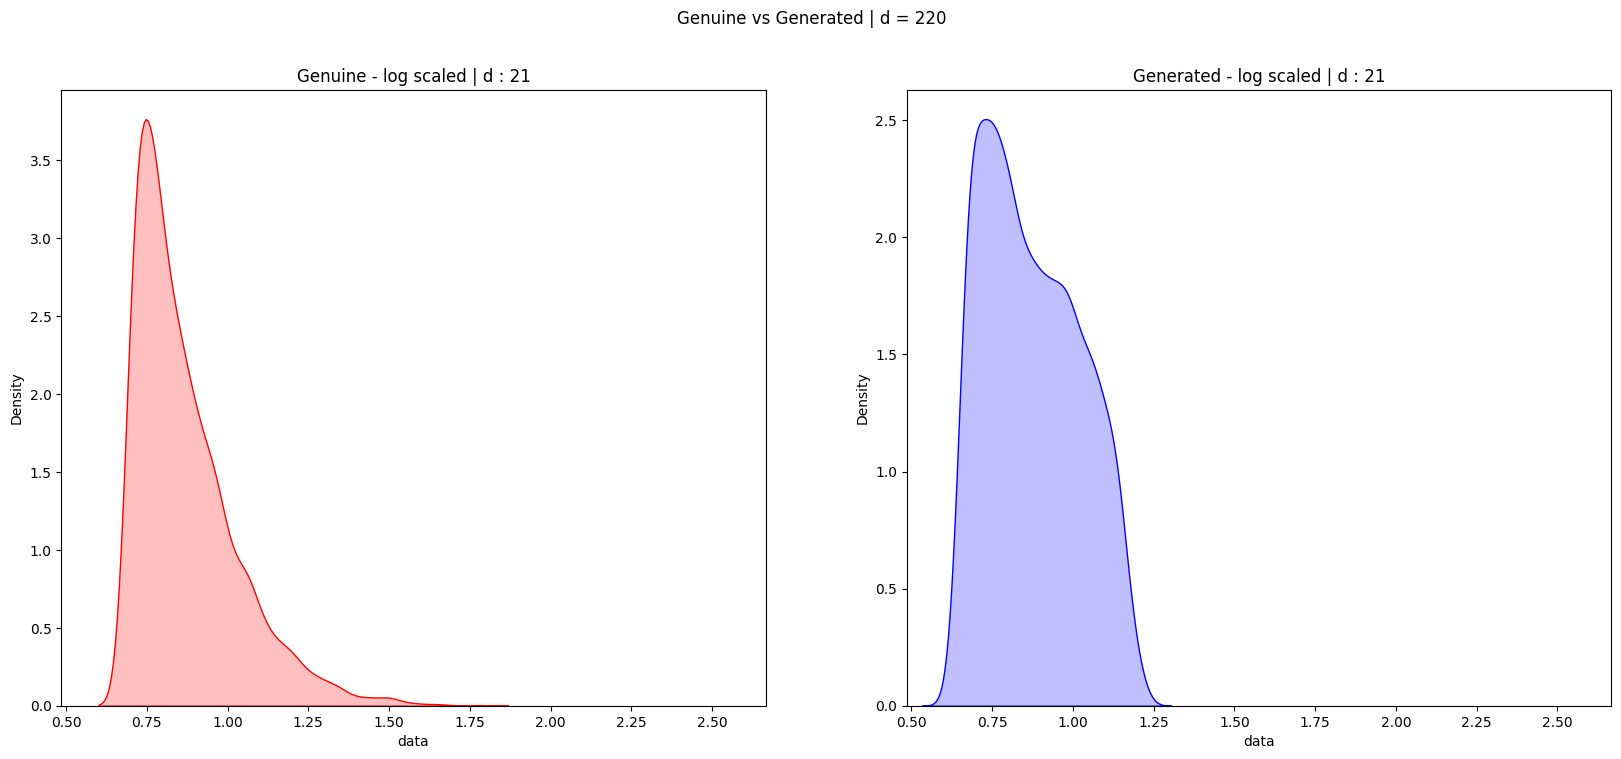

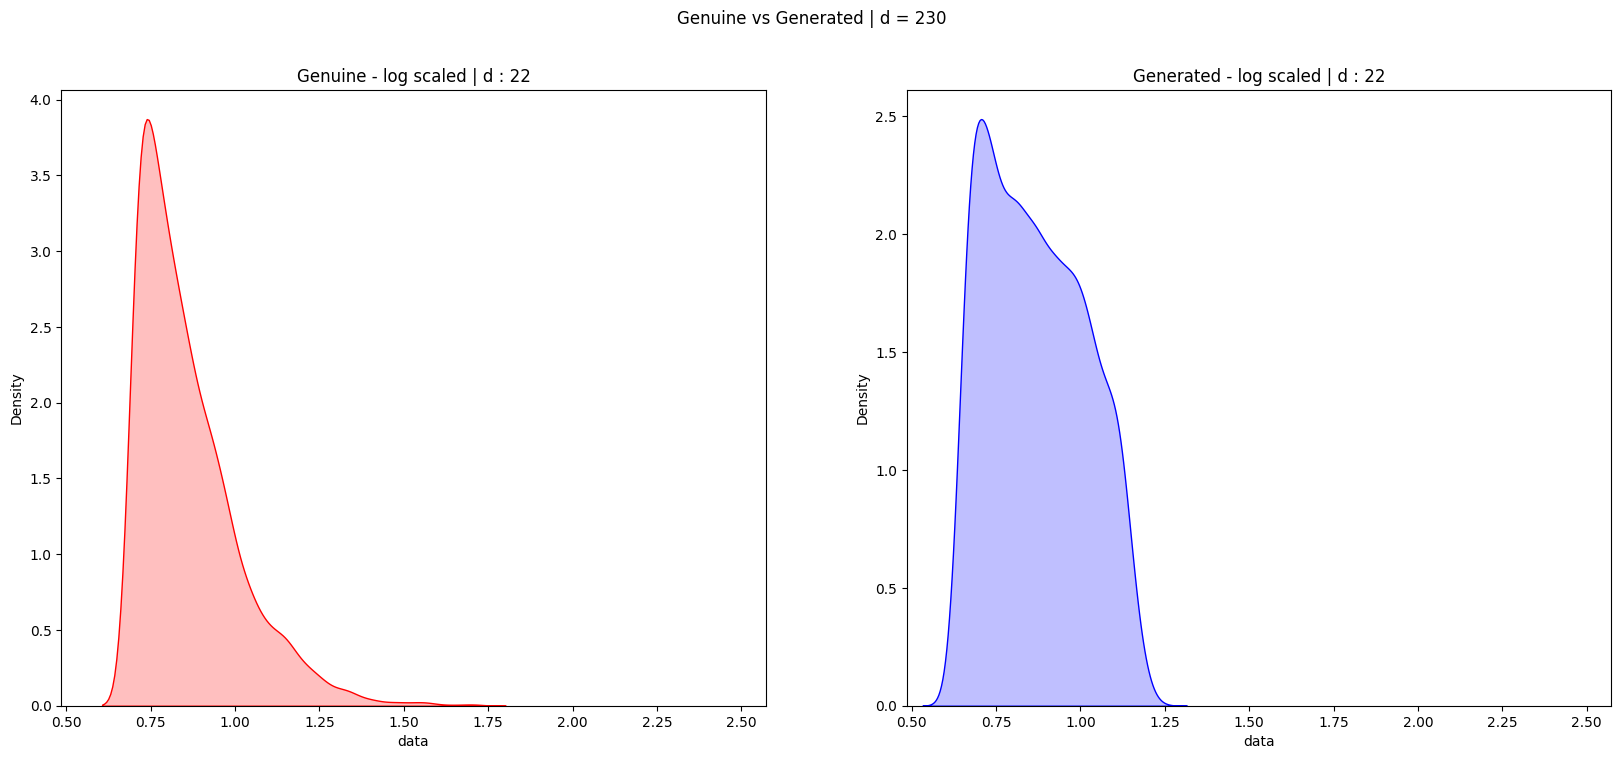

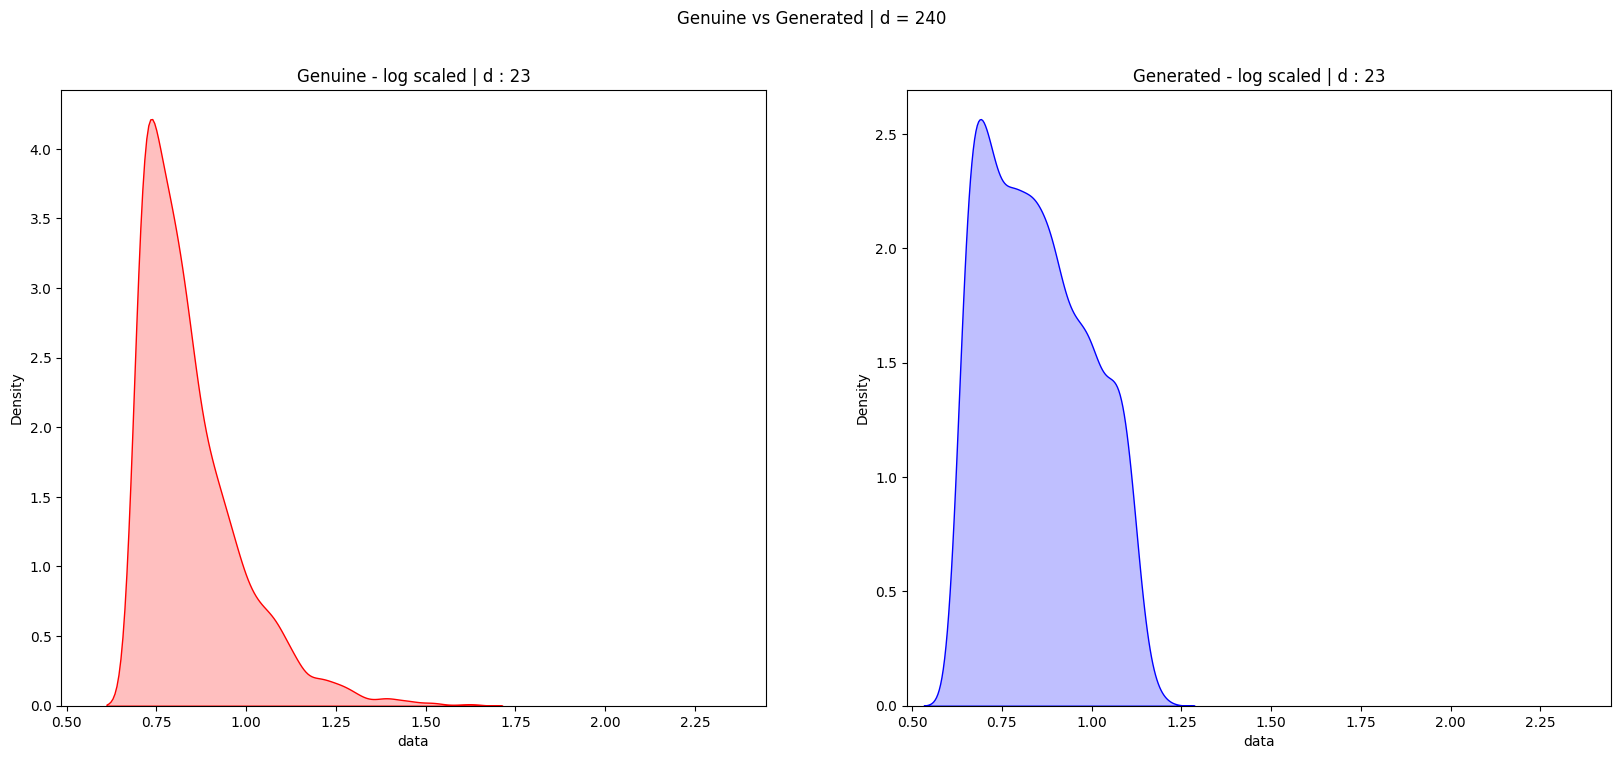

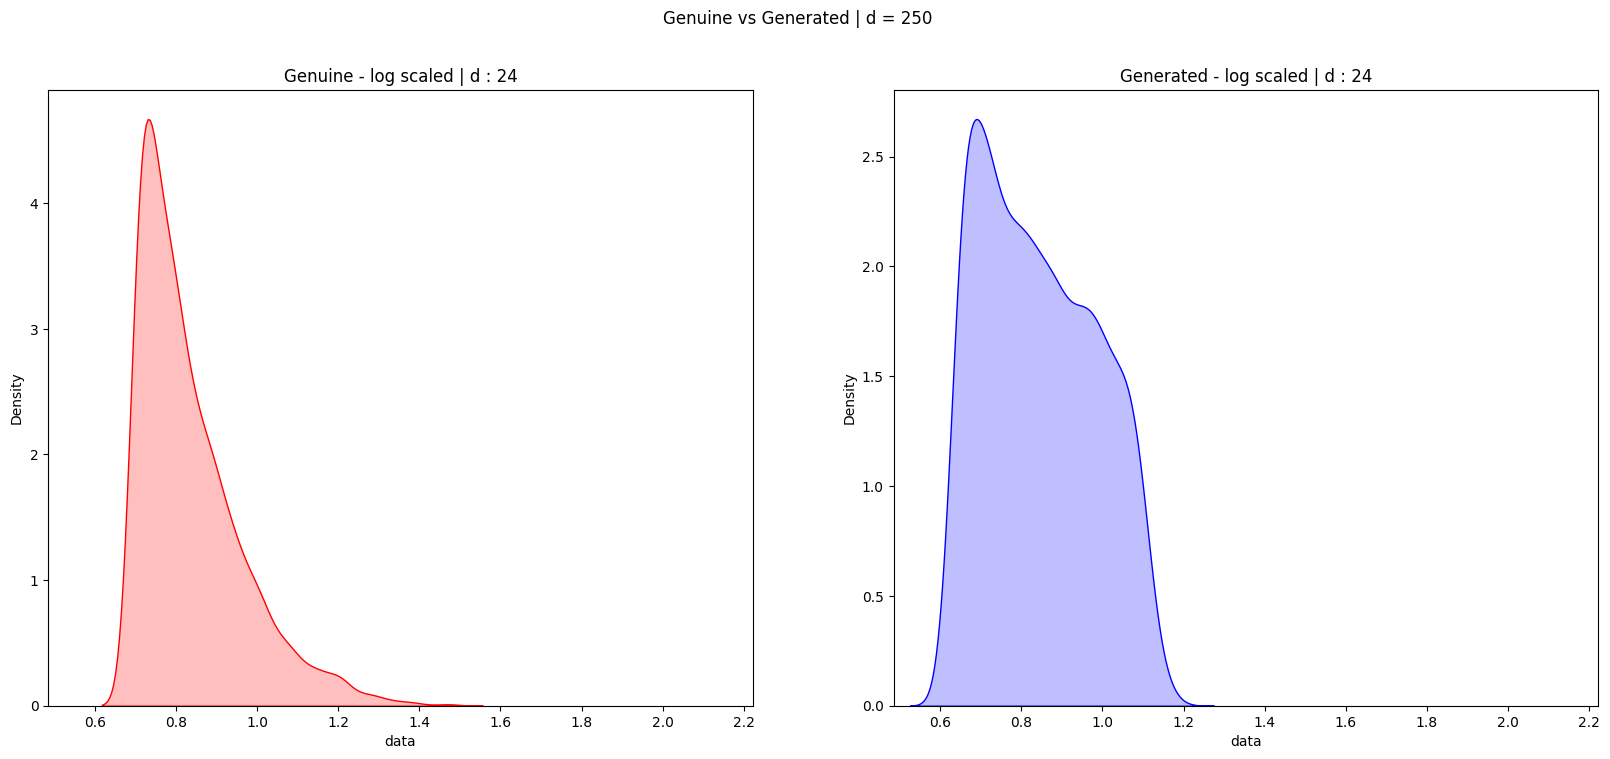

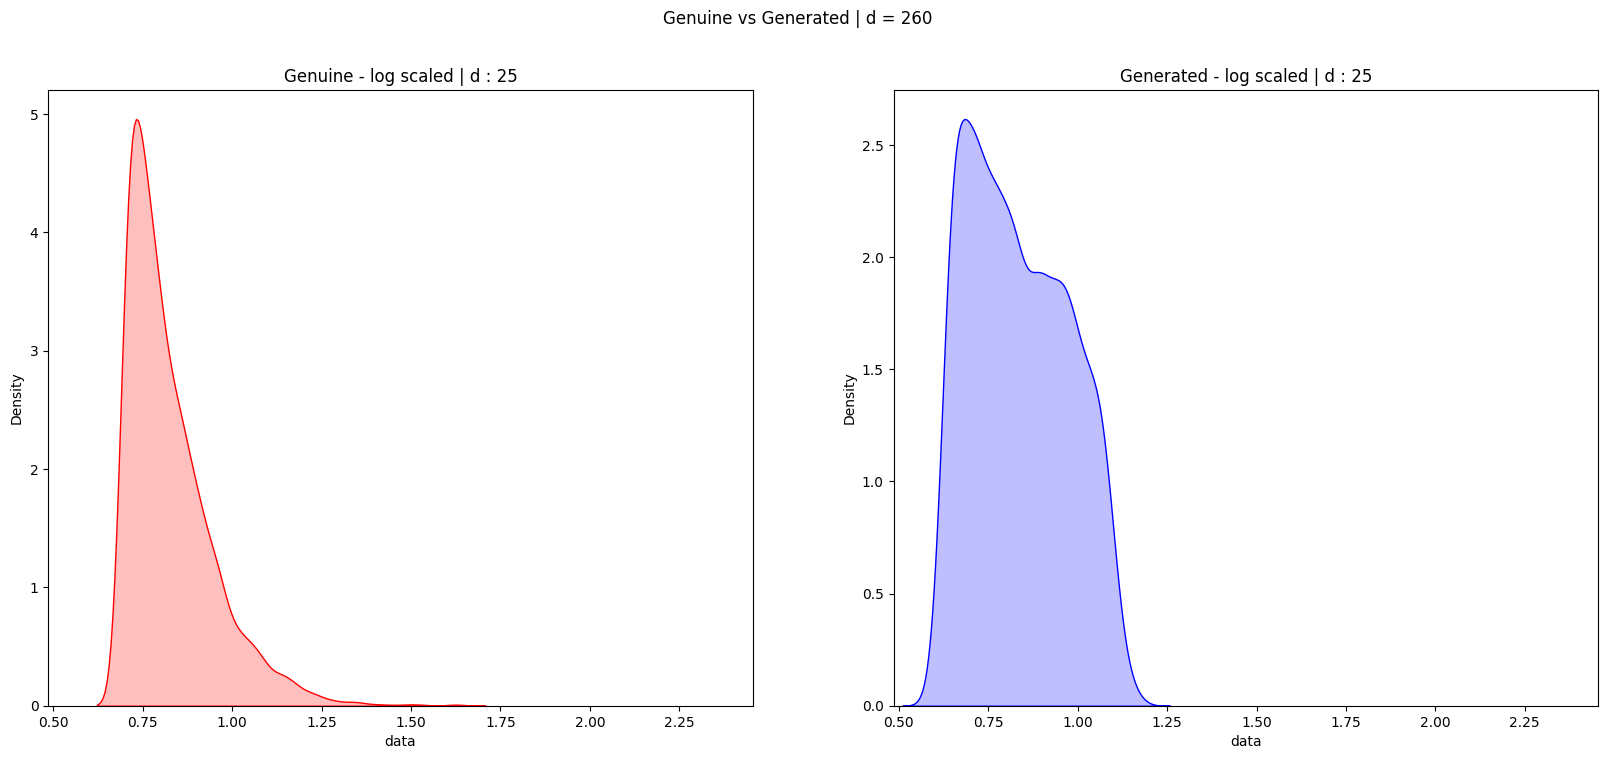

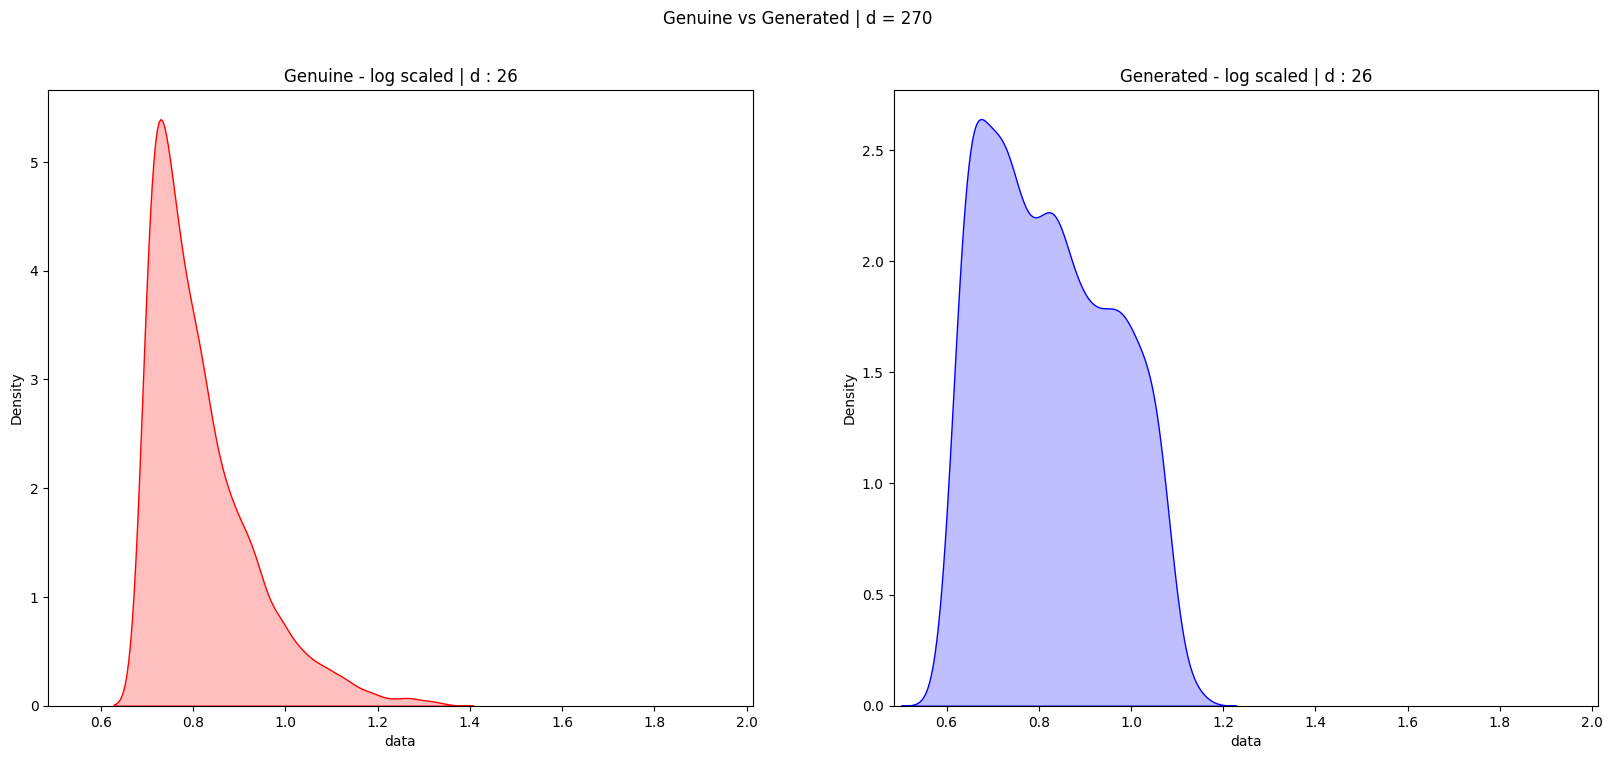

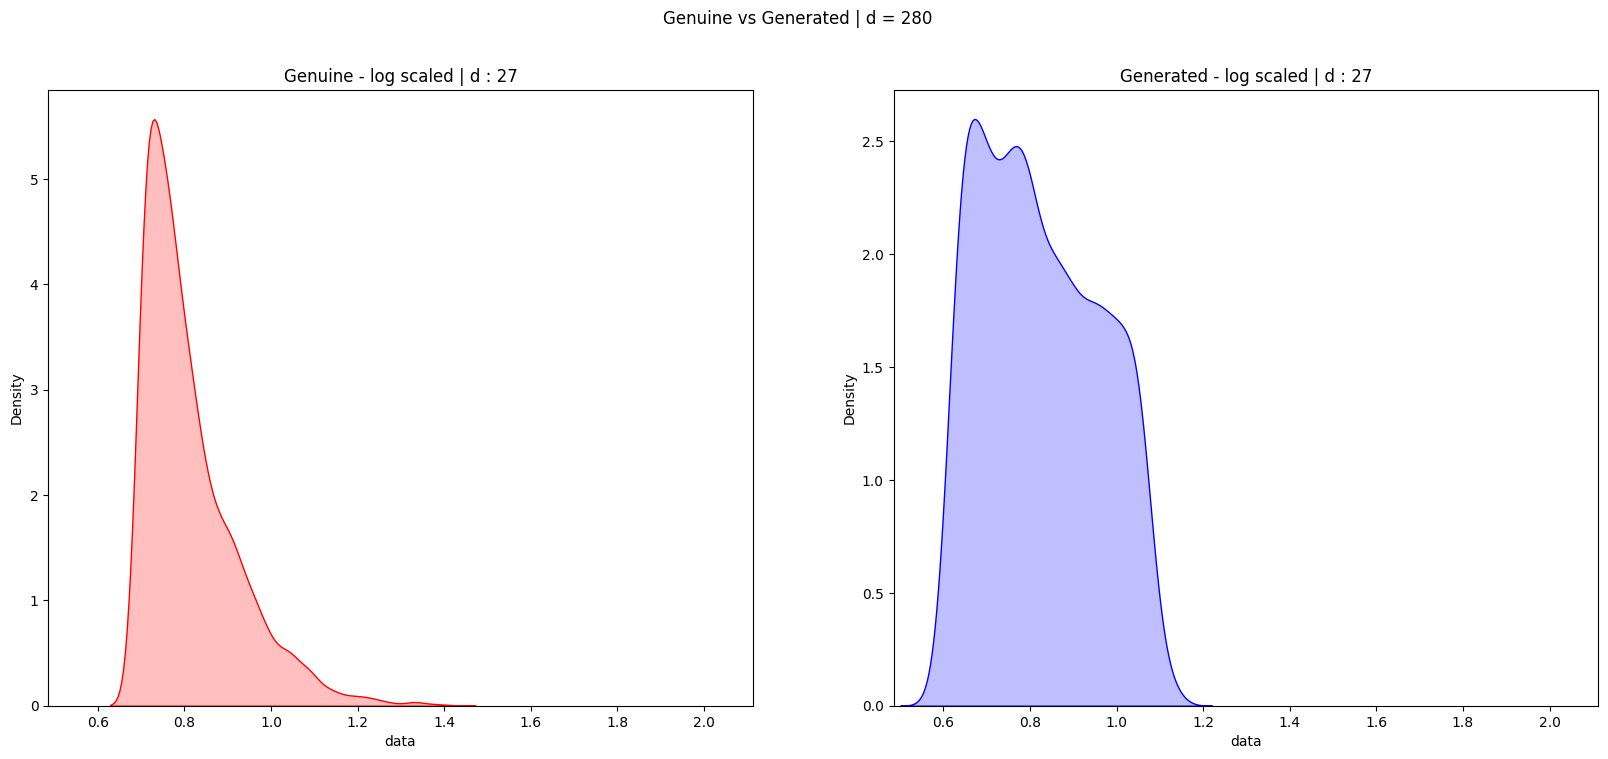

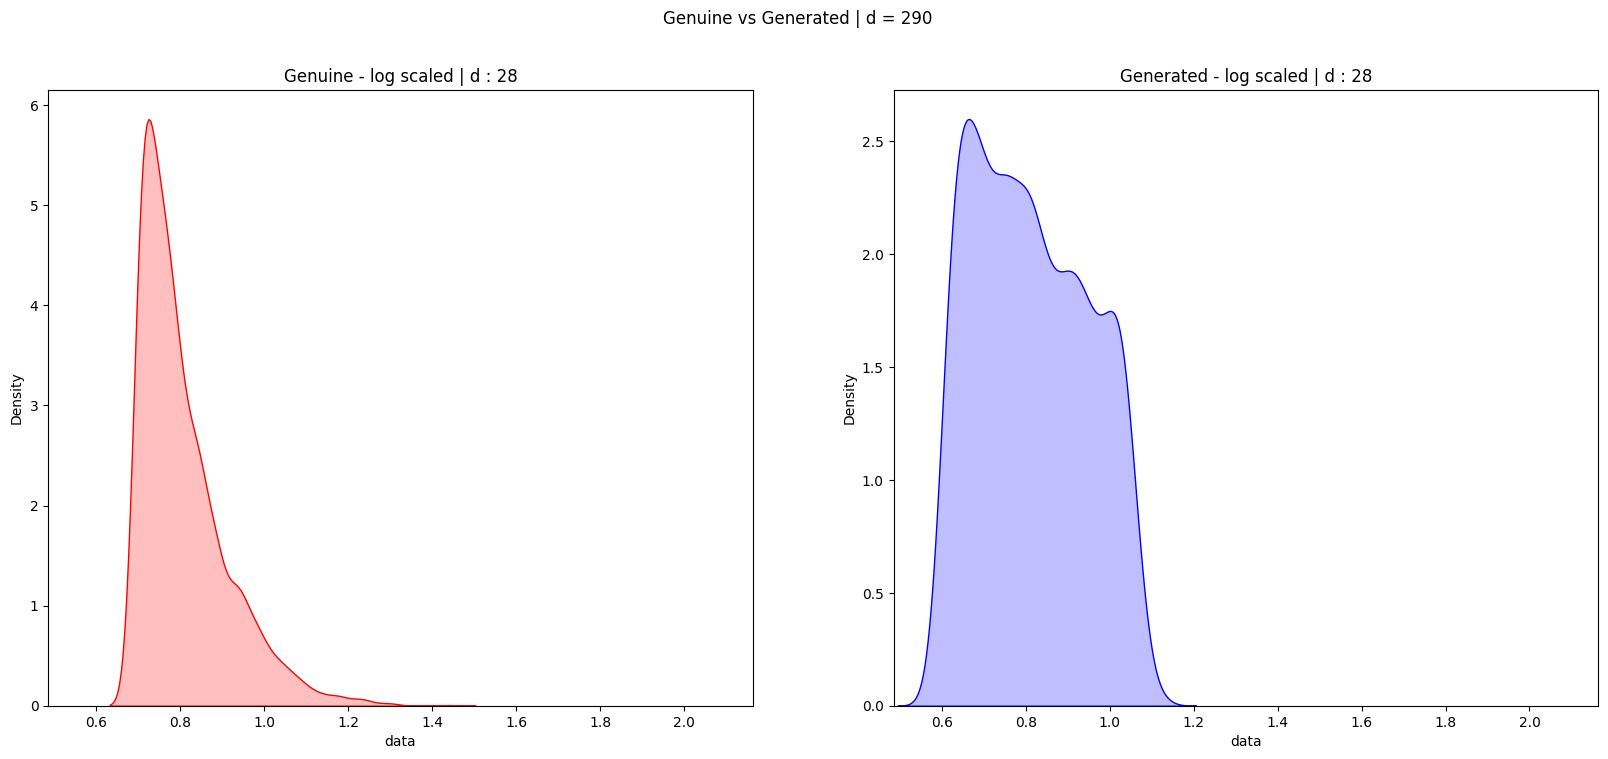

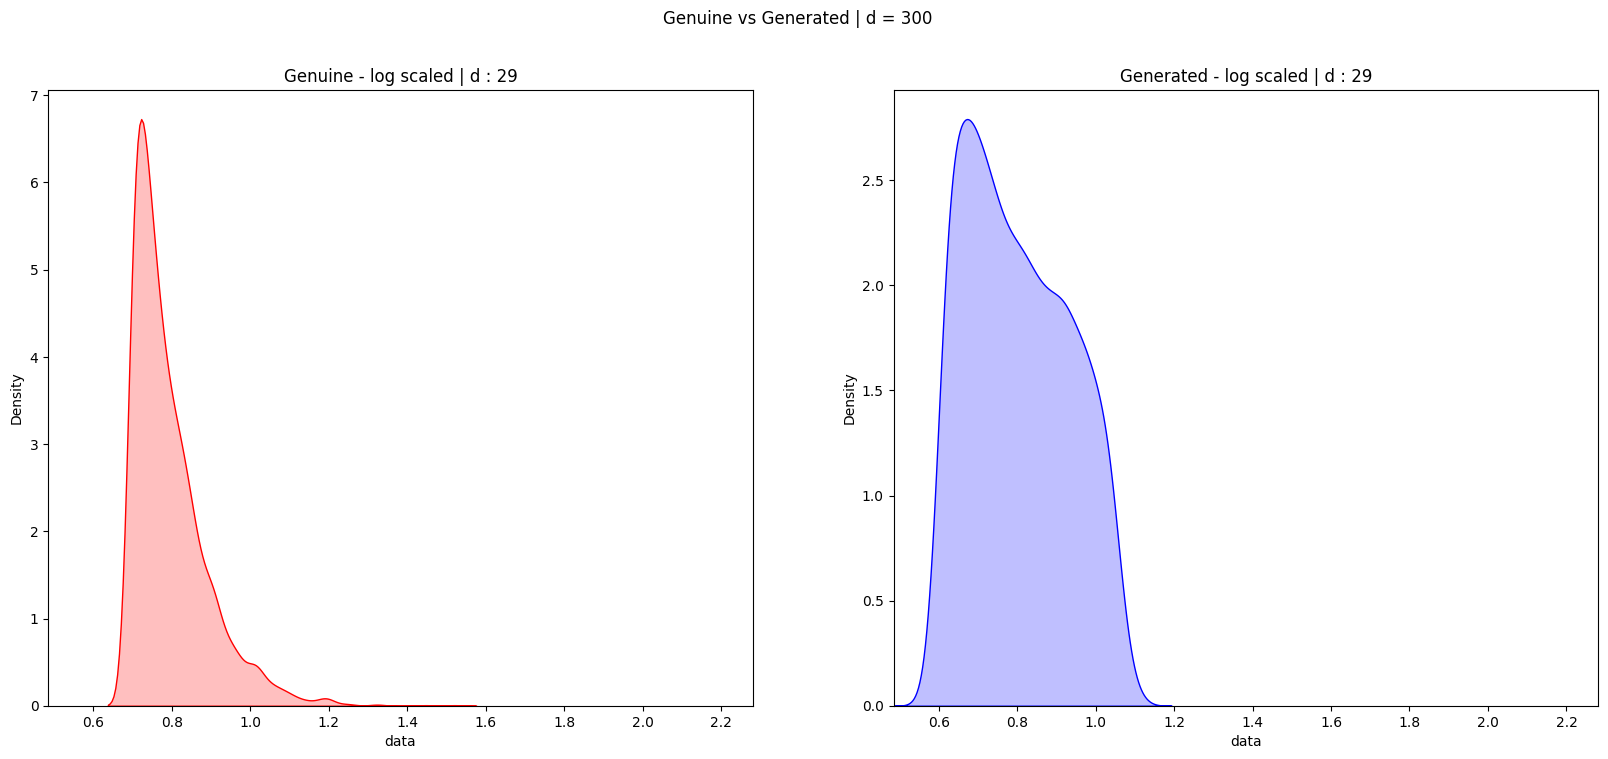

In [35]:
_d_array = np.arange(10, 301, 10, dtype=np.int32)
for i in range(len(df_genuine_log_scaled_eval['d'].unique())):
    # Melt the data to long-form
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    sns.kdeplot(data=df_genuine_log_scaled_eval[df_genuine_log_scaled_eval['d'] == i], x='data', 
                fill=True, ax=ax1, color='red')
    ax1.set_title(f"Genuine - log scaled | d : {i}")
    x_range_plot_logged = df_genuine_log_scaled_eval[df_genuine_log_scaled_eval['d'] == i]['data']
    sns.kdeplot(data=df_generated_log_scaled_eval[df_generated_log_scaled_eval['d'] == i], x='data', 
                fill=True, ax=ax2, color='blue')
    ax2.set_title(f"Generated - log scaled | d : {i}")



    ax1.set_xlim([x_range_plot_logged.min()*0.7, x_range_plot_logged.max()*1.5])
    ax2.set_xlim([x_range_plot_logged.min()*0.7, x_range_plot_logged.max()*1.5])
    
    
    fig.suptitle(f"Genuine vs Generated | d = {_d_array[i]}")
    plt.show()

In [36]:
df_afterward_log_scaled = df_generated_log_scaled_eval.copy()
df_afterward_log_scaled.rename(columns={'data':'genuine'}, inplace=True)
df_afterward_log_scaled['generated'] = df_generated_log_scaled_eval['data']
df_afterward_log_scaled

genuine     d         r  generated
0      0.878998  29.0  0.705379   0.878998
1      1.061947   7.0  0.033974   1.061947
2      1.411548   4.0  0.097116   1.411548
3      1.228774  13.0  0.742666   1.228774
4      0.978211  18.0  0.631450   0.978211
...         ...   ...       ...        ...
99995  1.530610   4.0  0.222645   1.530610
99996  0.687990  19.0  0.065192   0.687990
99997  0.732185  28.0  0.354816   0.732185
99998  1.347303   8.0  0.473878   1.347303
99999  0.784649  25.0  0.405985   0.784649

[100000 rows x 4 columns]

### Genuine vs Generated Comparison - with __scaled back__

In [37]:
df_afterward_back_scaled = df_genuine_log_scaled_eval.copy()
df_afterward_back_scaled['data'] = inverse_log_transform(df_genuine_log_scaled_eval['data'])
df_afterward_back_scaled.rename(columns={'data':'genuine'}, inplace=True)
df_afterward_back_scaled['generated'] = inverse_log_transform(df_generated_log_scaled_eval['data'])
df_afterward_back_scaled

genuine     d  generated
0      0.278984  29.0   0.408485
1      0.459803   7.0   0.891995
2      2.147238   4.0   2.102302
3      1.390473  13.0   1.417039
4      0.568106  18.0   0.659694
...         ...   ...        ...
99995  3.643518   4.0   2.620994
99996  0.034627  19.0  -0.010288
99997  0.107059  28.0   0.079620
99998  2.024563   8.0   1.847036
99999  0.158305  25.0   0.191638

[100000 rows x 3 columns]

In [38]:
df_afterward_back_scaled_vertical = pd.melt(df_afterward_back_scaled, id_vars=['d'], value_vars=['genuine', 'generated'],
                      var_name='aux', value_name='data').sort_values(by='aux', ascending=False)
df_afterward_back_scaled_vertical

d        aux       data
0       29.0    genuine   0.278984
66651    1.0    genuine  84.374039
66673   19.0    genuine   0.545778
66672    1.0    genuine  93.813314
66671   12.0    genuine   0.877101
...      ...        ...        ...
133331  14.0  generated   0.409724
133330   9.0  generated   1.442682
133329   4.0  generated   2.149199
133328  13.0  generated   0.405714
199999  25.0  generated   0.191638

[200000 rows x 3 columns]

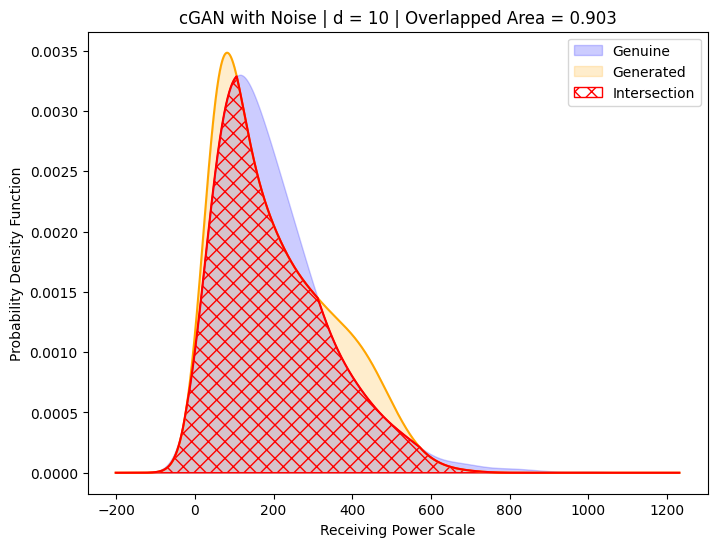

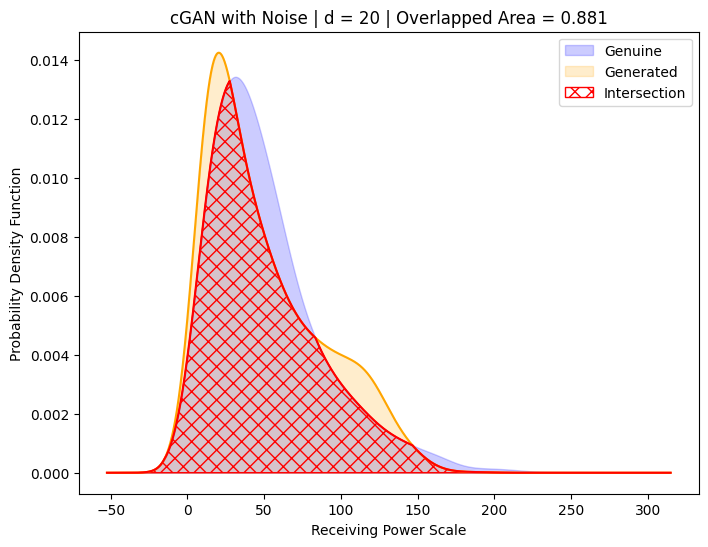

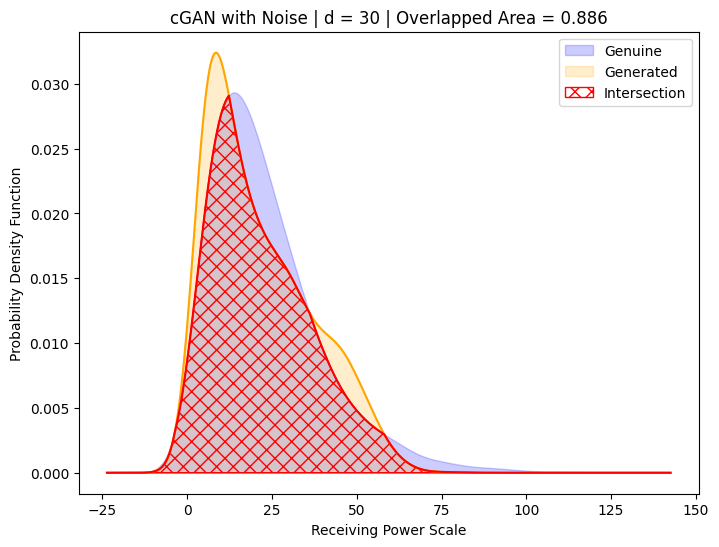

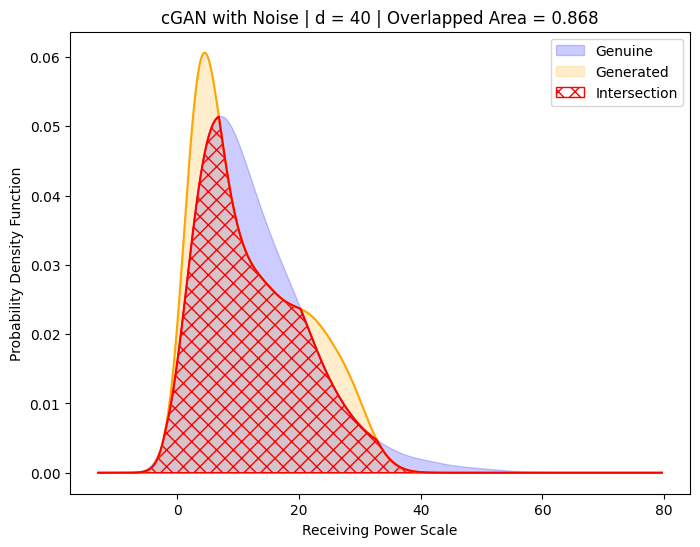

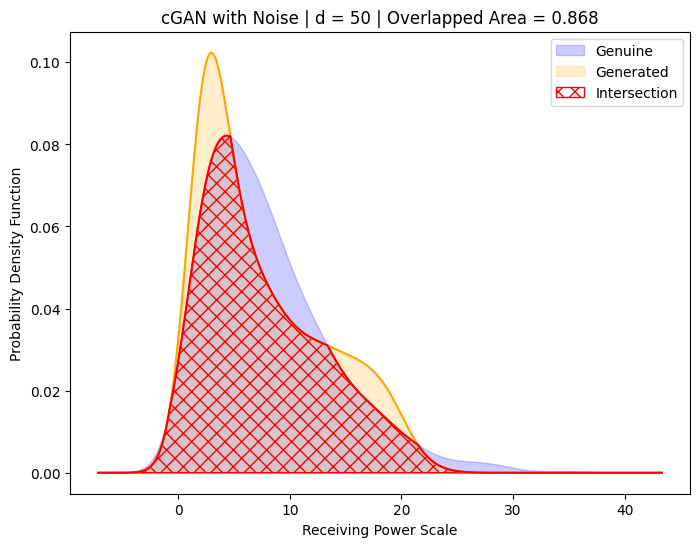

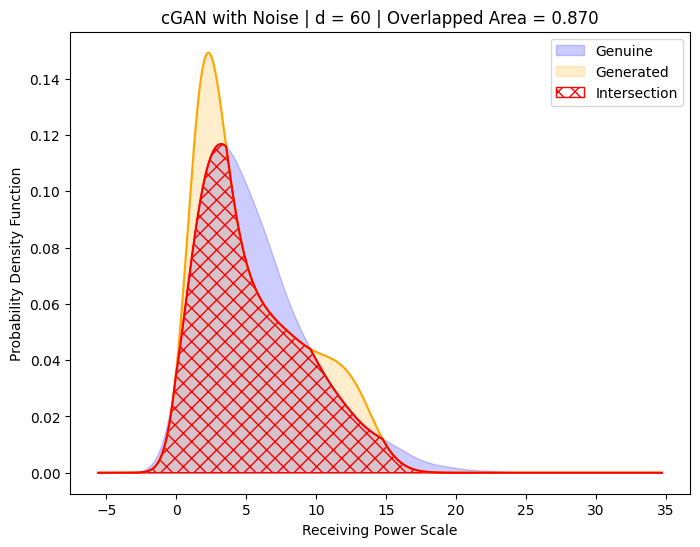

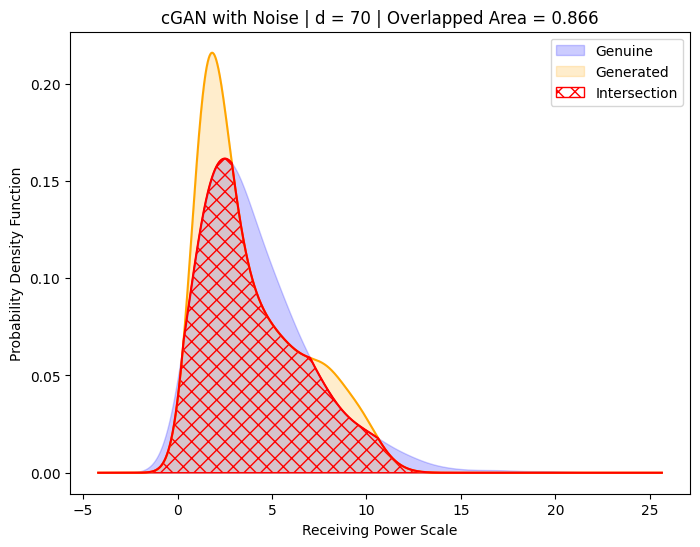

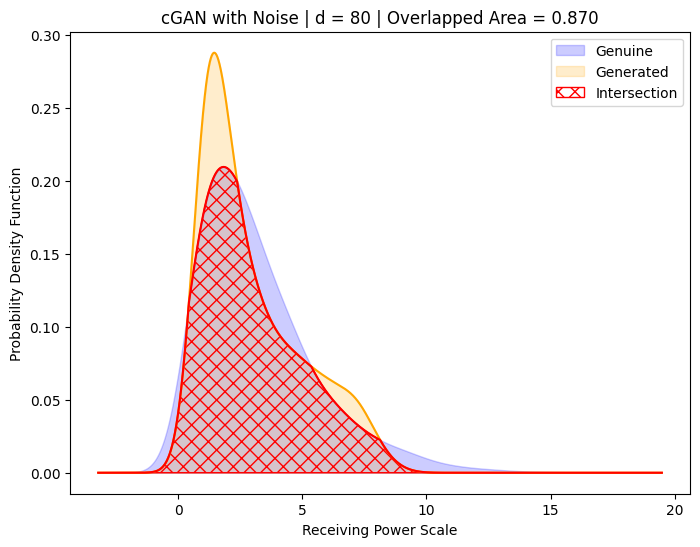

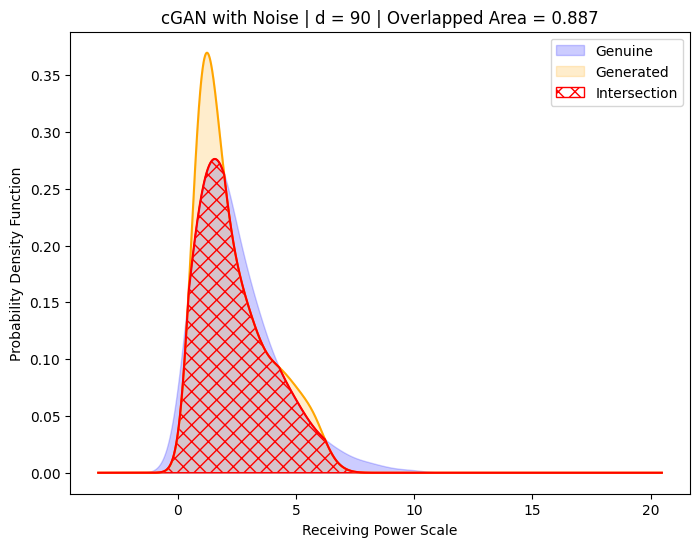

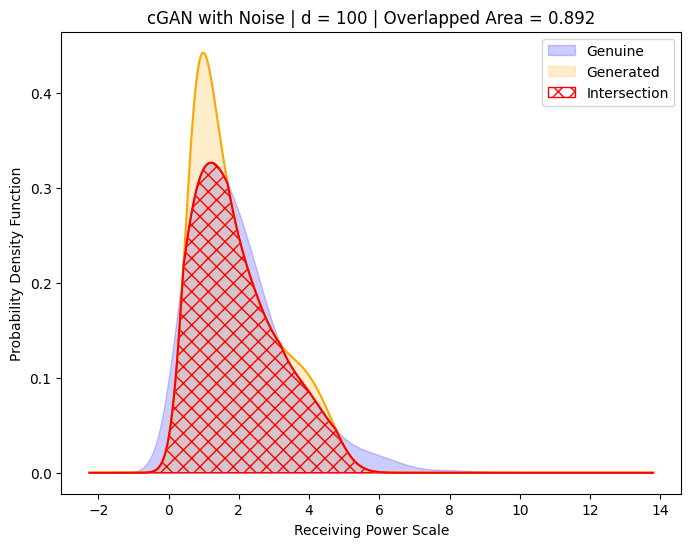

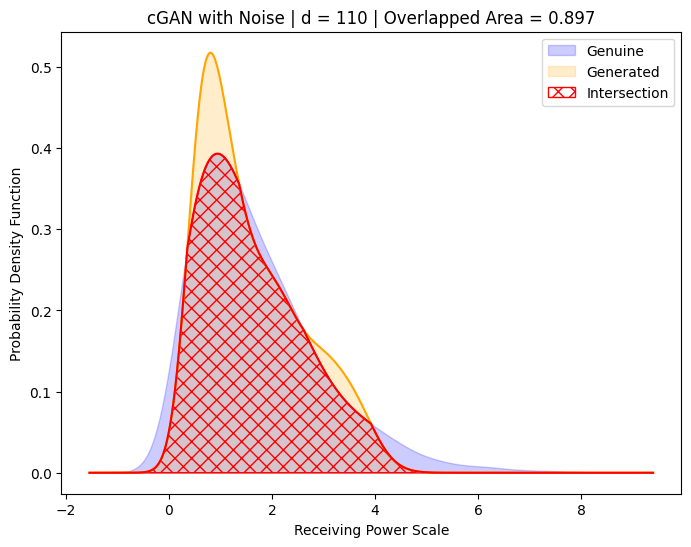

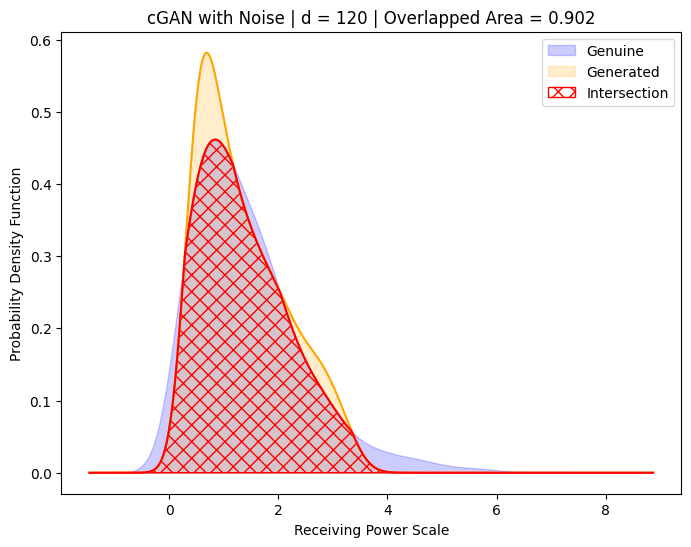

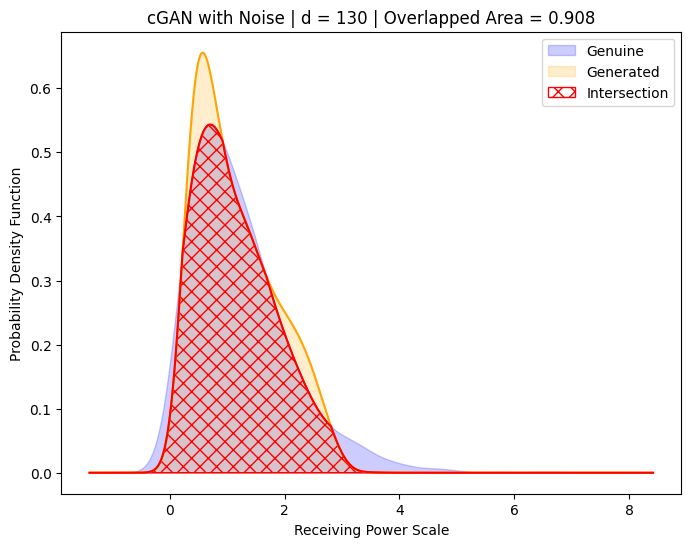

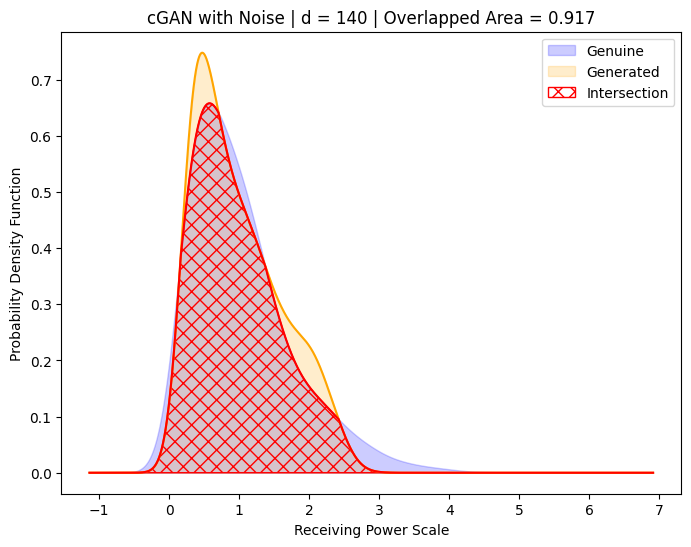

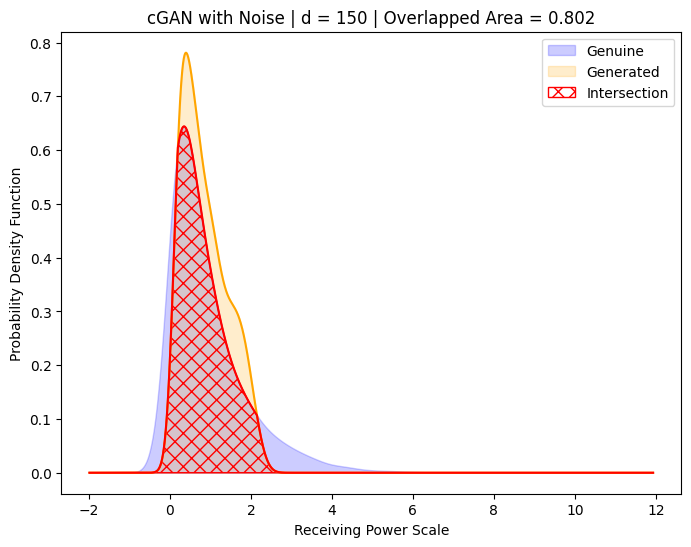

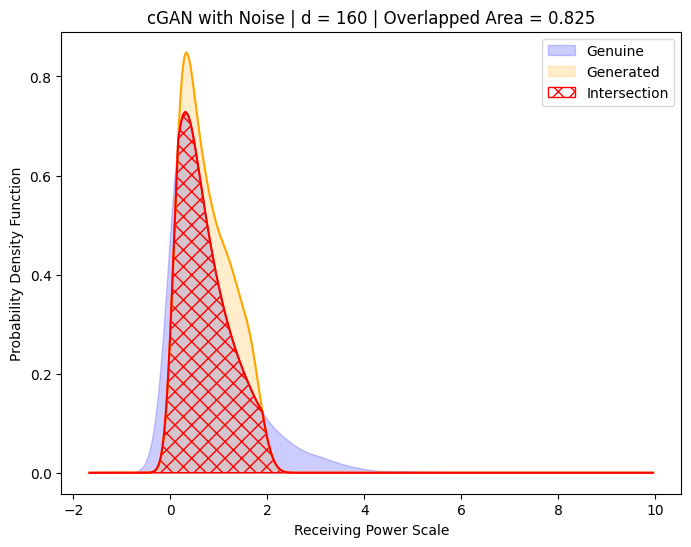

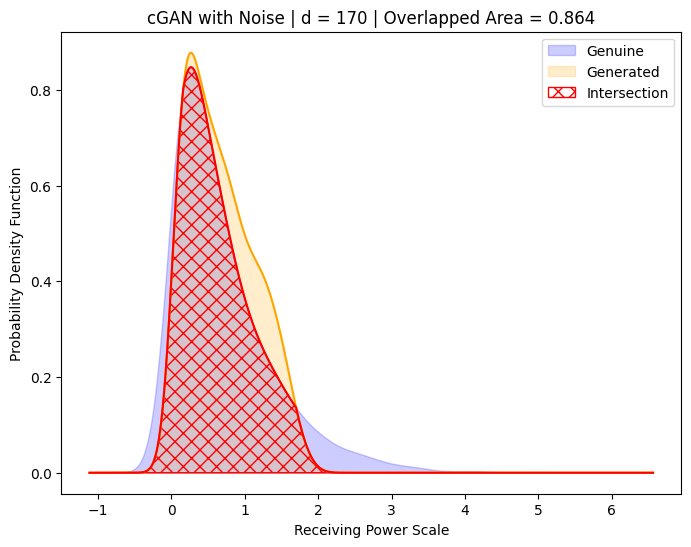

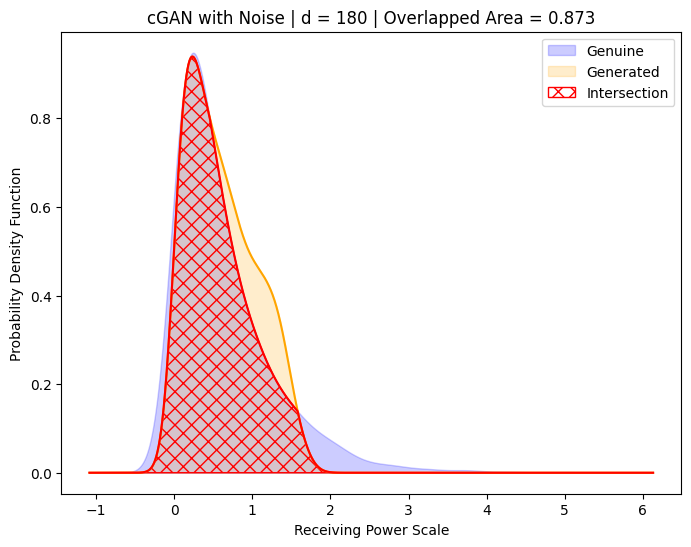

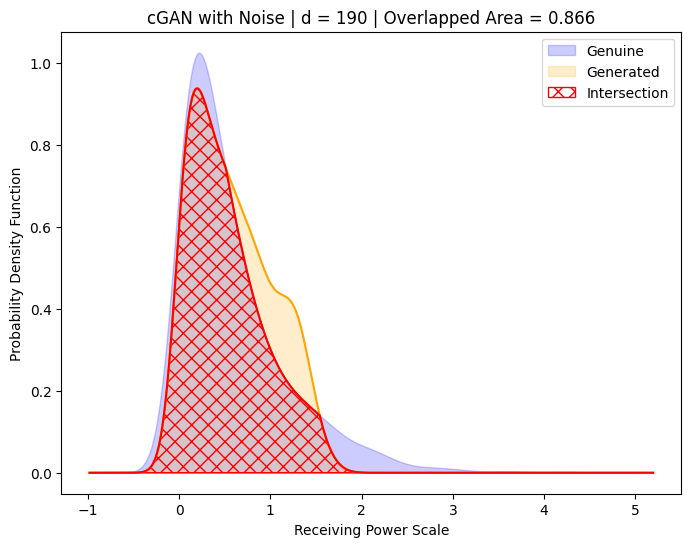

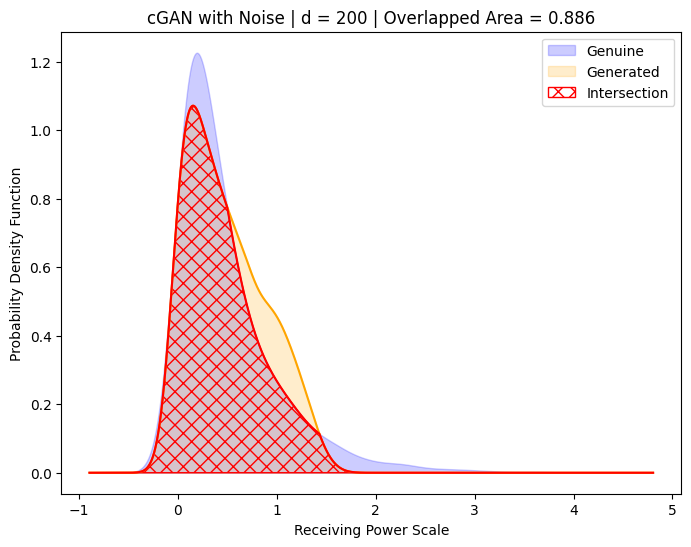

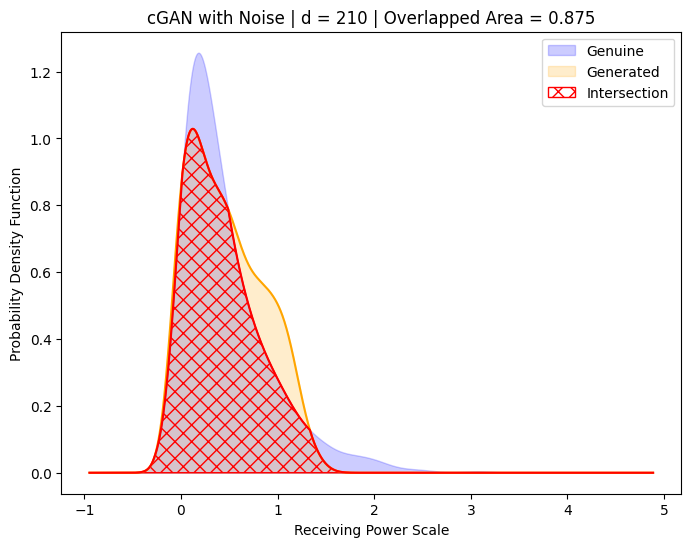

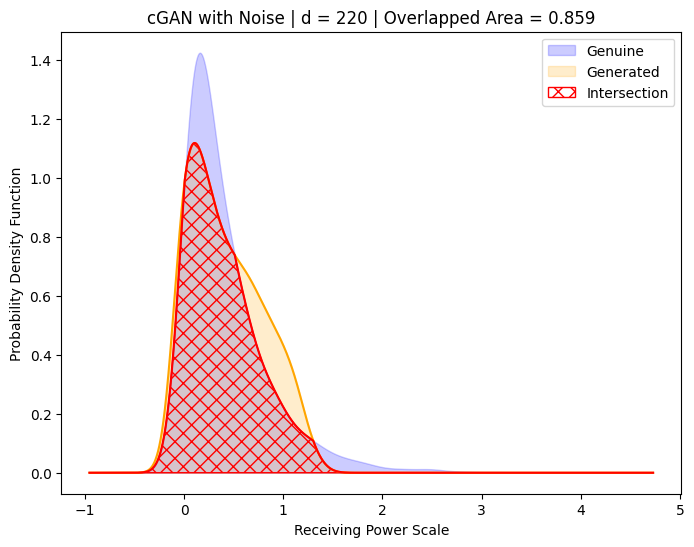

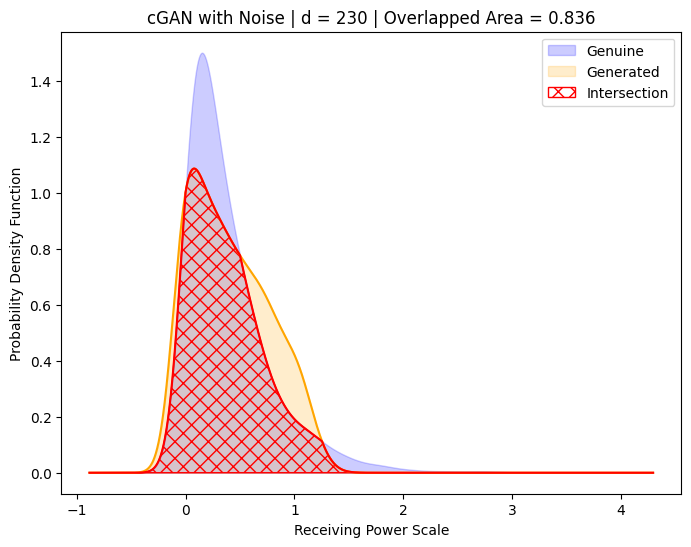

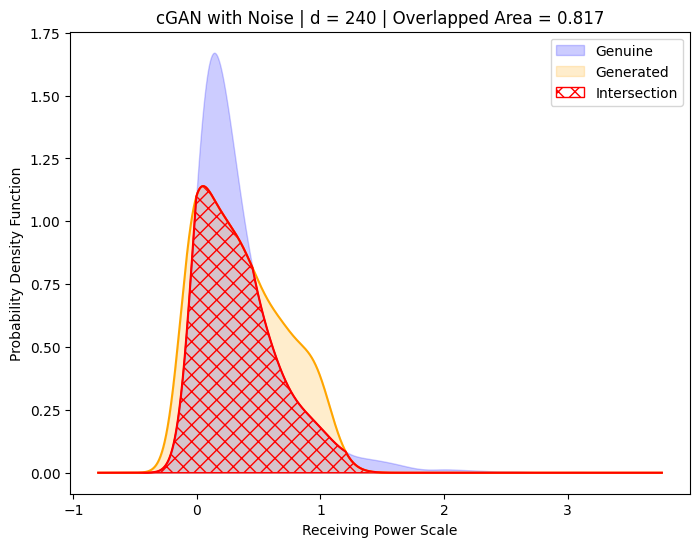

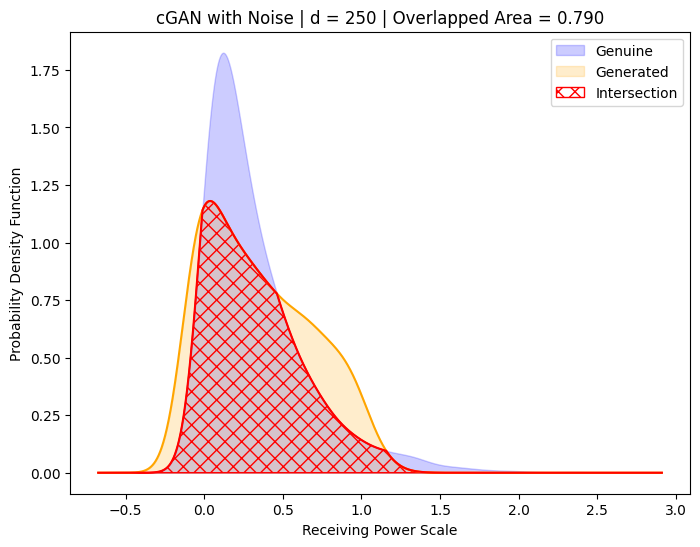

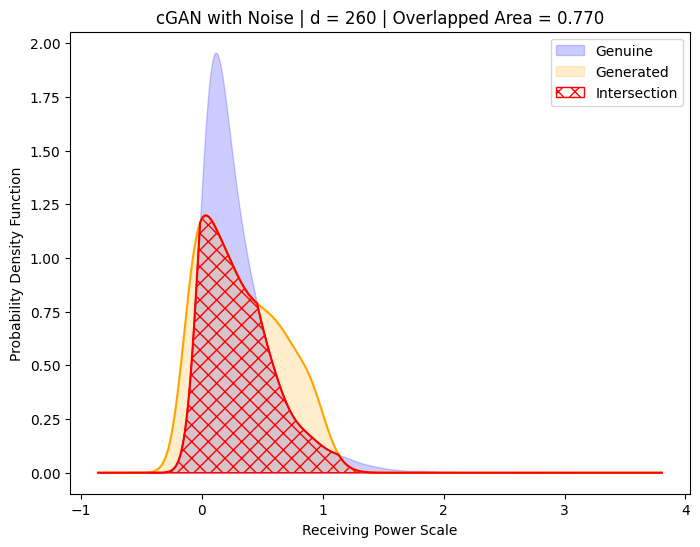

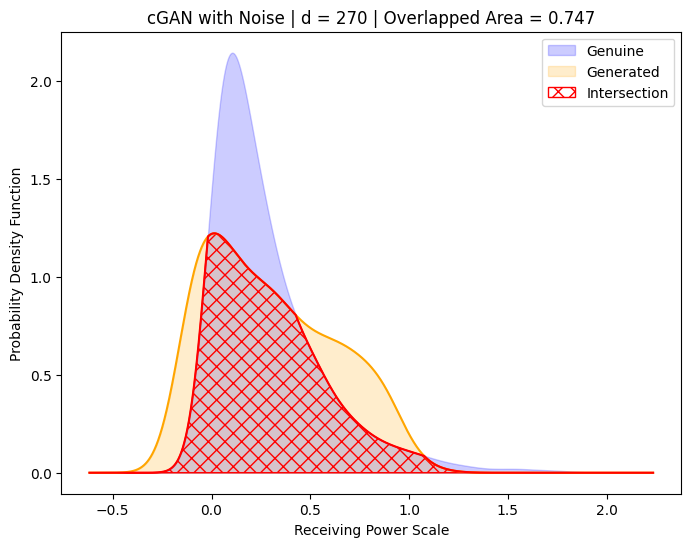

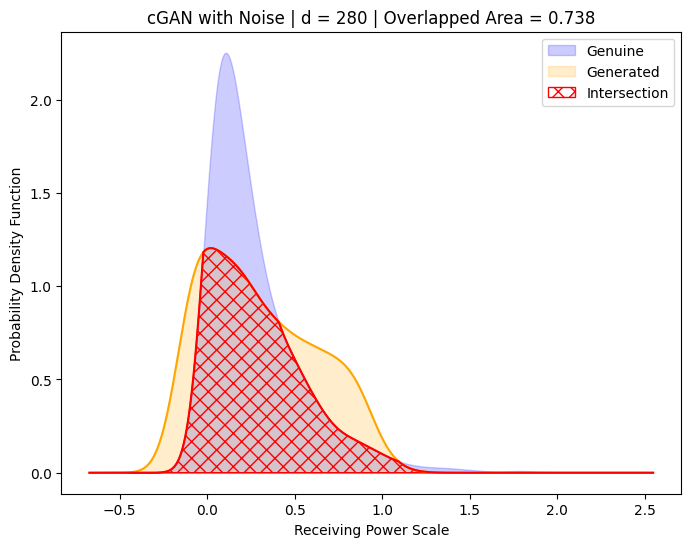

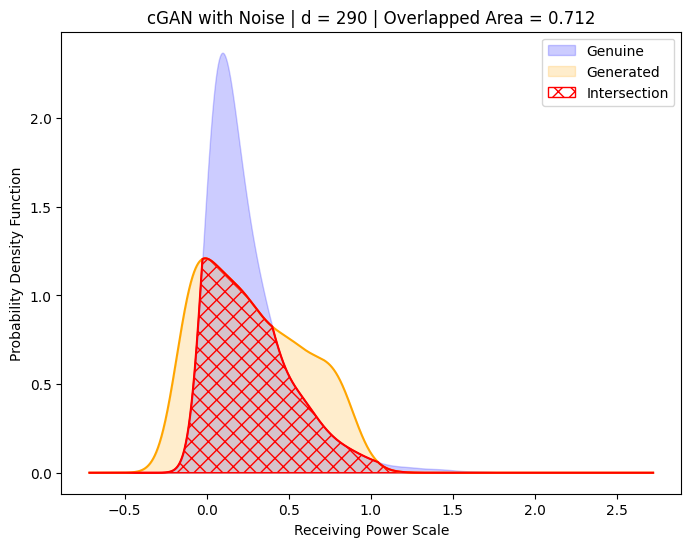

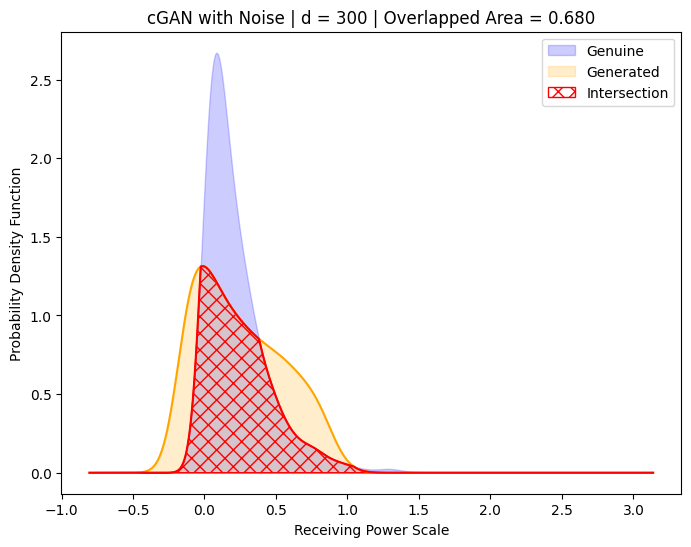

In [39]:
# https://stackoverflow.com/questions/62375034/find-non-overlapping-area-between-two-kde-plots
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

_d_array = np.arange(10, 301, 10, dtype=np.int32)
list_for_df = list()
for i in range(len(df_afterward_back_scaled['d'].unique())):
    # Melt the data to long-form
    fig, ax = plt.subplots(figsize=(8, 6))
    
    x0 = df_afterward_back_scaled[df_afterward_back_scaled['d'] == i]['genuine']
    x1 = df_afterward_back_scaled[df_afterward_back_scaled['d'] == i]['generated']

    kde0 = gaussian_kde(x0, bw_method=0.3)
    kde1 = gaussian_kde(x1, bw_method=0.3)
    
    xmin = min(x0.min(), x1.min())
    xmax = max(x0.max(), x1.max())
    
    dx = 0.2 * (xmax - xmin) # add a 20% margin, as the kde is wider than the data
    xmin -= dx
    xmax += dx
    
    x = np.linspace(xmin, xmax, len(x0))
    kde0_x = kde0(x)
    kde1_x = kde1(x)
    inters_x = np.minimum(kde0_x, kde1_x)

    plt.fill_between(x, kde0_x, 0, color='b', alpha=0.2, label='Genuine')
    plt.plot(x, kde1_x, color='orange')
    plt.fill_between(x, kde1_x, 0, color='orange', label='Generated', alpha=0.2)
    plt.plot(x, inters_x, color='r')
    plt.fill_between(x, inters_x, 0, facecolor='none', edgecolor='r', hatch='xx', label='Intersection')
    
    area_inters_x = np.trapz(inters_x, x)
    
    list_for_df.append([i, area_inters_x])
    ax.set_title(f"cGAN with Noise | d = {_d_array[i]} | Overlapped Area = {area_inters_x:.3f}")
    plt.xlabel('Receiving Power Scale')
    plt.ylabel('Probability Density Function')
    legend = plt.legend()

    plt.show()


In [40]:
df_oa_back_scaled = pd.DataFrame(list_for_df, columns=['d', 'area_overlapped'])
print(f"Average Overlapped Area = {df_oa_back_scaled['area_overlapped'].mean()}")
df_oa_back_scaled

Average Overlapped Area = 0.8451205155798956


d  area_overlapped
0    0         0.902591
1    1         0.881411
2    2         0.886276
3    3         0.867707
4    4         0.867643
5    5         0.870025
6    6         0.865683
7    7         0.869971
8    8         0.886515
9    9         0.891507
10  10         0.896578
11  11         0.902424
12  12         0.908053
13  13         0.916813
14  14         0.801604
15  15         0.824714
16  16         0.863877
17  17         0.873406
18  18         0.865926
19  19         0.886103
20  20         0.875359
21  21         0.859387
22  22         0.836034
23  23         0.816822
24  24         0.790033
25  25         0.769929
26  26         0.746901
27  27         0.738423
28  28         0.711671
29  29         0.680229

### Generated Data Evalulation

#### Mean

In [41]:
df_mean_comp = pd.concat([df_afterward_back_scaled.groupby('d')['generated'].mean(), df_ideal_mean], axis=1)
df_per_diff_mean_real = (((df_mean_comp['generated'] - df_mean_comp['ideal_data']) / df_mean_comp['ideal_data']) * 100).round(2)
df_per_diff_mean_dict = {'per_diff%':df_per_diff_mean_real, }
df_mean_comp_final = pd.concat([df_mean_comp, pd.DataFrame(df_per_diff_mean_dict)], axis=1)
df_mean_comp_final

generated  ideal_data  per_diff%
0.0   203.413940  205.460011      -1.00
1.0    49.914375   51.365003      -2.82
2.0    21.377972   22.828890      -6.36
3.0    11.982495   12.841251      -6.69
4.0     7.517343    8.218400      -8.53
5.0     5.375960    5.707223      -5.80
6.0     3.881227    4.193061      -7.44
7.0     2.968981    3.210313      -7.52
8.0     2.336221    2.536543      -7.90
9.0     1.907466    2.054600      -7.16
10.0    1.597941    1.698017      -5.89
11.0    1.352211    1.426806      -5.23
12.0    1.157452    1.215740      -4.79
13.0    0.987674    1.048265      -5.78
14.0    0.865528    0.913156      -5.22
15.0    0.768088    0.802578      -4.30
16.0    0.676214    0.710934      -4.88
17.0    0.612637    0.634136      -3.39
18.0    0.584354    0.569141       2.67
19.0    0.491149    0.513650      -4.38
20.0    0.470914    0.465896       1.08
21.0    0.424663    0.424504       0.04
22.0    0.408686    0.388393       5.22
23.0    0.362288    0.356701       1.57
24.0    0.350270    0.328736       6.55
25.0    0.329142    0.303935       8.29
26.0    0.303102    0.281838       7.54
27.0    0.301903    0.262066      15.20
28.0    0.277881    0.244304      13.74
29.0    0.252481    0.228289      10.60

#### Variance

In [42]:
df_var_comp = pd.concat([df_afterward_back_scaled.groupby('d')['generated'].var(), df_ideal_var], axis=1)
df_per_diff_var_real = (((df_var_comp['generated'] - df_var_comp['ideal_data']) / df_var_comp['ideal_data']) * 100).round(2)
df_per_diff_var_dict = {'per_diff%':df_per_diff_var_real, }
df_var_comp_final = pd.concat([df_var_comp, pd.DataFrame(df_per_diff_var_dict)], axis=1)
df_var_comp_final

generated    ideal_data  per_diff%
0.0   20198.585938  21106.908132      -4.30
1.0    1361.718018   1319.181758       3.22
2.0     224.321335    260.579113     -13.91
3.0      72.629166     82.448860     -11.91
4.0      30.225185     33.771053     -10.50
5.0      14.345608     16.286195     -11.92
6.0       7.044224      8.790882     -19.87
7.0       3.960661      5.153054     -23.14
8.0       2.171645      3.217026     -32.50
9.0       1.329255      2.110691     -37.02
10.0      0.938570      1.441630     -34.90
11.0      0.638599      1.017887     -37.26
12.0      0.470564      0.739012     -36.33
13.0      0.366531      0.549430     -33.29
14.0      0.306941      0.833853     -63.19
15.0      0.250683      0.644132     -61.08
16.0      0.208698      0.505428     -58.71
17.0      0.185814      0.402128     -53.79
18.0      0.184561      0.323922     -43.02
19.0      0.151489      0.263836     -42.58
20.0      0.144237      0.217059     -33.55
21.0      0.133566      0.180204     -25.88
22.0      0.127113      0.150849     -15.74
23.0      0.116928      0.127236      -8.10
24.0      0.112999      0.108067       4.56
25.0      0.107267      0.092376      16.12
26.0      0.101771      0.079433      28.12
27.0      0.100656      0.068679      46.56
28.0      0.096570      0.059685      61.80
29.0      0.089955      0.052116      72.61